In [1]:
#-*-coding:utf-8-*-
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Sequential
import util
import utils
import tensorflow.contrib.gan as tfgan
num_images_to_eval = 500
import torch.nn as nn
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, imgs, transform=None):
        # super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)
        return img


import math
import os
import numpy as np
import ot
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from scipy import linalg

from keras.datasets import mnist
import matplotlib.pyplot as plt

def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)

def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        print(os.getcwd() + dataroot)  # 函数的作用是用于返回当前工作目录
        # folder dataset
        # dataset = dset.ImageFolder(root=dataroot,
        dataset = dset.ImageFolder(root=os.getcwd() + dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       # transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset

MNIST_CLASSIFIER_FROZEN_GRAPH = './classify_mnist_graph_def.pb'
INPUT_TENSOR = 'inputs:0'
OUTPUT_TENSOR = 'logits:0'
# CONV_TENSOR = 'fc3/Relu:0'
CONV_TENSOR = 'fc4/BiasAdd:0'
class ConvNetFeatureSaver(object):
    def __init__(self, model='cnn', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('tfgan') >= 0:
            print('tfgan')

        elif self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, dataloader, save2disk=False):
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []

        for img in dataloader:
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'tfgan':
                    gen_imgs = np.array(img)
                    eval_images = tf.convert_to_tensor(gen_imgs)
                    flogit = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, OUTPUT_TENSOR)
                    fconv = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, CONV_TENSOR)
                    flogit,fconv=tf.Session().run([flogit,fconv])

                    flogit=torch.from_numpy(flogit)
                    fconv=torch.from_numpy(fconv)
                elif self.model == 'vgg' or self.model == 'vgg16':
                    print(self.vgg.features(input).shape)
                    fconv = self.vgg.features(input).view(input.size(0), -1)  # 相当于reshape
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                '''
                总共有四个空间：1.feature_pixl 2.feature_conv 3.feature_logit 4.feature_smax
                '''
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        return feature_pixl, feature_conv, feature_logit, feature_smax

    # return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem * torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e


eps = 1e-20


def inception_score(X):
    kl = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score


def mode_score(X, Y):
    kl1 = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0) + eps).log() - (Y.mean(0) + eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
            np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


'''
参数说明：
dataset:真实数据集的path
imageSize:图片的大小
dataroot_real:真实数据所在的path
batchSize
saveFolder_r:真实数据的保存位置
conv_model:卷积模型
'''


def compute_score_raw(real_dataloader, fake_dataloader, batchSize, saveFolder_r, saveFolder_f, conv_model='resnet34',
                      workers=4):
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    print(saveFolder_r)
    print(saveFolder_f)
    feature_r = convnet_feature_saver.save(saveFolder_r, real_dataloader, False)
    feature_f = convnet_feature_saver.save(saveFolder_f, fake_dataloader, False)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(2 * 7 + 5)
    for i in range(0, 2):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_t, tmp.acc_f, tmp.precision, tmp.recall


    score[14] = inception_score(feature_f[3])
    score[15] = mode_score(feature_r[3], feature_f[3])
    score[16] = fid(feature_r[3], feature_f[3])

    return score
labels_name=['w_pixl','mmd_pixl','acc_pixl','acc_t_pixl','acc_f_pixl','acc_precision_pixl','acc_recall_pixl',
             'w_conv','mmd_conv','acc_conv','acc_t_conv','acc_f_conv','acc_precision_conv','acc_recall_conv',
             'is','mode_score','fid' ,'tf_is','tf_fid']
if not os.path.isdir('saved_models_{}'.format('gan')):
    os.mkdir('saved_models_{}'.format('gan'))
f = open('saved_models_{}/log_collapse1.txt'.format('gan'), mode='w')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:0 step:1 [D loss: 0.663298, acc.: 50.78%] [G loss: 0.757927]
epoch:0 step:2 [D loss: 0.388150, acc.: 75.78%] [G loss: 0.830100]
epoch:0 step:3 [D loss: 0.319754, acc.: 82.03%] [G loss: 0.970625]
epoch:0 step:4 [D loss: 0.257659, acc.: 94.53%] [G loss: 1.130331]
epoch:0 step:5 [D loss: 0.208820, acc.: 99.22%] [G loss: 1.314896]
epoch:0 step:6 [D loss: 0.181514, acc.: 98.44%] [G loss: 1.455617]
epoch:0 step:7 [D loss: 0.155705, acc.: 100.00%] [G loss: 1.585458]
epoch:0 step:8 [D loss: 0.131330, acc.: 100.00%] [G loss: 1.672815]
epoch:0 step:9 [D loss: 0.108730, acc.: 100.00%] [G loss: 1.768958]
epoch:0 step:10 [D loss: 0.119974, acc.: 100.00%] [G loss: 1.871513]
epoch:0 step:11 [D loss: 0.099573, acc.: 100.00%] [G loss: 1.987071]
epoch:0 step:12 [D loss: 0.090734, acc.: 100.00%] [G loss: 2.059163]
epoch:0 step:13 [D loss: 0.084835, acc.: 100.00%] [G loss: 2.129321]
epoch:0 step:14 [D loss: 0.082055, acc.: 100.00%] [G loss: 2.212976]
epoch:0 step:15 [D loss: 0.076771, acc.: 100.00%]

epoch:0 step:125 [D loss: 0.143434, acc.: 94.53%] [G loss: 3.064080]
epoch:0 step:126 [D loss: 0.117529, acc.: 96.09%] [G loss: 3.195534]
epoch:0 step:127 [D loss: 0.169024, acc.: 92.97%] [G loss: 3.673248]
epoch:0 step:128 [D loss: 0.659523, acc.: 74.22%] [G loss: 2.170269]
epoch:0 step:129 [D loss: 0.325656, acc.: 80.47%] [G loss: 2.971516]
epoch:0 step:130 [D loss: 0.073177, acc.: 100.00%] [G loss: 3.711769]
epoch:0 step:131 [D loss: 0.231556, acc.: 90.62%] [G loss: 3.173753]
epoch:0 step:132 [D loss: 0.105474, acc.: 98.44%] [G loss: 3.534911]
epoch:0 step:133 [D loss: 0.293424, acc.: 86.72%] [G loss: 2.602341]
epoch:0 step:134 [D loss: 0.159712, acc.: 93.75%] [G loss: 3.202981]
epoch:0 step:135 [D loss: 0.153330, acc.: 95.31%] [G loss: 3.463265]
epoch:0 step:136 [D loss: 0.378796, acc.: 81.25%] [G loss: 2.961875]
epoch:0 step:137 [D loss: 0.137794, acc.: 92.97%] [G loss: 3.565311]
epoch:0 step:138 [D loss: 0.527048, acc.: 78.91%] [G loss: 2.813664]
epoch:0 step:139 [D loss: 0.10312

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


compute score in space: 0


/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ot/lp/__init__.py:211: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


compute score in space: 1
IS socre: 1.302011
FID: 263.863464
0 = 21.41226276111609
1 = 0.4219566548762566
2 = 1.0
3 = 1.0
4 = 1.0
5 = 1.0
6 = 1.0
7 = 16.500725511479413
8 = 0.255160476453342
9 = 0.9991000294685364
10 = 0.998199999332428
11 = 1.0
12 = 1.0
13 = 0.998199999332428
14 = 1.302011489868164
15 = 5.098011016845703
16 = 0.8933330178260803
17 = 1.3020113706588745
18 = 263.86346435546875
epoch:0 step:201 [D loss: 0.272414, acc.: 85.94%] [G loss: 2.818226]
epoch:0 step:202 [D loss: 0.726587, acc.: 58.59%] [G loss: 1.703037]
epoch:0 step:203 [D loss: 0.403784, acc.: 81.25%] [G loss: 2.182783]
epoch:0 step:204 [D loss: 0.446375, acc.: 78.91%] [G loss: 2.225812]
epoch:0 step:205 [D loss: 0.462482, acc.: 76.56%] [G loss: 2.212677]
epoch:0 step:206 [D loss: 0.477684, acc.: 74.22%] [G loss: 2.158021]
epoch:0 step:207 [D loss: 0.527662, acc.: 70.31%] [G loss: 1.893764]
epoch:0 step:208 [D loss: 0.391501, acc.: 81.25%] [G loss: 2.478865]
epoch:0 step:209 [D loss: 0.535971, acc.: 73.44%] [G

epoch:0 step:318 [D loss: 0.671238, acc.: 50.00%] [G loss: 0.627162]
epoch:0 step:319 [D loss: 0.674035, acc.: 47.66%] [G loss: 0.646152]
epoch:0 step:320 [D loss: 0.647654, acc.: 48.44%] [G loss: 0.656838]
epoch:0 step:321 [D loss: 0.672661, acc.: 46.88%] [G loss: 0.647062]
epoch:0 step:322 [D loss: 0.660975, acc.: 50.00%] [G loss: 0.646167]
epoch:0 step:323 [D loss: 0.646449, acc.: 50.00%] [G loss: 0.658999]
epoch:0 step:324 [D loss: 0.650817, acc.: 53.12%] [G loss: 0.680866]
epoch:0 step:325 [D loss: 0.649585, acc.: 50.78%] [G loss: 0.692420]
epoch:0 step:326 [D loss: 0.652832, acc.: 46.88%] [G loss: 0.677533]
epoch:0 step:327 [D loss: 0.639245, acc.: 50.78%] [G loss: 0.666542]
epoch:0 step:328 [D loss: 0.653127, acc.: 53.91%] [G loss: 0.666523]
epoch:0 step:329 [D loss: 0.644041, acc.: 54.69%] [G loss: 0.664031]
epoch:0 step:330 [D loss: 0.655432, acc.: 54.69%] [G loss: 0.663051]
epoch:0 step:331 [D loss: 0.644052, acc.: 54.69%] [G loss: 0.666553]
epoch:0 step:332 [D loss: 0.657435

epoch:0 step:434 [D loss: 0.659867, acc.: 53.12%] [G loss: 0.697423]
epoch:0 step:435 [D loss: 0.660482, acc.: 52.34%] [G loss: 0.707403]
epoch:0 step:436 [D loss: 0.661601, acc.: 48.44%] [G loss: 0.705628]
epoch:0 step:437 [D loss: 0.689524, acc.: 46.88%] [G loss: 0.706447]
epoch:0 step:438 [D loss: 0.656607, acc.: 50.78%] [G loss: 0.717181]
epoch:0 step:439 [D loss: 0.647013, acc.: 53.91%] [G loss: 0.715251]
epoch:0 step:440 [D loss: 0.641045, acc.: 56.25%] [G loss: 0.727183]
epoch:0 step:441 [D loss: 0.654597, acc.: 50.78%] [G loss: 0.726339]
epoch:0 step:442 [D loss: 0.662469, acc.: 49.22%] [G loss: 0.712942]
epoch:0 step:443 [D loss: 0.672845, acc.: 47.66%] [G loss: 0.693441]
epoch:0 step:444 [D loss: 0.660094, acc.: 47.66%] [G loss: 0.688771]
epoch:0 step:445 [D loss: 0.668373, acc.: 50.78%] [G loss: 0.694006]
epoch:0 step:446 [D loss: 0.667790, acc.: 48.44%] [G loss: 0.701360]
epoch:0 step:447 [D loss: 0.644369, acc.: 56.25%] [G loss: 0.700259]
epoch:0 step:448 [D loss: 0.677522

epoch:0 step:553 [D loss: 0.660970, acc.: 57.81%] [G loss: 0.770423]
epoch:0 step:554 [D loss: 0.668411, acc.: 53.12%] [G loss: 0.772049]
epoch:0 step:555 [D loss: 0.661513, acc.: 56.25%] [G loss: 0.817897]
epoch:0 step:556 [D loss: 0.660091, acc.: 57.81%] [G loss: 0.845836]
epoch:0 step:557 [D loss: 0.658449, acc.: 60.94%] [G loss: 0.825911]
epoch:0 step:558 [D loss: 0.624959, acc.: 61.72%] [G loss: 0.832290]
epoch:0 step:559 [D loss: 0.677594, acc.: 57.03%] [G loss: 0.790962]
epoch:0 step:560 [D loss: 0.649133, acc.: 58.59%] [G loss: 0.790910]
epoch:0 step:561 [D loss: 0.671331, acc.: 57.81%] [G loss: 0.794386]
epoch:0 step:562 [D loss: 0.674729, acc.: 54.69%] [G loss: 0.819699]
epoch:0 step:563 [D loss: 0.672118, acc.: 52.34%] [G loss: 0.810665]
epoch:0 step:564 [D loss: 0.662212, acc.: 53.91%] [G loss: 0.785523]
epoch:0 step:565 [D loss: 0.709382, acc.: 37.50%] [G loss: 0.733142]
epoch:0 step:566 [D loss: 0.705914, acc.: 41.41%] [G loss: 0.710240]
epoch:0 step:567 [D loss: 0.645784

epoch:0 step:669 [D loss: 0.630547, acc.: 62.50%] [G loss: 0.841952]
epoch:0 step:670 [D loss: 0.630148, acc.: 67.97%] [G loss: 0.875152]
epoch:0 step:671 [D loss: 0.651751, acc.: 64.84%] [G loss: 0.813278]
epoch:0 step:672 [D loss: 0.676392, acc.: 59.38%] [G loss: 0.784381]
epoch:0 step:673 [D loss: 0.667037, acc.: 62.50%] [G loss: 0.811615]
epoch:0 step:674 [D loss: 0.616051, acc.: 66.41%] [G loss: 0.901285]
epoch:0 step:675 [D loss: 0.657936, acc.: 55.47%] [G loss: 0.829892]
epoch:0 step:676 [D loss: 0.630675, acc.: 60.94%] [G loss: 0.811706]
epoch:0 step:677 [D loss: 0.590713, acc.: 64.06%] [G loss: 0.835117]
epoch:0 step:678 [D loss: 0.618392, acc.: 68.75%] [G loss: 0.852667]
epoch:0 step:679 [D loss: 0.632555, acc.: 64.06%] [G loss: 0.815361]
epoch:0 step:680 [D loss: 0.656409, acc.: 53.12%] [G loss: 0.778486]
epoch:0 step:681 [D loss: 0.623378, acc.: 66.41%] [G loss: 0.792544]
epoch:0 step:682 [D loss: 0.625603, acc.: 62.50%] [G loss: 0.810980]
epoch:0 step:683 [D loss: 0.605557

epoch:0 step:793 [D loss: 0.624179, acc.: 65.62%] [G loss: 0.950181]
epoch:0 step:794 [D loss: 0.662341, acc.: 59.38%] [G loss: 0.929129]
epoch:0 step:795 [D loss: 0.602485, acc.: 70.31%] [G loss: 0.953531]
epoch:0 step:796 [D loss: 0.588775, acc.: 75.00%] [G loss: 0.954689]
epoch:0 step:797 [D loss: 0.680421, acc.: 60.94%] [G loss: 0.867191]
epoch:0 step:798 [D loss: 0.627141, acc.: 67.97%] [G loss: 0.895199]
epoch:0 step:799 [D loss: 0.631735, acc.: 64.06%] [G loss: 0.888845]
epoch:0 step:800 [D loss: 0.636593, acc.: 60.94%] [G loss: 0.882308]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 3.021288
FID: 172.840790
0 = 16.09531172046661
1 = 0.2373084550723297
2 = 0.9998999834060669
3 = 0.9998000264167786
4 = 1.0
5 = 1.0
6 = 0.9998000264167786
7 = 13.924996334171295
8 = 0.2262658116837943
9 = 0.9947500228881836
10 = 0.9894999861717224
11 = 1.0
12 = 1.0
13 = 0.9894999861717224
14 = 3.0212934017181396
15 = 6.80390739440918
16 = 0.5144102573394775
17 = 3

epoch:0 step:905 [D loss: 0.612037, acc.: 64.84%] [G loss: 0.956602]
epoch:0 step:906 [D loss: 0.588734, acc.: 64.84%] [G loss: 0.947575]
epoch:0 step:907 [D loss: 0.604381, acc.: 62.50%] [G loss: 0.900955]
epoch:0 step:908 [D loss: 0.583742, acc.: 74.22%] [G loss: 0.914899]
epoch:0 step:909 [D loss: 0.558238, acc.: 75.78%] [G loss: 0.932097]
epoch:0 step:910 [D loss: 0.607283, acc.: 64.84%] [G loss: 0.902175]
epoch:0 step:911 [D loss: 0.590458, acc.: 64.84%] [G loss: 0.902846]
epoch:0 step:912 [D loss: 0.561010, acc.: 74.22%] [G loss: 0.924509]
epoch:0 step:913 [D loss: 0.587045, acc.: 72.66%] [G loss: 0.958055]
epoch:0 step:914 [D loss: 0.568460, acc.: 76.56%] [G loss: 0.984837]
epoch:0 step:915 [D loss: 0.644297, acc.: 64.84%] [G loss: 0.937996]
epoch:0 step:916 [D loss: 0.624214, acc.: 62.50%] [G loss: 0.960990]
epoch:0 step:917 [D loss: 0.606434, acc.: 72.66%] [G loss: 0.979423]
epoch:0 step:918 [D loss: 0.575957, acc.: 72.66%] [G loss: 1.009743]
epoch:0 step:919 [D loss: 0.609866

epoch:1 step:1020 [D loss: 0.613595, acc.: 67.97%] [G loss: 1.002585]
epoch:1 step:1021 [D loss: 0.592819, acc.: 75.78%] [G loss: 0.964755]
epoch:1 step:1022 [D loss: 0.614997, acc.: 72.66%] [G loss: 0.861288]
epoch:1 step:1023 [D loss: 0.594951, acc.: 68.75%] [G loss: 0.911201]
epoch:1 step:1024 [D loss: 0.561949, acc.: 75.78%] [G loss: 0.947770]
epoch:1 step:1025 [D loss: 0.588707, acc.: 72.66%] [G loss: 0.963866]
epoch:1 step:1026 [D loss: 0.614951, acc.: 64.06%] [G loss: 0.998050]
epoch:1 step:1027 [D loss: 0.624095, acc.: 67.19%] [G loss: 0.910652]
epoch:1 step:1028 [D loss: 0.618578, acc.: 64.06%] [G loss: 0.966386]
epoch:1 step:1029 [D loss: 0.597559, acc.: 60.16%] [G loss: 0.940970]
epoch:1 step:1030 [D loss: 0.599723, acc.: 67.19%] [G loss: 0.904583]
epoch:1 step:1031 [D loss: 0.616042, acc.: 65.62%] [G loss: 0.900606]
epoch:1 step:1032 [D loss: 0.606609, acc.: 70.31%] [G loss: 0.927747]
epoch:1 step:1033 [D loss: 0.591264, acc.: 68.75%] [G loss: 0.947524]
epoch:1 step:1034 [D

epoch:1 step:1143 [D loss: 0.591692, acc.: 69.53%] [G loss: 0.968702]
epoch:1 step:1144 [D loss: 0.590653, acc.: 71.88%] [G loss: 1.004422]
epoch:1 step:1145 [D loss: 0.582098, acc.: 71.09%] [G loss: 0.988801]
epoch:1 step:1146 [D loss: 0.584902, acc.: 75.00%] [G loss: 0.998880]
epoch:1 step:1147 [D loss: 0.639625, acc.: 62.50%] [G loss: 0.910485]
epoch:1 step:1148 [D loss: 0.621746, acc.: 67.19%] [G loss: 0.905531]
epoch:1 step:1149 [D loss: 0.592256, acc.: 70.31%] [G loss: 0.926191]
epoch:1 step:1150 [D loss: 0.591637, acc.: 67.97%] [G loss: 0.975868]
epoch:1 step:1151 [D loss: 0.665303, acc.: 59.38%] [G loss: 0.930875]
epoch:1 step:1152 [D loss: 0.666992, acc.: 57.03%] [G loss: 0.923337]
epoch:1 step:1153 [D loss: 0.653175, acc.: 61.72%] [G loss: 0.947200]
epoch:1 step:1154 [D loss: 0.592634, acc.: 74.22%] [G loss: 0.972536]
epoch:1 step:1155 [D loss: 0.564799, acc.: 82.03%] [G loss: 1.013597]
epoch:1 step:1156 [D loss: 0.619742, acc.: 64.06%] [G loss: 0.999864]
epoch:1 step:1157 [D

epoch:1 step:1255 [D loss: 0.649899, acc.: 57.03%] [G loss: 0.934665]
epoch:1 step:1256 [D loss: 0.570571, acc.: 76.56%] [G loss: 0.931208]
epoch:1 step:1257 [D loss: 0.568904, acc.: 77.34%] [G loss: 1.038047]
epoch:1 step:1258 [D loss: 0.572831, acc.: 75.78%] [G loss: 0.991798]
epoch:1 step:1259 [D loss: 0.562842, acc.: 80.47%] [G loss: 0.959125]
epoch:1 step:1260 [D loss: 0.602973, acc.: 71.09%] [G loss: 0.953811]
epoch:1 step:1261 [D loss: 0.597086, acc.: 70.31%] [G loss: 0.953300]
epoch:1 step:1262 [D loss: 0.573747, acc.: 75.00%] [G loss: 0.972832]
epoch:1 step:1263 [D loss: 0.557054, acc.: 78.91%] [G loss: 0.985885]
epoch:1 step:1264 [D loss: 0.564849, acc.: 77.34%] [G loss: 0.982870]
epoch:1 step:1265 [D loss: 0.552607, acc.: 75.78%] [G loss: 1.010132]
epoch:1 step:1266 [D loss: 0.610519, acc.: 69.53%] [G loss: 0.994877]
epoch:1 step:1267 [D loss: 0.618310, acc.: 64.06%] [G loss: 0.991819]
epoch:1 step:1268 [D loss: 0.574117, acc.: 73.44%] [G loss: 1.029733]
epoch:1 step:1269 [D

epoch:1 step:1374 [D loss: 0.639036, acc.: 59.38%] [G loss: 0.907132]
epoch:1 step:1375 [D loss: 0.610510, acc.: 63.28%] [G loss: 0.994531]
epoch:1 step:1376 [D loss: 0.550562, acc.: 75.78%] [G loss: 1.073982]
epoch:1 step:1377 [D loss: 0.543291, acc.: 75.78%] [G loss: 1.081941]
epoch:1 step:1378 [D loss: 0.584510, acc.: 75.00%] [G loss: 1.047200]
epoch:1 step:1379 [D loss: 0.559762, acc.: 75.78%] [G loss: 1.006896]
epoch:1 step:1380 [D loss: 0.559687, acc.: 76.56%] [G loss: 1.027519]
epoch:1 step:1381 [D loss: 0.582430, acc.: 72.66%] [G loss: 1.040611]
epoch:1 step:1382 [D loss: 0.550717, acc.: 77.34%] [G loss: 1.054588]
epoch:1 step:1383 [D loss: 0.566628, acc.: 75.78%] [G loss: 1.044415]
epoch:1 step:1384 [D loss: 0.518423, acc.: 82.81%] [G loss: 1.090826]
epoch:1 step:1385 [D loss: 0.617065, acc.: 65.62%] [G loss: 0.965199]
epoch:1 step:1386 [D loss: 0.584617, acc.: 68.75%] [G loss: 1.014779]
epoch:1 step:1387 [D loss: 0.552450, acc.: 74.22%] [G loss: 1.058527]
epoch:1 step:1388 [D

epoch:1 step:1489 [D loss: 0.567083, acc.: 69.53%] [G loss: 0.969721]
epoch:1 step:1490 [D loss: 0.526503, acc.: 79.69%] [G loss: 1.001345]
epoch:1 step:1491 [D loss: 0.553793, acc.: 72.66%] [G loss: 0.985900]
epoch:1 step:1492 [D loss: 0.531206, acc.: 72.66%] [G loss: 1.040126]
epoch:1 step:1493 [D loss: 0.485015, acc.: 84.38%] [G loss: 0.972667]
epoch:1 step:1494 [D loss: 0.548735, acc.: 71.88%] [G loss: 1.018324]
epoch:1 step:1495 [D loss: 0.513984, acc.: 75.78%] [G loss: 1.003426]
epoch:1 step:1496 [D loss: 0.631305, acc.: 67.97%] [G loss: 0.986069]
epoch:1 step:1497 [D loss: 0.583809, acc.: 75.78%] [G loss: 0.993763]
epoch:1 step:1498 [D loss: 0.599615, acc.: 75.00%] [G loss: 0.996333]
epoch:1 step:1499 [D loss: 0.573467, acc.: 74.22%] [G loss: 1.007484]
epoch:1 step:1500 [D loss: 0.549687, acc.: 74.22%] [G loss: 1.039670]
epoch:1 step:1501 [D loss: 0.566388, acc.: 75.78%] [G loss: 1.098860]
epoch:1 step:1502 [D loss: 0.598059, acc.: 73.44%] [G loss: 1.075696]
epoch:1 step:1503 [D

epoch:1 step:1607 [D loss: 0.570790, acc.: 71.88%] [G loss: 0.993058]
epoch:1 step:1608 [D loss: 0.606285, acc.: 64.06%] [G loss: 0.998566]
epoch:1 step:1609 [D loss: 0.651696, acc.: 61.72%] [G loss: 0.900172]
epoch:1 step:1610 [D loss: 0.613693, acc.: 68.75%] [G loss: 0.944948]
epoch:1 step:1611 [D loss: 0.585959, acc.: 65.62%] [G loss: 1.000867]
epoch:1 step:1612 [D loss: 0.574370, acc.: 71.09%] [G loss: 1.059154]
epoch:1 step:1613 [D loss: 0.584604, acc.: 66.41%] [G loss: 1.096732]
epoch:1 step:1614 [D loss: 0.540672, acc.: 78.12%] [G loss: 1.075016]
epoch:1 step:1615 [D loss: 0.541610, acc.: 75.00%] [G loss: 1.074541]
epoch:1 step:1616 [D loss: 0.564625, acc.: 75.00%] [G loss: 0.959739]
epoch:1 step:1617 [D loss: 0.538233, acc.: 75.78%] [G loss: 1.019371]
epoch:1 step:1618 [D loss: 0.575260, acc.: 70.31%] [G loss: 1.011492]
epoch:1 step:1619 [D loss: 0.566420, acc.: 74.22%] [G loss: 0.978039]
epoch:1 step:1620 [D loss: 0.579404, acc.: 69.53%] [G loss: 1.016883]
epoch:1 step:1621 [D

epoch:1 step:1726 [D loss: 0.549997, acc.: 79.69%] [G loss: 1.012997]
epoch:1 step:1727 [D loss: 0.579598, acc.: 70.31%] [G loss: 1.071975]
epoch:1 step:1728 [D loss: 0.550195, acc.: 72.66%] [G loss: 1.005140]
epoch:1 step:1729 [D loss: 0.510064, acc.: 80.47%] [G loss: 1.064728]
epoch:1 step:1730 [D loss: 0.612328, acc.: 67.97%] [G loss: 1.064004]
epoch:1 step:1731 [D loss: 0.618288, acc.: 66.41%] [G loss: 0.919287]
epoch:1 step:1732 [D loss: 0.617833, acc.: 67.19%] [G loss: 0.986524]
epoch:1 step:1733 [D loss: 0.539016, acc.: 76.56%] [G loss: 1.043737]
epoch:1 step:1734 [D loss: 0.625795, acc.: 67.97%] [G loss: 1.047677]
epoch:1 step:1735 [D loss: 0.563967, acc.: 72.66%] [G loss: 1.003865]
epoch:1 step:1736 [D loss: 0.591174, acc.: 70.31%] [G loss: 1.032419]
epoch:1 step:1737 [D loss: 0.564050, acc.: 78.91%] [G loss: 1.038342]
epoch:1 step:1738 [D loss: 0.526446, acc.: 75.00%] [G loss: 1.082514]
epoch:1 step:1739 [D loss: 0.525041, acc.: 77.34%] [G loss: 1.103374]
epoch:1 step:1740 [D

epoch:1 step:1841 [D loss: 0.580655, acc.: 75.00%] [G loss: 1.059008]
epoch:1 step:1842 [D loss: 0.595726, acc.: 65.62%] [G loss: 0.991036]
epoch:1 step:1843 [D loss: 0.585763, acc.: 71.88%] [G loss: 0.971539]
epoch:1 step:1844 [D loss: 0.598992, acc.: 74.22%] [G loss: 1.018902]
epoch:1 step:1845 [D loss: 0.564992, acc.: 71.88%] [G loss: 1.051040]
epoch:1 step:1846 [D loss: 0.560954, acc.: 77.34%] [G loss: 1.042008]
epoch:1 step:1847 [D loss: 0.545633, acc.: 77.34%] [G loss: 1.089263]
epoch:1 step:1848 [D loss: 0.549018, acc.: 70.31%] [G loss: 1.043083]
epoch:1 step:1849 [D loss: 0.568212, acc.: 72.66%] [G loss: 1.004778]
epoch:1 step:1850 [D loss: 0.616317, acc.: 63.28%] [G loss: 0.956907]
epoch:1 step:1851 [D loss: 0.600205, acc.: 67.19%] [G loss: 1.023379]
epoch:1 step:1852 [D loss: 0.621952, acc.: 70.31%] [G loss: 0.969346]
epoch:1 step:1853 [D loss: 0.593787, acc.: 71.09%] [G loss: 0.962373]
epoch:1 step:1854 [D loss: 0.640458, acc.: 67.97%] [G loss: 0.955783]
epoch:1 step:1855 [D

epoch:2 step:1960 [D loss: 0.556034, acc.: 75.00%] [G loss: 1.002071]
epoch:2 step:1961 [D loss: 0.585115, acc.: 70.31%] [G loss: 0.965521]
epoch:2 step:1962 [D loss: 0.564861, acc.: 73.44%] [G loss: 0.957828]
epoch:2 step:1963 [D loss: 0.582807, acc.: 64.06%] [G loss: 0.925833]
epoch:2 step:1964 [D loss: 0.586311, acc.: 71.09%] [G loss: 0.969640]
epoch:2 step:1965 [D loss: 0.631637, acc.: 66.41%] [G loss: 0.964145]
epoch:2 step:1966 [D loss: 0.590221, acc.: 73.44%] [G loss: 1.013291]
epoch:2 step:1967 [D loss: 0.581444, acc.: 65.62%] [G loss: 1.016849]
epoch:2 step:1968 [D loss: 0.561554, acc.: 75.78%] [G loss: 0.992924]
epoch:2 step:1969 [D loss: 0.587804, acc.: 69.53%] [G loss: 0.979768]
epoch:2 step:1970 [D loss: 0.591928, acc.: 66.41%] [G loss: 1.007074]
epoch:2 step:1971 [D loss: 0.559623, acc.: 74.22%] [G loss: 0.971303]
epoch:2 step:1972 [D loss: 0.611709, acc.: 64.84%] [G loss: 0.947170]
epoch:2 step:1973 [D loss: 0.572482, acc.: 71.09%] [G loss: 0.923185]
epoch:2 step:1974 [D

epoch:2 step:2075 [D loss: 0.615647, acc.: 67.19%] [G loss: 0.955523]
epoch:2 step:2076 [D loss: 0.610095, acc.: 71.88%] [G loss: 0.913893]
epoch:2 step:2077 [D loss: 0.674652, acc.: 61.72%] [G loss: 0.856834]
epoch:2 step:2078 [D loss: 0.598717, acc.: 64.84%] [G loss: 0.818023]
epoch:2 step:2079 [D loss: 0.567569, acc.: 72.66%] [G loss: 0.907809]
epoch:2 step:2080 [D loss: 0.568483, acc.: 74.22%] [G loss: 0.907188]
epoch:2 step:2081 [D loss: 0.524810, acc.: 80.47%] [G loss: 1.013081]
epoch:2 step:2082 [D loss: 0.590678, acc.: 68.75%] [G loss: 0.961724]
epoch:2 step:2083 [D loss: 0.580483, acc.: 71.09%] [G loss: 0.939360]
epoch:2 step:2084 [D loss: 0.623331, acc.: 68.75%] [G loss: 0.962956]
epoch:2 step:2085 [D loss: 0.624546, acc.: 64.84%] [G loss: 0.924653]
epoch:2 step:2086 [D loss: 0.610891, acc.: 67.19%] [G loss: 0.956430]
epoch:2 step:2087 [D loss: 0.600553, acc.: 65.62%] [G loss: 0.922643]
epoch:2 step:2088 [D loss: 0.658118, acc.: 57.03%] [G loss: 0.906518]
epoch:2 step:2089 [D

epoch:2 step:2194 [D loss: 0.574039, acc.: 79.69%] [G loss: 0.966063]
epoch:2 step:2195 [D loss: 0.586588, acc.: 71.09%] [G loss: 0.983922]
epoch:2 step:2196 [D loss: 0.594209, acc.: 66.41%] [G loss: 0.970047]
epoch:2 step:2197 [D loss: 0.597602, acc.: 64.84%] [G loss: 0.950132]
epoch:2 step:2198 [D loss: 0.606245, acc.: 65.62%] [G loss: 0.958193]
epoch:2 step:2199 [D loss: 0.592841, acc.: 74.22%] [G loss: 0.949281]
epoch:2 step:2200 [D loss: 0.624727, acc.: 68.75%] [G loss: 1.008530]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 5.442069
FID: 62.581429
0 = 13.287014972829787
1 = 0.10692188773684026
2 = 0.9885500073432922
3 = 0.9771000146865845
4 = 1.0
5 = 1.0
6 = 0.9771000146865845
7 = 10.173481461453433
8 = 0.1603808804843993
9 = 0.9266999959945679
10 = 0.8944000005722046
11 = 0.9589999914169312
12 = 0.9561684727668762
13 = 0.8944000005722046
14 = 5.442109107971191
15 = 9.096559524536133
16 = 0.24246488511562347
17 = 5.442069053649902
18 = 62.58142

epoch:2 step:2304 [D loss: 0.574804, acc.: 71.09%] [G loss: 1.138634]
epoch:2 step:2305 [D loss: 0.579695, acc.: 76.56%] [G loss: 1.041390]
epoch:2 step:2306 [D loss: 0.661146, acc.: 57.03%] [G loss: 0.926443]
epoch:2 step:2307 [D loss: 0.577713, acc.: 71.09%] [G loss: 0.955979]
epoch:2 step:2308 [D loss: 0.607208, acc.: 67.97%] [G loss: 0.849240]
epoch:2 step:2309 [D loss: 0.592421, acc.: 72.66%] [G loss: 0.892055]
epoch:2 step:2310 [D loss: 0.601056, acc.: 66.41%] [G loss: 0.877039]
epoch:2 step:2311 [D loss: 0.675841, acc.: 59.38%] [G loss: 0.909648]
epoch:2 step:2312 [D loss: 0.637620, acc.: 62.50%] [G loss: 0.882238]
epoch:2 step:2313 [D loss: 0.592000, acc.: 71.09%] [G loss: 0.951533]
epoch:2 step:2314 [D loss: 0.609900, acc.: 67.97%] [G loss: 0.948014]
epoch:2 step:2315 [D loss: 0.621276, acc.: 66.41%] [G loss: 0.931183]
epoch:2 step:2316 [D loss: 0.633726, acc.: 66.41%] [G loss: 0.876591]
epoch:2 step:2317 [D loss: 0.553454, acc.: 76.56%] [G loss: 0.947919]
epoch:2 step:2318 [D

epoch:2 step:2414 [D loss: 0.631303, acc.: 62.50%] [G loss: 0.900345]
epoch:2 step:2415 [D loss: 0.589862, acc.: 71.88%] [G loss: 0.925040]
epoch:2 step:2416 [D loss: 0.668633, acc.: 60.94%] [G loss: 0.916972]
epoch:2 step:2417 [D loss: 0.685409, acc.: 57.03%] [G loss: 0.890785]
epoch:2 step:2418 [D loss: 0.621379, acc.: 67.19%] [G loss: 0.949728]
epoch:2 step:2419 [D loss: 0.634457, acc.: 62.50%] [G loss: 0.962318]
epoch:2 step:2420 [D loss: 0.551203, acc.: 75.78%] [G loss: 0.948790]
epoch:2 step:2421 [D loss: 0.586680, acc.: 69.53%] [G loss: 0.972134]
epoch:2 step:2422 [D loss: 0.602230, acc.: 66.41%] [G loss: 0.959820]
epoch:2 step:2423 [D loss: 0.568320, acc.: 72.66%] [G loss: 0.970860]
epoch:2 step:2424 [D loss: 0.599064, acc.: 68.75%] [G loss: 0.938734]
epoch:2 step:2425 [D loss: 0.575659, acc.: 71.09%] [G loss: 0.970435]
epoch:2 step:2426 [D loss: 0.605945, acc.: 64.06%] [G loss: 0.992491]
epoch:2 step:2427 [D loss: 0.609079, acc.: 68.75%] [G loss: 0.954518]
epoch:2 step:2428 [D

epoch:2 step:2533 [D loss: 0.598535, acc.: 69.53%] [G loss: 0.963365]
epoch:2 step:2534 [D loss: 0.583580, acc.: 73.44%] [G loss: 0.990771]
epoch:2 step:2535 [D loss: 0.577855, acc.: 72.66%] [G loss: 0.978202]
epoch:2 step:2536 [D loss: 0.621721, acc.: 67.97%] [G loss: 0.951966]
epoch:2 step:2537 [D loss: 0.576497, acc.: 68.75%] [G loss: 0.923395]
epoch:2 step:2538 [D loss: 0.600445, acc.: 73.44%] [G loss: 0.967793]
epoch:2 step:2539 [D loss: 0.576565, acc.: 71.88%] [G loss: 0.947356]
epoch:2 step:2540 [D loss: 0.596307, acc.: 71.09%] [G loss: 0.958925]
epoch:2 step:2541 [D loss: 0.645323, acc.: 61.72%] [G loss: 0.914584]
epoch:2 step:2542 [D loss: 0.612379, acc.: 67.97%] [G loss: 0.922282]
epoch:2 step:2543 [D loss: 0.600485, acc.: 70.31%] [G loss: 0.895926]
epoch:2 step:2544 [D loss: 0.578785, acc.: 77.34%] [G loss: 0.990766]
epoch:2 step:2545 [D loss: 0.616841, acc.: 66.41%] [G loss: 0.926474]
epoch:2 step:2546 [D loss: 0.663682, acc.: 66.41%] [G loss: 0.946824]
epoch:2 step:2547 [D

epoch:2 step:2648 [D loss: 0.608888, acc.: 66.41%] [G loss: 0.979355]
epoch:2 step:2649 [D loss: 0.586672, acc.: 65.62%] [G loss: 1.060529]
epoch:2 step:2650 [D loss: 0.657677, acc.: 62.50%] [G loss: 0.960408]
epoch:2 step:2651 [D loss: 0.623470, acc.: 68.75%] [G loss: 0.921434]
epoch:2 step:2652 [D loss: 0.664509, acc.: 60.94%] [G loss: 0.949483]
epoch:2 step:2653 [D loss: 0.630213, acc.: 66.41%] [G loss: 0.947726]
epoch:2 step:2654 [D loss: 0.595118, acc.: 64.84%] [G loss: 0.951745]
epoch:2 step:2655 [D loss: 0.549782, acc.: 73.44%] [G loss: 1.024240]
epoch:2 step:2656 [D loss: 0.595276, acc.: 66.41%] [G loss: 0.978634]
epoch:2 step:2657 [D loss: 0.667028, acc.: 64.84%] [G loss: 0.975052]
epoch:2 step:2658 [D loss: 0.662376, acc.: 64.06%] [G loss: 0.904536]
epoch:2 step:2659 [D loss: 0.597013, acc.: 71.88%] [G loss: 0.881890]
epoch:2 step:2660 [D loss: 0.596640, acc.: 68.75%] [G loss: 0.979283]
epoch:2 step:2661 [D loss: 0.625404, acc.: 64.84%] [G loss: 0.946271]
epoch:2 step:2662 [D

epoch:2 step:2767 [D loss: 0.629697, acc.: 68.75%] [G loss: 0.906755]
epoch:2 step:2768 [D loss: 0.586197, acc.: 71.09%] [G loss: 0.949608]
epoch:2 step:2769 [D loss: 0.605633, acc.: 73.44%] [G loss: 0.942427]
epoch:2 step:2770 [D loss: 0.608912, acc.: 67.19%] [G loss: 0.947130]
epoch:2 step:2771 [D loss: 0.539084, acc.: 76.56%] [G loss: 0.945441]
epoch:2 step:2772 [D loss: 0.614211, acc.: 70.31%] [G loss: 0.977728]
epoch:2 step:2773 [D loss: 0.539080, acc.: 75.00%] [G loss: 0.961772]
epoch:2 step:2774 [D loss: 0.577326, acc.: 73.44%] [G loss: 0.997850]
epoch:2 step:2775 [D loss: 0.581423, acc.: 75.00%] [G loss: 0.931852]
epoch:2 step:2776 [D loss: 0.664359, acc.: 62.50%] [G loss: 0.924937]
epoch:2 step:2777 [D loss: 0.614210, acc.: 67.97%] [G loss: 0.944556]
epoch:2 step:2778 [D loss: 0.639249, acc.: 60.16%] [G loss: 0.918448]
epoch:2 step:2779 [D loss: 0.601835, acc.: 68.75%] [G loss: 0.905493]
epoch:2 step:2780 [D loss: 0.609681, acc.: 71.09%] [G loss: 1.002742]
epoch:2 step:2781 [D

epoch:3 step:2883 [D loss: 0.550765, acc.: 76.56%] [G loss: 0.872924]
epoch:3 step:2884 [D loss: 0.569461, acc.: 71.09%] [G loss: 0.927182]
epoch:3 step:2885 [D loss: 0.608762, acc.: 68.75%] [G loss: 0.989696]
epoch:3 step:2886 [D loss: 0.551493, acc.: 71.09%] [G loss: 0.963238]
epoch:3 step:2887 [D loss: 0.568954, acc.: 69.53%] [G loss: 0.878339]
epoch:3 step:2888 [D loss: 0.594956, acc.: 69.53%] [G loss: 1.013043]
epoch:3 step:2889 [D loss: 0.676714, acc.: 60.94%] [G loss: 0.976420]
epoch:3 step:2890 [D loss: 0.633438, acc.: 66.41%] [G loss: 0.968625]
epoch:3 step:2891 [D loss: 0.592134, acc.: 71.09%] [G loss: 1.015897]
epoch:3 step:2892 [D loss: 0.662076, acc.: 59.38%] [G loss: 0.954169]
epoch:3 step:2893 [D loss: 0.523551, acc.: 75.78%] [G loss: 0.950504]
epoch:3 step:2894 [D loss: 0.584080, acc.: 75.00%] [G loss: 0.996817]
epoch:3 step:2895 [D loss: 0.583880, acc.: 71.88%] [G loss: 0.989473]
epoch:3 step:2896 [D loss: 0.603543, acc.: 67.19%] [G loss: 1.008973]
epoch:3 step:2897 [D

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.266088
FID: 39.422939
0 = 12.72156787958148
1 = 0.09591216010524779
2 = 0.9770500063896179
3 = 0.954200029373169
4 = 0.9998999834060669
5 = 0.9998952150344849
6 = 0.954200029373169
7 = 8.943510739052272
8 = 0.1310673669176097
9 = 0.8708500266075134
10 = 0.8343999981880188
11 = 0.9072999954223633
12 = 0.9000107645988464
13 = 0.8343999981880188
14 = 6.266139030456543
15 = 9.333678245544434
16 = 0.18292556703090668
17 = 6.266088008880615
18 = 39.42293930053711
epoch:3 step:3001 [D loss: 0.610486, acc.: 67.19%] [G loss: 0.891171]
epoch:3 step:3002 [D loss: 0.592569, acc.: 70.31%] [G loss: 0.924465]
epoch:3 step:3003 [D loss: 0.605831, acc.: 64.06%] [G loss: 0.990927]
epoch:3 step:3004 [D loss: 0.621730, acc.: 63.28%] [G loss: 0.982569]
epoch:3 step:3005 [D loss: 0.562059, acc.: 75.78%] [G loss: 0.981169]
epoch:3 step:3006 [D loss: 0.583133, acc.: 70.31%] [G loss: 0.899972]
epoch:3 step:3007 [D loss: 0.62576

epoch:3 step:3111 [D loss: 0.587615, acc.: 72.66%] [G loss: 0.964723]
epoch:3 step:3112 [D loss: 0.666296, acc.: 61.72%] [G loss: 0.942108]
epoch:3 step:3113 [D loss: 0.613374, acc.: 69.53%] [G loss: 0.908892]
epoch:3 step:3114 [D loss: 0.571368, acc.: 73.44%] [G loss: 0.929458]
epoch:3 step:3115 [D loss: 0.586069, acc.: 75.78%] [G loss: 0.895673]
epoch:3 step:3116 [D loss: 0.590976, acc.: 71.88%] [G loss: 0.960922]
epoch:3 step:3117 [D loss: 0.608615, acc.: 65.62%] [G loss: 0.943147]
epoch:3 step:3118 [D loss: 0.572093, acc.: 71.09%] [G loss: 0.955444]
epoch:3 step:3119 [D loss: 0.589556, acc.: 73.44%] [G loss: 0.959916]
epoch:3 step:3120 [D loss: 0.548984, acc.: 76.56%] [G loss: 0.912996]
epoch:3 step:3121 [D loss: 0.546008, acc.: 72.66%] [G loss: 0.933015]
epoch:3 step:3122 [D loss: 0.603740, acc.: 69.53%] [G loss: 1.022354]
epoch:3 step:3123 [D loss: 0.477452, acc.: 82.81%] [G loss: 1.071568]
epoch:3 step:3124 [D loss: 0.549452, acc.: 70.31%] [G loss: 1.122631]
epoch:3 step:3125 [D

epoch:3 step:3221 [D loss: 0.646807, acc.: 58.59%] [G loss: 0.955806]
epoch:3 step:3222 [D loss: 0.629775, acc.: 62.50%] [G loss: 0.895790]
epoch:3 step:3223 [D loss: 0.612321, acc.: 65.62%] [G loss: 0.964103]
epoch:3 step:3224 [D loss: 0.653690, acc.: 63.28%] [G loss: 0.972976]
epoch:3 step:3225 [D loss: 0.617119, acc.: 70.31%] [G loss: 0.940413]
epoch:3 step:3226 [D loss: 0.627893, acc.: 66.41%] [G loss: 0.928523]
epoch:3 step:3227 [D loss: 0.627946, acc.: 64.84%] [G loss: 0.959438]
epoch:3 step:3228 [D loss: 0.652950, acc.: 62.50%] [G loss: 0.919659]
epoch:3 step:3229 [D loss: 0.648622, acc.: 60.94%] [G loss: 0.877983]
epoch:3 step:3230 [D loss: 0.635064, acc.: 63.28%] [G loss: 0.888817]
epoch:3 step:3231 [D loss: 0.632140, acc.: 64.84%] [G loss: 1.018882]
epoch:3 step:3232 [D loss: 0.663784, acc.: 57.03%] [G loss: 0.916592]
epoch:3 step:3233 [D loss: 0.689256, acc.: 52.34%] [G loss: 0.962866]
epoch:3 step:3234 [D loss: 0.640674, acc.: 60.16%] [G loss: 0.973448]
epoch:3 step:3235 [D

epoch:3 step:3340 [D loss: 0.619389, acc.: 70.31%] [G loss: 0.954416]
epoch:3 step:3341 [D loss: 0.593796, acc.: 71.88%] [G loss: 0.966669]
epoch:3 step:3342 [D loss: 0.665164, acc.: 59.38%] [G loss: 0.924051]
epoch:3 step:3343 [D loss: 0.614145, acc.: 65.62%] [G loss: 0.875889]
epoch:3 step:3344 [D loss: 0.613187, acc.: 67.97%] [G loss: 0.914167]
epoch:3 step:3345 [D loss: 0.593429, acc.: 66.41%] [G loss: 0.928881]
epoch:3 step:3346 [D loss: 0.660777, acc.: 60.94%] [G loss: 0.865041]
epoch:3 step:3347 [D loss: 0.646248, acc.: 64.06%] [G loss: 0.930176]
epoch:3 step:3348 [D loss: 0.633463, acc.: 60.94%] [G loss: 0.932942]
epoch:3 step:3349 [D loss: 0.649025, acc.: 62.50%] [G loss: 0.890164]
epoch:3 step:3350 [D loss: 0.659163, acc.: 59.38%] [G loss: 0.880740]
epoch:3 step:3351 [D loss: 0.645494, acc.: 61.72%] [G loss: 0.959666]
epoch:3 step:3352 [D loss: 0.619395, acc.: 68.75%] [G loss: 0.921018]
epoch:3 step:3353 [D loss: 0.701978, acc.: 51.56%] [G loss: 0.874095]
epoch:3 step:3354 [D

epoch:3 step:3456 [D loss: 0.677476, acc.: 62.50%] [G loss: 0.919314]
epoch:3 step:3457 [D loss: 0.634667, acc.: 62.50%] [G loss: 0.907780]
epoch:3 step:3458 [D loss: 0.550847, acc.: 74.22%] [G loss: 0.985346]
epoch:3 step:3459 [D loss: 0.549564, acc.: 75.78%] [G loss: 1.040635]
epoch:3 step:3460 [D loss: 0.606717, acc.: 67.97%] [G loss: 1.020043]
epoch:3 step:3461 [D loss: 0.642881, acc.: 66.41%] [G loss: 1.047688]
epoch:3 step:3462 [D loss: 0.588518, acc.: 67.97%] [G loss: 1.009967]
epoch:3 step:3463 [D loss: 0.659454, acc.: 62.50%] [G loss: 0.946381]
epoch:3 step:3464 [D loss: 0.641614, acc.: 64.06%] [G loss: 0.945965]
epoch:3 step:3465 [D loss: 0.601632, acc.: 67.97%] [G loss: 1.010534]
epoch:3 step:3466 [D loss: 0.645275, acc.: 64.84%] [G loss: 0.907616]
epoch:3 step:3467 [D loss: 0.627360, acc.: 65.62%] [G loss: 0.867045]
epoch:3 step:3468 [D loss: 0.630449, acc.: 62.50%] [G loss: 0.890066]
epoch:3 step:3469 [D loss: 0.634169, acc.: 65.62%] [G loss: 0.906581]
epoch:3 step:3470 [D

epoch:3 step:3575 [D loss: 0.628736, acc.: 60.94%] [G loss: 0.950705]
epoch:3 step:3576 [D loss: 0.691275, acc.: 59.38%] [G loss: 0.876925]
epoch:3 step:3577 [D loss: 0.706908, acc.: 56.25%] [G loss: 0.920752]
epoch:3 step:3578 [D loss: 0.621339, acc.: 65.62%] [G loss: 0.944416]
epoch:3 step:3579 [D loss: 0.653612, acc.: 55.47%] [G loss: 0.907690]
epoch:3 step:3580 [D loss: 0.632554, acc.: 67.19%] [G loss: 0.882354]
epoch:3 step:3581 [D loss: 0.636780, acc.: 64.06%] [G loss: 0.985249]
epoch:3 step:3582 [D loss: 0.646201, acc.: 63.28%] [G loss: 0.988379]
epoch:3 step:3583 [D loss: 0.606520, acc.: 69.53%] [G loss: 1.014086]
epoch:3 step:3584 [D loss: 0.638535, acc.: 62.50%] [G loss: 0.983561]
epoch:3 step:3585 [D loss: 0.646411, acc.: 72.66%] [G loss: 0.892299]
epoch:3 step:3586 [D loss: 0.628471, acc.: 64.84%] [G loss: 0.963785]
epoch:3 step:3587 [D loss: 0.642159, acc.: 66.41%] [G loss: 0.925662]
epoch:3 step:3588 [D loss: 0.649109, acc.: 57.81%] [G loss: 0.901638]
epoch:3 step:3589 [D

epoch:3 step:3690 [D loss: 0.650490, acc.: 62.50%] [G loss: 0.912433]
epoch:3 step:3691 [D loss: 0.675001, acc.: 53.91%] [G loss: 0.893459]
epoch:3 step:3692 [D loss: 0.632757, acc.: 65.62%] [G loss: 0.890861]
epoch:3 step:3693 [D loss: 0.660368, acc.: 60.94%] [G loss: 0.855895]
epoch:3 step:3694 [D loss: 0.627477, acc.: 71.09%] [G loss: 0.920857]
epoch:3 step:3695 [D loss: 0.573646, acc.: 67.97%] [G loss: 0.994602]
epoch:3 step:3696 [D loss: 0.627034, acc.: 64.06%] [G loss: 0.995106]
epoch:3 step:3697 [D loss: 0.638654, acc.: 64.84%] [G loss: 0.985184]
epoch:3 step:3698 [D loss: 0.657974, acc.: 65.62%] [G loss: 0.935794]
epoch:3 step:3699 [D loss: 0.627522, acc.: 62.50%] [G loss: 0.910831]
epoch:3 step:3700 [D loss: 0.610950, acc.: 67.97%] [G loss: 0.931769]
epoch:3 step:3701 [D loss: 0.580140, acc.: 70.31%] [G loss: 0.982476]
epoch:3 step:3702 [D loss: 0.731134, acc.: 49.22%] [G loss: 0.920378]
epoch:3 step:3703 [D loss: 0.706809, acc.: 50.00%] [G loss: 0.855491]
epoch:3 step:3704 [D

epoch:4 step:3806 [D loss: 0.656831, acc.: 53.91%] [G loss: 0.921569]
epoch:4 step:3807 [D loss: 0.632232, acc.: 69.53%] [G loss: 1.007254]
epoch:4 step:3808 [D loss: 0.621448, acc.: 70.31%] [G loss: 0.973122]
epoch:4 step:3809 [D loss: 0.648808, acc.: 63.28%] [G loss: 0.909683]
epoch:4 step:3810 [D loss: 0.673594, acc.: 58.59%] [G loss: 0.964135]
epoch:4 step:3811 [D loss: 0.667203, acc.: 59.38%] [G loss: 0.943695]
epoch:4 step:3812 [D loss: 0.628710, acc.: 65.62%] [G loss: 0.917793]
epoch:4 step:3813 [D loss: 0.651240, acc.: 64.84%] [G loss: 0.846407]
epoch:4 step:3814 [D loss: 0.618716, acc.: 72.66%] [G loss: 0.872236]
epoch:4 step:3815 [D loss: 0.652880, acc.: 67.97%] [G loss: 0.870494]
epoch:4 step:3816 [D loss: 0.618261, acc.: 69.53%] [G loss: 0.903701]
epoch:4 step:3817 [D loss: 0.615344, acc.: 64.84%] [G loss: 0.934034]
epoch:4 step:3818 [D loss: 0.632161, acc.: 61.72%] [G loss: 0.925121]
epoch:4 step:3819 [D loss: 0.646267, acc.: 59.38%] [G loss: 0.897080]
epoch:4 step:3820 [D

epoch:4 step:3925 [D loss: 0.613556, acc.: 69.53%] [G loss: 0.887923]
epoch:4 step:3926 [D loss: 0.646032, acc.: 61.72%] [G loss: 0.869600]
epoch:4 step:3927 [D loss: 0.651473, acc.: 58.59%] [G loss: 0.900037]
epoch:4 step:3928 [D loss: 0.673289, acc.: 54.69%] [G loss: 0.891116]
epoch:4 step:3929 [D loss: 0.658095, acc.: 60.94%] [G loss: 0.820899]
epoch:4 step:3930 [D loss: 0.683258, acc.: 60.94%] [G loss: 0.884899]
epoch:4 step:3931 [D loss: 0.695073, acc.: 57.81%] [G loss: 0.948799]
epoch:4 step:3932 [D loss: 0.613276, acc.: 72.66%] [G loss: 0.975038]
epoch:4 step:3933 [D loss: 0.617922, acc.: 67.19%] [G loss: 0.866615]
epoch:4 step:3934 [D loss: 0.647342, acc.: 69.53%] [G loss: 0.927571]
epoch:4 step:3935 [D loss: 0.643130, acc.: 61.72%] [G loss: 0.873105]
epoch:4 step:3936 [D loss: 0.706849, acc.: 53.12%] [G loss: 0.873961]
epoch:4 step:3937 [D loss: 0.635336, acc.: 64.84%] [G loss: 0.823798]
epoch:4 step:3938 [D loss: 0.629312, acc.: 66.41%] [G loss: 0.899719]
epoch:4 step:3939 [D

epoch:4 step:4041 [D loss: 0.659109, acc.: 65.62%] [G loss: 0.901668]
epoch:4 step:4042 [D loss: 0.644558, acc.: 63.28%] [G loss: 0.945167]
epoch:4 step:4043 [D loss: 0.632124, acc.: 62.50%] [G loss: 0.935949]
epoch:4 step:4044 [D loss: 0.598845, acc.: 71.09%] [G loss: 0.925374]
epoch:4 step:4045 [D loss: 0.689743, acc.: 57.81%] [G loss: 0.905580]
epoch:4 step:4046 [D loss: 0.617334, acc.: 67.97%] [G loss: 0.958632]
epoch:4 step:4047 [D loss: 0.621385, acc.: 66.41%] [G loss: 0.925662]
epoch:4 step:4048 [D loss: 0.614434, acc.: 68.75%] [G loss: 0.929441]
epoch:4 step:4049 [D loss: 0.696785, acc.: 60.16%] [G loss: 0.905167]
epoch:4 step:4050 [D loss: 0.616830, acc.: 67.19%] [G loss: 0.896446]
epoch:4 step:4051 [D loss: 0.633144, acc.: 66.41%] [G loss: 0.869751]
epoch:4 step:4052 [D loss: 0.642352, acc.: 67.19%] [G loss: 0.839643]
epoch:4 step:4053 [D loss: 0.606011, acc.: 68.75%] [G loss: 0.926519]
epoch:4 step:4054 [D loss: 0.640557, acc.: 64.06%] [G loss: 0.918620]
epoch:4 step:4055 [D

epoch:4 step:4160 [D loss: 0.692989, acc.: 54.69%] [G loss: 0.926898]
epoch:4 step:4161 [D loss: 0.654788, acc.: 65.62%] [G loss: 0.901199]
epoch:4 step:4162 [D loss: 0.670709, acc.: 59.38%] [G loss: 0.902351]
epoch:4 step:4163 [D loss: 0.649298, acc.: 63.28%] [G loss: 0.921634]
epoch:4 step:4164 [D loss: 0.618742, acc.: 69.53%] [G loss: 0.952865]
epoch:4 step:4165 [D loss: 0.655326, acc.: 64.84%] [G loss: 0.954268]
epoch:4 step:4166 [D loss: 0.725372, acc.: 50.78%] [G loss: 0.892240]
epoch:4 step:4167 [D loss: 0.685536, acc.: 55.47%] [G loss: 0.882244]
epoch:4 step:4168 [D loss: 0.649297, acc.: 59.38%] [G loss: 0.915760]
epoch:4 step:4169 [D loss: 0.677156, acc.: 59.38%] [G loss: 0.870308]
epoch:4 step:4170 [D loss: 0.638857, acc.: 60.16%] [G loss: 0.946456]
epoch:4 step:4171 [D loss: 0.650998, acc.: 67.19%] [G loss: 0.935192]
epoch:4 step:4172 [D loss: 0.639585, acc.: 60.94%] [G loss: 0.876677]
epoch:4 step:4173 [D loss: 0.646513, acc.: 61.72%] [G loss: 0.913465]
epoch:4 step:4174 [D

epoch:4 step:4270 [D loss: 0.579898, acc.: 65.62%] [G loss: 0.957504]
epoch:4 step:4271 [D loss: 0.638757, acc.: 64.84%] [G loss: 0.887626]
epoch:4 step:4272 [D loss: 0.643163, acc.: 64.84%] [G loss: 0.885617]
epoch:4 step:4273 [D loss: 0.678786, acc.: 55.47%] [G loss: 0.904081]
epoch:4 step:4274 [D loss: 0.663665, acc.: 62.50%] [G loss: 0.907373]
epoch:4 step:4275 [D loss: 0.647240, acc.: 62.50%] [G loss: 0.943811]
epoch:4 step:4276 [D loss: 0.693360, acc.: 53.91%] [G loss: 0.906228]
epoch:4 step:4277 [D loss: 0.657647, acc.: 61.72%] [G loss: 0.893611]
epoch:4 step:4278 [D loss: 0.622149, acc.: 66.41%] [G loss: 0.904274]
epoch:4 step:4279 [D loss: 0.681128, acc.: 57.81%] [G loss: 0.821259]
epoch:4 step:4280 [D loss: 0.626738, acc.: 67.19%] [G loss: 0.929859]
epoch:4 step:4281 [D loss: 0.676132, acc.: 58.59%] [G loss: 0.903649]
epoch:4 step:4282 [D loss: 0.595031, acc.: 75.78%] [G loss: 0.872833]
epoch:4 step:4283 [D loss: 0.666321, acc.: 61.72%] [G loss: 0.863670]
epoch:4 step:4284 [D

epoch:4 step:4388 [D loss: 0.614096, acc.: 65.62%] [G loss: 0.961637]
epoch:4 step:4389 [D loss: 0.576369, acc.: 70.31%] [G loss: 1.038271]
epoch:4 step:4390 [D loss: 0.598356, acc.: 69.53%] [G loss: 1.084351]
epoch:4 step:4391 [D loss: 0.736550, acc.: 57.03%] [G loss: 0.961982]
epoch:4 step:4392 [D loss: 0.708268, acc.: 53.12%] [G loss: 0.941103]
epoch:4 step:4393 [D loss: 0.660849, acc.: 64.84%] [G loss: 0.877479]
epoch:4 step:4394 [D loss: 0.590788, acc.: 75.00%] [G loss: 0.890204]
epoch:4 step:4395 [D loss: 0.618771, acc.: 68.75%] [G loss: 0.918239]
epoch:4 step:4396 [D loss: 0.605794, acc.: 64.84%] [G loss: 0.964571]
epoch:4 step:4397 [D loss: 0.595721, acc.: 67.19%] [G loss: 0.947438]
epoch:4 step:4398 [D loss: 0.594000, acc.: 69.53%] [G loss: 0.957051]
epoch:4 step:4399 [D loss: 0.643901, acc.: 64.84%] [G loss: 0.922854]
epoch:4 step:4400 [D loss: 0.721893, acc.: 48.44%] [G loss: 0.929532]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.959799

epoch:4 step:4504 [D loss: 0.643081, acc.: 64.84%] [G loss: 0.885698]
epoch:4 step:4505 [D loss: 0.687540, acc.: 53.12%] [G loss: 0.930188]
epoch:4 step:4506 [D loss: 0.645154, acc.: 63.28%] [G loss: 0.842391]
epoch:4 step:4507 [D loss: 0.675031, acc.: 57.03%] [G loss: 0.810300]
epoch:4 step:4508 [D loss: 0.667925, acc.: 57.81%] [G loss: 0.843035]
epoch:4 step:4509 [D loss: 0.648425, acc.: 56.25%] [G loss: 0.902051]
epoch:4 step:4510 [D loss: 0.684727, acc.: 60.94%] [G loss: 0.883447]
epoch:4 step:4511 [D loss: 0.635716, acc.: 63.28%] [G loss: 0.825009]
epoch:4 step:4512 [D loss: 0.691719, acc.: 55.47%] [G loss: 0.847364]
epoch:4 step:4513 [D loss: 0.711055, acc.: 57.03%] [G loss: 0.878741]
epoch:4 step:4514 [D loss: 0.683576, acc.: 53.91%] [G loss: 0.827891]
epoch:4 step:4515 [D loss: 0.605861, acc.: 77.34%] [G loss: 0.927240]
epoch:4 step:4516 [D loss: 0.648534, acc.: 66.41%] [G loss: 0.966784]
epoch:4 step:4517 [D loss: 0.647473, acc.: 59.38%] [G loss: 0.969540]
epoch:4 step:4518 [D

epoch:4 step:4614 [D loss: 0.642385, acc.: 64.06%] [G loss: 0.945495]
epoch:4 step:4615 [D loss: 0.698429, acc.: 51.56%] [G loss: 0.878368]
epoch:4 step:4616 [D loss: 0.639088, acc.: 64.84%] [G loss: 0.846591]
epoch:4 step:4617 [D loss: 0.622160, acc.: 68.75%] [G loss: 0.925996]
epoch:4 step:4618 [D loss: 0.624264, acc.: 69.53%] [G loss: 0.895339]
epoch:4 step:4619 [D loss: 0.618549, acc.: 64.06%] [G loss: 0.927917]
epoch:4 step:4620 [D loss: 0.636598, acc.: 65.62%] [G loss: 0.869397]
epoch:4 step:4621 [D loss: 0.661721, acc.: 60.16%] [G loss: 0.866964]
epoch:4 step:4622 [D loss: 0.672443, acc.: 57.81%] [G loss: 0.914637]
epoch:4 step:4623 [D loss: 0.593731, acc.: 67.97%] [G loss: 0.938966]
epoch:4 step:4624 [D loss: 0.642732, acc.: 57.03%] [G loss: 0.870331]
epoch:4 step:4625 [D loss: 0.663213, acc.: 57.81%] [G loss: 0.914267]
epoch:4 step:4626 [D loss: 0.714207, acc.: 52.34%] [G loss: 0.929450]
epoch:4 step:4627 [D loss: 0.655454, acc.: 60.94%] [G loss: 0.894037]
epoch:4 step:4628 [D

epoch:5 step:4733 [D loss: 0.623770, acc.: 62.50%] [G loss: 0.902783]
epoch:5 step:4734 [D loss: 0.671036, acc.: 59.38%] [G loss: 0.931108]
epoch:5 step:4735 [D loss: 0.645084, acc.: 62.50%] [G loss: 0.952706]
epoch:5 step:4736 [D loss: 0.677326, acc.: 62.50%] [G loss: 0.880138]
epoch:5 step:4737 [D loss: 0.649585, acc.: 60.94%] [G loss: 0.906218]
epoch:5 step:4738 [D loss: 0.614818, acc.: 65.62%] [G loss: 0.962143]
epoch:5 step:4739 [D loss: 0.623700, acc.: 64.84%] [G loss: 0.955745]
epoch:5 step:4740 [D loss: 0.606377, acc.: 67.19%] [G loss: 0.934470]
epoch:5 step:4741 [D loss: 0.666771, acc.: 62.50%] [G loss: 1.042627]
epoch:5 step:4742 [D loss: 0.687084, acc.: 53.12%] [G loss: 0.972159]
epoch:5 step:4743 [D loss: 0.661308, acc.: 55.47%] [G loss: 0.926175]
epoch:5 step:4744 [D loss: 0.614762, acc.: 67.19%] [G loss: 0.929177]
epoch:5 step:4745 [D loss: 0.644817, acc.: 63.28%] [G loss: 0.931721]
epoch:5 step:4746 [D loss: 0.671299, acc.: 60.94%] [G loss: 0.855678]
epoch:5 step:4747 [D

epoch:5 step:4849 [D loss: 0.637389, acc.: 62.50%] [G loss: 0.904458]
epoch:5 step:4850 [D loss: 0.596518, acc.: 68.75%] [G loss: 0.886076]
epoch:5 step:4851 [D loss: 0.622738, acc.: 67.97%] [G loss: 0.880574]
epoch:5 step:4852 [D loss: 0.637459, acc.: 64.84%] [G loss: 0.870951]
epoch:5 step:4853 [D loss: 0.629051, acc.: 68.75%] [G loss: 0.867194]
epoch:5 step:4854 [D loss: 0.682804, acc.: 57.81%] [G loss: 0.898845]
epoch:5 step:4855 [D loss: 0.660800, acc.: 57.03%] [G loss: 0.889313]
epoch:5 step:4856 [D loss: 0.607719, acc.: 66.41%] [G loss: 0.890292]
epoch:5 step:4857 [D loss: 0.693016, acc.: 53.91%] [G loss: 0.887242]
epoch:5 step:4858 [D loss: 0.622476, acc.: 64.06%] [G loss: 0.962139]
epoch:5 step:4859 [D loss: 0.657980, acc.: 57.03%] [G loss: 0.927358]
epoch:5 step:4860 [D loss: 0.651140, acc.: 62.50%] [G loss: 0.905813]
epoch:5 step:4861 [D loss: 0.682067, acc.: 55.47%] [G loss: 0.817754]
epoch:5 step:4862 [D loss: 0.613333, acc.: 67.19%] [G loss: 0.860597]
epoch:5 step:4863 [D

epoch:5 step:4967 [D loss: 0.682856, acc.: 60.16%] [G loss: 0.846047]
epoch:5 step:4968 [D loss: 0.640104, acc.: 64.84%] [G loss: 0.872623]
epoch:5 step:4969 [D loss: 0.628565, acc.: 69.53%] [G loss: 0.890560]
epoch:5 step:4970 [D loss: 0.584039, acc.: 68.75%] [G loss: 0.859657]
epoch:5 step:4971 [D loss: 0.566912, acc.: 75.78%] [G loss: 0.962622]
epoch:5 step:4972 [D loss: 0.669399, acc.: 59.38%] [G loss: 0.894564]
epoch:5 step:4973 [D loss: 0.647658, acc.: 63.28%] [G loss: 0.887163]
epoch:5 step:4974 [D loss: 0.599793, acc.: 66.41%] [G loss: 0.929730]
epoch:5 step:4975 [D loss: 0.651344, acc.: 63.28%] [G loss: 0.962989]
epoch:5 step:4976 [D loss: 0.692414, acc.: 58.59%] [G loss: 0.924604]
epoch:5 step:4977 [D loss: 0.696081, acc.: 57.81%] [G loss: 0.904702]
epoch:5 step:4978 [D loss: 0.625584, acc.: 64.06%] [G loss: 0.947136]
epoch:5 step:4979 [D loss: 0.679521, acc.: 60.16%] [G loss: 0.894328]
epoch:5 step:4980 [D loss: 0.641789, acc.: 62.50%] [G loss: 0.898018]
epoch:5 step:4981 [D

epoch:5 step:5077 [D loss: 0.604752, acc.: 73.44%] [G loss: 0.891655]
epoch:5 step:5078 [D loss: 0.647632, acc.: 64.06%] [G loss: 0.874305]
epoch:5 step:5079 [D loss: 0.650665, acc.: 60.16%] [G loss: 0.887765]
epoch:5 step:5080 [D loss: 0.636144, acc.: 60.94%] [G loss: 0.837794]
epoch:5 step:5081 [D loss: 0.694159, acc.: 50.78%] [G loss: 0.870297]
epoch:5 step:5082 [D loss: 0.617300, acc.: 67.97%] [G loss: 0.880073]
epoch:5 step:5083 [D loss: 0.625851, acc.: 64.84%] [G loss: 0.862851]
epoch:5 step:5084 [D loss: 0.587089, acc.: 73.44%] [G loss: 0.991436]
epoch:5 step:5085 [D loss: 0.717584, acc.: 52.34%] [G loss: 0.886209]
epoch:5 step:5086 [D loss: 0.687277, acc.: 52.34%] [G loss: 0.872777]
epoch:5 step:5087 [D loss: 0.659816, acc.: 61.72%] [G loss: 0.888544]
epoch:5 step:5088 [D loss: 0.650173, acc.: 57.81%] [G loss: 0.840855]
epoch:5 step:5089 [D loss: 0.664759, acc.: 59.38%] [G loss: 0.877365]
epoch:5 step:5090 [D loss: 0.654568, acc.: 61.72%] [G loss: 0.916704]
epoch:5 step:5091 [D

epoch:5 step:5196 [D loss: 0.710267, acc.: 50.00%] [G loss: 0.820745]
epoch:5 step:5197 [D loss: 0.651990, acc.: 60.94%] [G loss: 0.836824]
epoch:5 step:5198 [D loss: 0.603994, acc.: 69.53%] [G loss: 0.879155]
epoch:5 step:5199 [D loss: 0.653276, acc.: 66.41%] [G loss: 0.866452]
epoch:5 step:5200 [D loss: 0.569876, acc.: 71.88%] [G loss: 0.997540]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.297394
FID: 17.221346
0 = 12.228175817728017
1 = 0.06979433500588407
2 = 0.9593999981880188
3 = 0.9225999712944031
4 = 0.9962000250816345
5 = 0.9958981275558472
6 = 0.9225999712944031
7 = 7.118505284899433
8 = 0.08914576870840972
9 = 0.7824500203132629
10 = 0.7495999932289124
11 = 0.8152999877929688
12 = 0.802311897277832
13 = 0.7495999932289124
14 = 7.297460556030273
15 = 9.50279712677002
16 = 0.13370244204998016
17 = 7.297393798828125
18 = 17.221345901489258
epoch:5 step:5201 [D loss: 0.641106, acc.: 64.84%] [G loss: 0.927811]
epoch:5 step:5202 [D loss: 0.71

epoch:5 step:5311 [D loss: 0.677668, acc.: 57.81%] [G loss: 0.899736]
epoch:5 step:5312 [D loss: 0.644559, acc.: 64.84%] [G loss: 0.875652]
epoch:5 step:5313 [D loss: 0.694508, acc.: 57.03%] [G loss: 0.850328]
epoch:5 step:5314 [D loss: 0.634424, acc.: 67.97%] [G loss: 0.833553]
epoch:5 step:5315 [D loss: 0.642018, acc.: 63.28%] [G loss: 0.860346]
epoch:5 step:5316 [D loss: 0.605615, acc.: 65.62%] [G loss: 0.875201]
epoch:5 step:5317 [D loss: 0.641655, acc.: 64.06%] [G loss: 0.897281]
epoch:5 step:5318 [D loss: 0.640394, acc.: 61.72%] [G loss: 0.881899]
epoch:5 step:5319 [D loss: 0.615733, acc.: 67.19%] [G loss: 0.910441]
epoch:5 step:5320 [D loss: 0.653626, acc.: 61.72%] [G loss: 0.952633]
epoch:5 step:5321 [D loss: 0.697744, acc.: 53.91%] [G loss: 0.867341]
epoch:5 step:5322 [D loss: 0.634386, acc.: 64.84%] [G loss: 0.934403]
epoch:5 step:5323 [D loss: 0.666487, acc.: 56.25%] [G loss: 0.915484]
epoch:5 step:5324 [D loss: 0.626818, acc.: 68.75%] [G loss: 0.901450]
epoch:5 step:5325 [D

epoch:5 step:5426 [D loss: 0.644927, acc.: 61.72%] [G loss: 0.901741]
epoch:5 step:5427 [D loss: 0.633286, acc.: 64.84%] [G loss: 0.904249]
epoch:5 step:5428 [D loss: 0.598756, acc.: 70.31%] [G loss: 0.881305]
epoch:5 step:5429 [D loss: 0.701789, acc.: 59.38%] [G loss: 0.926118]
epoch:5 step:5430 [D loss: 0.676696, acc.: 62.50%] [G loss: 0.839857]
epoch:5 step:5431 [D loss: 0.671561, acc.: 56.25%] [G loss: 0.869286]
epoch:5 step:5432 [D loss: 0.638116, acc.: 63.28%] [G loss: 0.836863]
epoch:5 step:5433 [D loss: 0.671468, acc.: 53.12%] [G loss: 0.924296]
epoch:5 step:5434 [D loss: 0.649227, acc.: 58.59%] [G loss: 0.898268]
epoch:5 step:5435 [D loss: 0.633319, acc.: 62.50%] [G loss: 0.855773]
epoch:5 step:5436 [D loss: 0.635526, acc.: 65.62%] [G loss: 0.886217]
epoch:5 step:5437 [D loss: 0.651396, acc.: 61.72%] [G loss: 0.850568]
epoch:5 step:5438 [D loss: 0.667591, acc.: 61.72%] [G loss: 0.898048]
epoch:5 step:5439 [D loss: 0.601167, acc.: 67.19%] [G loss: 0.902186]
epoch:5 step:5440 [D

epoch:5 step:5546 [D loss: 0.680238, acc.: 58.59%] [G loss: 0.924504]
epoch:5 step:5547 [D loss: 0.649150, acc.: 60.94%] [G loss: 0.864845]
epoch:5 step:5548 [D loss: 0.659927, acc.: 55.47%] [G loss: 0.831301]
epoch:5 step:5549 [D loss: 0.691314, acc.: 55.47%] [G loss: 0.869368]
epoch:5 step:5550 [D loss: 0.678838, acc.: 53.12%] [G loss: 0.830493]
epoch:5 step:5551 [D loss: 0.660790, acc.: 58.59%] [G loss: 0.873549]
epoch:5 step:5552 [D loss: 0.724089, acc.: 43.75%] [G loss: 0.861209]
epoch:5 step:5553 [D loss: 0.615799, acc.: 64.84%] [G loss: 0.850734]
epoch:5 step:5554 [D loss: 0.647711, acc.: 60.94%] [G loss: 0.875752]
epoch:5 step:5555 [D loss: 0.660312, acc.: 62.50%] [G loss: 0.901102]
epoch:5 step:5556 [D loss: 0.615269, acc.: 65.62%] [G loss: 0.911459]
epoch:5 step:5557 [D loss: 0.617630, acc.: 66.41%] [G loss: 0.868866]
epoch:5 step:5558 [D loss: 0.673065, acc.: 63.28%] [G loss: 0.873070]
epoch:5 step:5559 [D loss: 0.668554, acc.: 61.72%] [G loss: 0.881273]
epoch:5 step:5560 [D

epoch:6 step:5661 [D loss: 0.644354, acc.: 60.94%] [G loss: 0.890931]
epoch:6 step:5662 [D loss: 0.606372, acc.: 74.22%] [G loss: 0.912516]
epoch:6 step:5663 [D loss: 0.685967, acc.: 60.16%] [G loss: 0.877398]
epoch:6 step:5664 [D loss: 0.651345, acc.: 64.84%] [G loss: 0.909196]
epoch:6 step:5665 [D loss: 0.638858, acc.: 60.94%] [G loss: 0.967401]
epoch:6 step:5666 [D loss: 0.724898, acc.: 42.19%] [G loss: 0.924945]
epoch:6 step:5667 [D loss: 0.678065, acc.: 57.81%] [G loss: 0.974515]
epoch:6 step:5668 [D loss: 0.684565, acc.: 54.69%] [G loss: 0.947783]
epoch:6 step:5669 [D loss: 0.625640, acc.: 67.19%] [G loss: 0.887559]
epoch:6 step:5670 [D loss: 0.650039, acc.: 61.72%] [G loss: 0.875886]
epoch:6 step:5671 [D loss: 0.628369, acc.: 70.31%] [G loss: 0.934655]
epoch:6 step:5672 [D loss: 0.645417, acc.: 59.38%] [G loss: 0.930824]
epoch:6 step:5673 [D loss: 0.691670, acc.: 59.38%] [G loss: 0.888631]
epoch:6 step:5674 [D loss: 0.654006, acc.: 60.16%] [G loss: 0.949315]
epoch:6 step:5675 [D

epoch:6 step:5780 [D loss: 0.637407, acc.: 67.19%] [G loss: 0.918941]
epoch:6 step:5781 [D loss: 0.626005, acc.: 64.84%] [G loss: 0.920549]
epoch:6 step:5782 [D loss: 0.689959, acc.: 55.47%] [G loss: 0.945623]
epoch:6 step:5783 [D loss: 0.643617, acc.: 62.50%] [G loss: 1.036384]
epoch:6 step:5784 [D loss: 0.686305, acc.: 58.59%] [G loss: 0.916187]
epoch:6 step:5785 [D loss: 0.643846, acc.: 65.62%] [G loss: 0.882512]
epoch:6 step:5786 [D loss: 0.629468, acc.: 67.97%] [G loss: 0.912221]
epoch:6 step:5787 [D loss: 0.617946, acc.: 66.41%] [G loss: 0.883835]
epoch:6 step:5788 [D loss: 0.640180, acc.: 61.72%] [G loss: 0.958332]
epoch:6 step:5789 [D loss: 0.664254, acc.: 59.38%] [G loss: 0.868286]
epoch:6 step:5790 [D loss: 0.656559, acc.: 60.16%] [G loss: 0.886484]
epoch:6 step:5791 [D loss: 0.650514, acc.: 61.72%] [G loss: 0.890154]
epoch:6 step:5792 [D loss: 0.651155, acc.: 61.72%] [G loss: 0.893602]
epoch:6 step:5793 [D loss: 0.646543, acc.: 60.94%] [G loss: 0.906196]
epoch:6 step:5794 [D

epoch:6 step:5890 [D loss: 0.640220, acc.: 60.94%] [G loss: 0.838226]
epoch:6 step:5891 [D loss: 0.650518, acc.: 62.50%] [G loss: 0.866554]
epoch:6 step:5892 [D loss: 0.612248, acc.: 69.53%] [G loss: 0.864710]
epoch:6 step:5893 [D loss: 0.620122, acc.: 66.41%] [G loss: 0.896241]
epoch:6 step:5894 [D loss: 0.694765, acc.: 54.69%] [G loss: 0.898426]
epoch:6 step:5895 [D loss: 0.662356, acc.: 61.72%] [G loss: 0.901657]
epoch:6 step:5896 [D loss: 0.663692, acc.: 56.25%] [G loss: 0.862446]
epoch:6 step:5897 [D loss: 0.672368, acc.: 58.59%] [G loss: 0.918415]
epoch:6 step:5898 [D loss: 0.644361, acc.: 65.62%] [G loss: 0.868152]
epoch:6 step:5899 [D loss: 0.704126, acc.: 51.56%] [G loss: 0.847470]
epoch:6 step:5900 [D loss: 0.712122, acc.: 50.00%] [G loss: 0.859252]
epoch:6 step:5901 [D loss: 0.631235, acc.: 65.62%] [G loss: 0.879745]
epoch:6 step:5902 [D loss: 0.615941, acc.: 66.41%] [G loss: 0.900859]
epoch:6 step:5903 [D loss: 0.687741, acc.: 59.38%] [G loss: 0.856164]
epoch:6 step:5904 [D

epoch:6 step:6006 [D loss: 0.638396, acc.: 63.28%] [G loss: 0.887856]
epoch:6 step:6007 [D loss: 0.640542, acc.: 66.41%] [G loss: 0.881338]
epoch:6 step:6008 [D loss: 0.660405, acc.: 60.16%] [G loss: 0.846788]
epoch:6 step:6009 [D loss: 0.674191, acc.: 57.81%] [G loss: 0.846015]
epoch:6 step:6010 [D loss: 0.605209, acc.: 71.09%] [G loss: 0.919783]
epoch:6 step:6011 [D loss: 0.661391, acc.: 63.28%] [G loss: 0.879229]
epoch:6 step:6012 [D loss: 0.642719, acc.: 68.75%] [G loss: 0.904462]
epoch:6 step:6013 [D loss: 0.628759, acc.: 64.84%] [G loss: 0.905639]
epoch:6 step:6014 [D loss: 0.634192, acc.: 63.28%] [G loss: 0.904215]
epoch:6 step:6015 [D loss: 0.676584, acc.: 57.81%] [G loss: 0.850163]
epoch:6 step:6016 [D loss: 0.649841, acc.: 57.81%] [G loss: 0.871255]
epoch:6 step:6017 [D loss: 0.673811, acc.: 52.34%] [G loss: 0.840965]
epoch:6 step:6018 [D loss: 0.652956, acc.: 57.81%] [G loss: 0.898203]
epoch:6 step:6019 [D loss: 0.611788, acc.: 67.97%] [G loss: 0.859623]
epoch:6 step:6020 [D

epoch:6 step:6125 [D loss: 0.652764, acc.: 63.28%] [G loss: 0.897845]
epoch:6 step:6126 [D loss: 0.568209, acc.: 75.78%] [G loss: 0.921819]
epoch:6 step:6127 [D loss: 0.600121, acc.: 66.41%] [G loss: 0.858182]
epoch:6 step:6128 [D loss: 0.674320, acc.: 53.91%] [G loss: 0.927368]
epoch:6 step:6129 [D loss: 0.620258, acc.: 64.06%] [G loss: 0.904795]
epoch:6 step:6130 [D loss: 0.590070, acc.: 64.84%] [G loss: 0.954327]
epoch:6 step:6131 [D loss: 0.689800, acc.: 54.69%] [G loss: 0.871669]
epoch:6 step:6132 [D loss: 0.708527, acc.: 54.69%] [G loss: 0.909227]
epoch:6 step:6133 [D loss: 0.711876, acc.: 50.78%] [G loss: 0.830793]
epoch:6 step:6134 [D loss: 0.677086, acc.: 57.03%] [G loss: 0.825138]
epoch:6 step:6135 [D loss: 0.609657, acc.: 67.97%] [G loss: 0.925263]
epoch:6 step:6136 [D loss: 0.664914, acc.: 62.50%] [G loss: 0.905202]
epoch:6 step:6137 [D loss: 0.594007, acc.: 71.09%] [G loss: 0.943749]
epoch:6 step:6138 [D loss: 0.645875, acc.: 62.50%] [G loss: 0.937793]
epoch:6 step:6139 [D

epoch:6 step:6235 [D loss: 0.620439, acc.: 67.97%] [G loss: 0.902310]
epoch:6 step:6236 [D loss: 0.648062, acc.: 63.28%] [G loss: 0.885518]
epoch:6 step:6237 [D loss: 0.683642, acc.: 60.16%] [G loss: 0.839209]
epoch:6 step:6238 [D loss: 0.645944, acc.: 61.72%] [G loss: 0.886985]
epoch:6 step:6239 [D loss: 0.610650, acc.: 67.19%] [G loss: 0.927805]
epoch:6 step:6240 [D loss: 0.658365, acc.: 60.16%] [G loss: 0.857690]
epoch:6 step:6241 [D loss: 0.690305, acc.: 60.94%] [G loss: 0.866729]
epoch:6 step:6242 [D loss: 0.633028, acc.: 65.62%] [G loss: 0.881693]
epoch:6 step:6243 [D loss: 0.700898, acc.: 53.91%] [G loss: 0.873919]
epoch:6 step:6244 [D loss: 0.681043, acc.: 60.16%] [G loss: 0.808083]
epoch:6 step:6245 [D loss: 0.667771, acc.: 52.34%] [G loss: 0.850704]
epoch:6 step:6246 [D loss: 0.626469, acc.: 70.31%] [G loss: 0.907385]
epoch:6 step:6247 [D loss: 0.699903, acc.: 52.34%] [G loss: 0.888734]
epoch:6 step:6248 [D loss: 0.664074, acc.: 56.25%] [G loss: 0.845164]
epoch:6 step:6249 [D

epoch:6 step:6354 [D loss: 0.616542, acc.: 64.06%] [G loss: 0.934429]
epoch:6 step:6355 [D loss: 0.603397, acc.: 66.41%] [G loss: 0.889355]
epoch:6 step:6356 [D loss: 0.633758, acc.: 67.19%] [G loss: 0.854437]
epoch:6 step:6357 [D loss: 0.632465, acc.: 66.41%] [G loss: 0.878834]
epoch:6 step:6358 [D loss: 0.647404, acc.: 63.28%] [G loss: 0.968811]
epoch:6 step:6359 [D loss: 0.634638, acc.: 60.16%] [G loss: 0.924791]
epoch:6 step:6360 [D loss: 0.664407, acc.: 59.38%] [G loss: 0.844513]
epoch:6 step:6361 [D loss: 0.670854, acc.: 61.72%] [G loss: 0.923010]
epoch:6 step:6362 [D loss: 0.668476, acc.: 58.59%] [G loss: 0.839988]
epoch:6 step:6363 [D loss: 0.618510, acc.: 75.78%] [G loss: 0.848560]
epoch:6 step:6364 [D loss: 0.664530, acc.: 59.38%] [G loss: 0.886529]
epoch:6 step:6365 [D loss: 0.657875, acc.: 60.16%] [G loss: 0.953995]
epoch:6 step:6366 [D loss: 0.694814, acc.: 56.25%] [G loss: 0.870036]
epoch:6 step:6367 [D loss: 0.678283, acc.: 60.94%] [G loss: 0.861839]
epoch:6 step:6368 [D

epoch:6 step:6468 [D loss: 0.641082, acc.: 60.16%] [G loss: 0.949987]
epoch:6 step:6469 [D loss: 0.677174, acc.: 57.81%] [G loss: 0.866160]
epoch:6 step:6470 [D loss: 0.666603, acc.: 62.50%] [G loss: 0.847354]
epoch:6 step:6471 [D loss: 0.670053, acc.: 55.47%] [G loss: 0.824945]
epoch:6 step:6472 [D loss: 0.646521, acc.: 60.16%] [G loss: 0.865036]
epoch:6 step:6473 [D loss: 0.631308, acc.: 65.62%] [G loss: 0.924475]
epoch:6 step:6474 [D loss: 0.612336, acc.: 66.41%] [G loss: 0.859712]
epoch:6 step:6475 [D loss: 0.586824, acc.: 72.66%] [G loss: 0.966328]
epoch:6 step:6476 [D loss: 0.657450, acc.: 62.50%] [G loss: 0.942843]
epoch:6 step:6477 [D loss: 0.595600, acc.: 67.19%] [G loss: 0.899406]
epoch:6 step:6478 [D loss: 0.674478, acc.: 60.94%] [G loss: 0.869916]
epoch:6 step:6479 [D loss: 0.630275, acc.: 67.19%] [G loss: 0.922899]
epoch:6 step:6480 [D loss: 0.748172, acc.: 49.22%] [G loss: 0.907579]
epoch:6 step:6481 [D loss: 0.683669, acc.: 57.03%] [G loss: 0.929947]
epoch:6 step:6482 [D

epoch:7 step:6592 [D loss: 0.654717, acc.: 57.81%] [G loss: 0.950055]
epoch:7 step:6593 [D loss: 0.599126, acc.: 67.19%] [G loss: 0.871528]
epoch:7 step:6594 [D loss: 0.626527, acc.: 64.06%] [G loss: 0.949852]
epoch:7 step:6595 [D loss: 0.608717, acc.: 69.53%] [G loss: 0.943336]
epoch:7 step:6596 [D loss: 0.726903, acc.: 52.34%] [G loss: 0.901723]
epoch:7 step:6597 [D loss: 0.730940, acc.: 49.22%] [G loss: 0.877533]
epoch:7 step:6598 [D loss: 0.622269, acc.: 67.19%] [G loss: 0.908384]
epoch:7 step:6599 [D loss: 0.622730, acc.: 62.50%] [G loss: 0.917602]
epoch:7 step:6600 [D loss: 0.653024, acc.: 64.84%] [G loss: 0.899146]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.686185
FID: 12.007767
0 = 11.97170469019407
1 = 0.060162709867744246
2 = 0.9416999816894531
3 = 0.8932999968528748
4 = 0.9901000261306763
5 = 0.9890389442443848
6 = 0.8932999968528748
7 = 6.482208065629011
8 = 0.07752685450771778
9 = 0.746399998664856
10 = 0.7142000198364258
11 = 0.778

epoch:7 step:6704 [D loss: 0.643498, acc.: 59.38%] [G loss: 0.918635]
epoch:7 step:6705 [D loss: 0.678099, acc.: 58.59%] [G loss: 0.896480]
epoch:7 step:6706 [D loss: 0.731493, acc.: 48.44%] [G loss: 0.877420]
epoch:7 step:6707 [D loss: 0.687279, acc.: 53.91%] [G loss: 0.867278]
epoch:7 step:6708 [D loss: 0.608601, acc.: 70.31%] [G loss: 0.890594]
epoch:7 step:6709 [D loss: 0.627207, acc.: 71.09%] [G loss: 0.857970]
epoch:7 step:6710 [D loss: 0.631127, acc.: 67.97%] [G loss: 0.852091]
epoch:7 step:6711 [D loss: 0.620170, acc.: 71.09%] [G loss: 0.968580]
epoch:7 step:6712 [D loss: 0.691126, acc.: 62.50%] [G loss: 0.843835]
epoch:7 step:6713 [D loss: 0.658347, acc.: 57.03%] [G loss: 0.944364]
epoch:7 step:6714 [D loss: 0.633300, acc.: 64.84%] [G loss: 0.928210]
epoch:7 step:6715 [D loss: 0.647321, acc.: 62.50%] [G loss: 0.936884]
epoch:7 step:6716 [D loss: 0.684919, acc.: 57.03%] [G loss: 0.867449]
epoch:7 step:6717 [D loss: 0.646942, acc.: 60.94%] [G loss: 0.898396]
epoch:7 step:6718 [D

epoch:7 step:6820 [D loss: 0.642242, acc.: 61.72%] [G loss: 0.899383]
epoch:7 step:6821 [D loss: 0.608214, acc.: 66.41%] [G loss: 0.874389]
epoch:7 step:6822 [D loss: 0.718145, acc.: 49.22%] [G loss: 0.848109]
epoch:7 step:6823 [D loss: 0.623298, acc.: 63.28%] [G loss: 0.872514]
epoch:7 step:6824 [D loss: 0.716348, acc.: 53.12%] [G loss: 0.886227]
epoch:7 step:6825 [D loss: 0.651175, acc.: 61.72%] [G loss: 0.920749]
epoch:7 step:6826 [D loss: 0.655941, acc.: 54.69%] [G loss: 0.893118]
epoch:7 step:6827 [D loss: 0.657899, acc.: 57.81%] [G loss: 0.872628]
epoch:7 step:6828 [D loss: 0.675755, acc.: 60.16%] [G loss: 0.917468]
epoch:7 step:6829 [D loss: 0.635785, acc.: 65.62%] [G loss: 0.933706]
epoch:7 step:6830 [D loss: 0.637821, acc.: 62.50%] [G loss: 0.914629]
epoch:7 step:6831 [D loss: 0.657990, acc.: 60.94%] [G loss: 0.930151]
epoch:7 step:6832 [D loss: 0.681972, acc.: 52.34%] [G loss: 0.895698]
epoch:7 step:6833 [D loss: 0.631615, acc.: 65.62%] [G loss: 0.959509]
epoch:7 step:6834 [D

epoch:7 step:6941 [D loss: 0.666780, acc.: 59.38%] [G loss: 0.960786]
epoch:7 step:6942 [D loss: 0.646659, acc.: 64.06%] [G loss: 0.855533]
epoch:7 step:6943 [D loss: 0.630205, acc.: 62.50%] [G loss: 0.871714]
epoch:7 step:6944 [D loss: 0.636776, acc.: 64.06%] [G loss: 0.952728]
epoch:7 step:6945 [D loss: 0.714621, acc.: 48.44%] [G loss: 0.905646]
epoch:7 step:6946 [D loss: 0.656418, acc.: 61.72%] [G loss: 0.882259]
epoch:7 step:6947 [D loss: 0.678896, acc.: 54.69%] [G loss: 0.928811]
epoch:7 step:6948 [D loss: 0.650038, acc.: 63.28%] [G loss: 0.965540]
epoch:7 step:6949 [D loss: 0.693620, acc.: 58.59%] [G loss: 0.900803]
epoch:7 step:6950 [D loss: 0.630265, acc.: 64.84%] [G loss: 0.907074]
epoch:7 step:6951 [D loss: 0.641961, acc.: 64.06%] [G loss: 0.903035]
epoch:7 step:6952 [D loss: 0.663910, acc.: 55.47%] [G loss: 0.839389]
epoch:7 step:6953 [D loss: 0.686639, acc.: 53.91%] [G loss: 0.812971]
epoch:7 step:6954 [D loss: 0.648258, acc.: 59.38%] [G loss: 0.818449]
epoch:7 step:6955 [D

epoch:7 step:7055 [D loss: 0.646433, acc.: 63.28%] [G loss: 0.890515]
epoch:7 step:7056 [D loss: 0.671038, acc.: 61.72%] [G loss: 0.896385]
epoch:7 step:7057 [D loss: 0.659632, acc.: 65.62%] [G loss: 0.865820]
epoch:7 step:7058 [D loss: 0.632339, acc.: 67.19%] [G loss: 0.941248]
epoch:7 step:7059 [D loss: 0.742694, acc.: 47.66%] [G loss: 0.945322]
epoch:7 step:7060 [D loss: 0.733179, acc.: 50.78%] [G loss: 0.860360]
epoch:7 step:7061 [D loss: 0.643167, acc.: 62.50%] [G loss: 0.899579]
epoch:7 step:7062 [D loss: 0.636256, acc.: 65.62%] [G loss: 0.891824]
epoch:7 step:7063 [D loss: 0.621946, acc.: 66.41%] [G loss: 0.956429]
epoch:7 step:7064 [D loss: 0.631302, acc.: 62.50%] [G loss: 0.915650]
epoch:7 step:7065 [D loss: 0.646574, acc.: 58.59%] [G loss: 0.999268]
epoch:7 step:7066 [D loss: 0.618972, acc.: 67.19%] [G loss: 1.005403]
epoch:7 step:7067 [D loss: 0.604103, acc.: 68.75%] [G loss: 1.043240]
epoch:7 step:7068 [D loss: 0.697076, acc.: 55.47%] [G loss: 0.938190]
epoch:7 step:7069 [D

epoch:7 step:7174 [D loss: 0.727234, acc.: 47.66%] [G loss: 0.820693]
epoch:7 step:7175 [D loss: 0.660525, acc.: 57.81%] [G loss: 0.868924]
epoch:7 step:7176 [D loss: 0.678615, acc.: 55.47%] [G loss: 0.906724]
epoch:7 step:7177 [D loss: 0.621571, acc.: 63.28%] [G loss: 0.891263]
epoch:7 step:7178 [D loss: 0.646706, acc.: 65.62%] [G loss: 0.932051]
epoch:7 step:7179 [D loss: 0.654489, acc.: 62.50%] [G loss: 0.887612]
epoch:7 step:7180 [D loss: 0.681506, acc.: 55.47%] [G loss: 0.866348]
epoch:7 step:7181 [D loss: 0.694010, acc.: 56.25%] [G loss: 0.875828]
epoch:7 step:7182 [D loss: 0.655203, acc.: 63.28%] [G loss: 0.912301]
epoch:7 step:7183 [D loss: 0.634327, acc.: 66.41%] [G loss: 0.947296]
epoch:7 step:7184 [D loss: 0.753886, acc.: 46.09%] [G loss: 0.859128]
epoch:7 step:7185 [D loss: 0.650368, acc.: 58.59%] [G loss: 0.864965]
epoch:7 step:7186 [D loss: 0.656807, acc.: 58.59%] [G loss: 0.895395]
epoch:7 step:7187 [D loss: 0.660329, acc.: 62.50%] [G loss: 0.868786]
epoch:7 step:7188 [D

epoch:7 step:7290 [D loss: 0.629184, acc.: 65.62%] [G loss: 0.953692]
epoch:7 step:7291 [D loss: 0.603046, acc.: 66.41%] [G loss: 0.920966]
epoch:7 step:7292 [D loss: 0.601454, acc.: 68.75%] [G loss: 0.998707]
epoch:7 step:7293 [D loss: 0.689262, acc.: 58.59%] [G loss: 0.918307]
epoch:7 step:7294 [D loss: 0.682946, acc.: 56.25%] [G loss: 0.905275]
epoch:7 step:7295 [D loss: 0.657034, acc.: 62.50%] [G loss: 0.937271]
epoch:7 step:7296 [D loss: 0.664092, acc.: 60.16%] [G loss: 0.960825]
epoch:7 step:7297 [D loss: 0.658063, acc.: 55.47%] [G loss: 0.899962]
epoch:7 step:7298 [D loss: 0.711336, acc.: 54.69%] [G loss: 0.843283]
epoch:7 step:7299 [D loss: 0.694760, acc.: 54.69%] [G loss: 0.857519]
epoch:7 step:7300 [D loss: 0.674038, acc.: 57.03%] [G loss: 0.889990]
epoch:7 step:7301 [D loss: 0.651025, acc.: 60.16%] [G loss: 0.896057]
epoch:7 step:7302 [D loss: 0.627160, acc.: 67.19%] [G loss: 0.911988]
epoch:7 step:7303 [D loss: 0.661372, acc.: 57.81%] [G loss: 0.891174]
epoch:7 step:7304 [D

epoch:7 step:7406 [D loss: 0.698190, acc.: 51.56%] [G loss: 0.961978]
epoch:7 step:7407 [D loss: 0.680988, acc.: 57.81%] [G loss: 0.857687]
epoch:7 step:7408 [D loss: 0.637851, acc.: 64.06%] [G loss: 0.889222]
epoch:7 step:7409 [D loss: 0.646249, acc.: 62.50%] [G loss: 0.884221]
epoch:7 step:7410 [D loss: 0.680031, acc.: 60.16%] [G loss: 0.833598]
epoch:7 step:7411 [D loss: 0.647329, acc.: 60.16%] [G loss: 0.918956]
epoch:7 step:7412 [D loss: 0.652417, acc.: 59.38%] [G loss: 0.940743]
epoch:7 step:7413 [D loss: 0.624364, acc.: 65.62%] [G loss: 0.878814]
epoch:7 step:7414 [D loss: 0.629435, acc.: 64.06%] [G loss: 0.890125]
epoch:7 step:7415 [D loss: 0.688954, acc.: 51.56%] [G loss: 0.929297]
epoch:7 step:7416 [D loss: 0.650747, acc.: 63.28%] [G loss: 0.942736]
epoch:7 step:7417 [D loss: 0.752142, acc.: 50.78%] [G loss: 0.926834]
epoch:7 step:7418 [D loss: 0.677207, acc.: 55.47%] [G loss: 0.964098]
epoch:7 step:7419 [D loss: 0.639066, acc.: 62.50%] [G loss: 0.941127]
epoch:7 step:7420 [D

epoch:8 step:7525 [D loss: 0.633404, acc.: 69.53%] [G loss: 0.895506]
epoch:8 step:7526 [D loss: 0.634562, acc.: 64.06%] [G loss: 0.923213]
epoch:8 step:7527 [D loss: 0.646044, acc.: 57.81%] [G loss: 0.944621]
epoch:8 step:7528 [D loss: 0.661166, acc.: 59.38%] [G loss: 0.894877]
epoch:8 step:7529 [D loss: 0.635718, acc.: 63.28%] [G loss: 0.844024]
epoch:8 step:7530 [D loss: 0.670545, acc.: 54.69%] [G loss: 0.884849]
epoch:8 step:7531 [D loss: 0.657645, acc.: 58.59%] [G loss: 0.913666]
epoch:8 step:7532 [D loss: 0.615655, acc.: 62.50%] [G loss: 0.908314]
epoch:8 step:7533 [D loss: 0.703819, acc.: 54.69%] [G loss: 0.869340]
epoch:8 step:7534 [D loss: 0.734394, acc.: 57.03%] [G loss: 0.883340]
epoch:8 step:7535 [D loss: 0.661679, acc.: 63.28%] [G loss: 0.942473]
epoch:8 step:7536 [D loss: 0.614348, acc.: 64.84%] [G loss: 0.893651]
epoch:8 step:7537 [D loss: 0.652470, acc.: 62.50%] [G loss: 0.923872]
epoch:8 step:7538 [D loss: 0.648938, acc.: 60.94%] [G loss: 0.885344]
epoch:8 step:7539 [D

epoch:8 step:7641 [D loss: 0.653342, acc.: 62.50%] [G loss: 0.893085]
epoch:8 step:7642 [D loss: 0.612471, acc.: 67.19%] [G loss: 0.843007]
epoch:8 step:7643 [D loss: 0.690886, acc.: 60.16%] [G loss: 0.802836]
epoch:8 step:7644 [D loss: 0.699850, acc.: 53.91%] [G loss: 0.881668]
epoch:8 step:7645 [D loss: 0.653709, acc.: 59.38%] [G loss: 0.941269]
epoch:8 step:7646 [D loss: 0.680145, acc.: 55.47%] [G loss: 0.882205]
epoch:8 step:7647 [D loss: 0.653247, acc.: 66.41%] [G loss: 0.874349]
epoch:8 step:7648 [D loss: 0.607176, acc.: 70.31%] [G loss: 0.957275]
epoch:8 step:7649 [D loss: 0.702461, acc.: 54.69%] [G loss: 0.907560]
epoch:8 step:7650 [D loss: 0.659672, acc.: 57.81%] [G loss: 0.907833]
epoch:8 step:7651 [D loss: 0.632915, acc.: 59.38%] [G loss: 0.879706]
epoch:8 step:7652 [D loss: 0.649173, acc.: 65.62%] [G loss: 0.929947]
epoch:8 step:7653 [D loss: 0.681180, acc.: 60.94%] [G loss: 0.876018]
epoch:8 step:7654 [D loss: 0.637327, acc.: 63.28%] [G loss: 0.925521]
epoch:8 step:7655 [D

epoch:8 step:7765 [D loss: 0.656738, acc.: 60.16%] [G loss: 0.952514]
epoch:8 step:7766 [D loss: 0.653324, acc.: 63.28%] [G loss: 0.862302]
epoch:8 step:7767 [D loss: 0.640003, acc.: 60.94%] [G loss: 0.946432]
epoch:8 step:7768 [D loss: 0.632606, acc.: 61.72%] [G loss: 0.889228]
epoch:8 step:7769 [D loss: 0.660575, acc.: 55.47%] [G loss: 0.856346]
epoch:8 step:7770 [D loss: 0.639890, acc.: 64.84%] [G loss: 0.868606]
epoch:8 step:7771 [D loss: 0.672706, acc.: 53.91%] [G loss: 0.922916]
epoch:8 step:7772 [D loss: 0.643129, acc.: 64.06%] [G loss: 0.950759]
epoch:8 step:7773 [D loss: 0.708722, acc.: 56.25%] [G loss: 0.900160]
epoch:8 step:7774 [D loss: 0.642516, acc.: 64.84%] [G loss: 0.891321]
epoch:8 step:7775 [D loss: 0.663509, acc.: 63.28%] [G loss: 0.959164]
epoch:8 step:7776 [D loss: 0.601730, acc.: 67.97%] [G loss: 0.952646]
epoch:8 step:7777 [D loss: 0.711565, acc.: 57.81%] [G loss: 0.921154]
epoch:8 step:7778 [D loss: 0.706336, acc.: 55.47%] [G loss: 0.871204]
epoch:8 step:7779 [D

epoch:8 step:7876 [D loss: 0.646127, acc.: 60.16%] [G loss: 0.845294]
epoch:8 step:7877 [D loss: 0.627682, acc.: 61.72%] [G loss: 0.911227]
epoch:8 step:7878 [D loss: 0.692341, acc.: 62.50%] [G loss: 0.926795]
epoch:8 step:7879 [D loss: 0.674130, acc.: 60.94%] [G loss: 0.847956]
epoch:8 step:7880 [D loss: 0.620779, acc.: 67.19%] [G loss: 0.965904]
epoch:8 step:7881 [D loss: 0.655897, acc.: 60.94%] [G loss: 0.942609]
epoch:8 step:7882 [D loss: 0.679441, acc.: 59.38%] [G loss: 0.921016]
epoch:8 step:7883 [D loss: 0.642151, acc.: 67.97%] [G loss: 0.897843]
epoch:8 step:7884 [D loss: 0.641483, acc.: 66.41%] [G loss: 0.873129]
epoch:8 step:7885 [D loss: 0.638884, acc.: 65.62%] [G loss: 0.897557]
epoch:8 step:7886 [D loss: 0.708523, acc.: 55.47%] [G loss: 0.876307]
epoch:8 step:7887 [D loss: 0.642291, acc.: 63.28%] [G loss: 0.901400]
epoch:8 step:7888 [D loss: 0.622908, acc.: 68.75%] [G loss: 0.874599]
epoch:8 step:7889 [D loss: 0.711848, acc.: 52.34%] [G loss: 0.862626]
epoch:8 step:7890 [D

epoch:8 step:7994 [D loss: 0.605664, acc.: 67.19%] [G loss: 0.950054]
epoch:8 step:7995 [D loss: 0.622344, acc.: 67.19%] [G loss: 0.941428]
epoch:8 step:7996 [D loss: 0.692608, acc.: 53.91%] [G loss: 0.857541]
epoch:8 step:7997 [D loss: 0.745291, acc.: 55.47%] [G loss: 0.878499]
epoch:8 step:7998 [D loss: 0.708710, acc.: 50.78%] [G loss: 0.902005]
epoch:8 step:7999 [D loss: 0.643383, acc.: 66.41%] [G loss: 0.892637]
epoch:8 step:8000 [D loss: 0.609397, acc.: 72.66%] [G loss: 0.901570]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.443147
FID: 15.897599
0 = 12.029981474638008
1 = 0.0606629274634238
2 = 0.9394000172615051
3 = 0.895799994468689
4 = 0.9829999804496765
5 = 0.9813759922981262
6 = 0.895799994468689
7 = 6.858098310244051
8 = 0.08611625806405027
9 = 0.7576500177383423
10 = 0.7271999716758728
11 = 0.788100004196167
12 = 0.7743584513664246
13 = 0.7271999716758728
14 = 7.443213939666748
15 = 9.531803131103516
16 = 0.12024080753326416
17 = 7.443

epoch:8 step:8110 [D loss: 0.708367, acc.: 54.69%] [G loss: 0.863994]
epoch:8 step:8111 [D loss: 0.715171, acc.: 51.56%] [G loss: 0.915981]
epoch:8 step:8112 [D loss: 0.703460, acc.: 53.12%] [G loss: 0.884345]
epoch:8 step:8113 [D loss: 0.636108, acc.: 61.72%] [G loss: 0.929936]
epoch:8 step:8114 [D loss: 0.666318, acc.: 58.59%] [G loss: 0.902344]
epoch:8 step:8115 [D loss: 0.650992, acc.: 63.28%] [G loss: 0.948536]
epoch:8 step:8116 [D loss: 0.673018, acc.: 59.38%] [G loss: 0.883494]
epoch:8 step:8117 [D loss: 0.691441, acc.: 49.22%] [G loss: 0.866559]
epoch:8 step:8118 [D loss: 0.650838, acc.: 61.72%] [G loss: 0.903296]
epoch:8 step:8119 [D loss: 0.685424, acc.: 58.59%] [G loss: 0.916987]
epoch:8 step:8120 [D loss: 0.627168, acc.: 67.19%] [G loss: 0.936189]
epoch:8 step:8121 [D loss: 0.695426, acc.: 54.69%] [G loss: 0.921491]
epoch:8 step:8122 [D loss: 0.698986, acc.: 58.59%] [G loss: 0.901509]
epoch:8 step:8123 [D loss: 0.634257, acc.: 64.06%] [G loss: 0.903451]
epoch:8 step:8124 [D

epoch:8 step:8220 [D loss: 0.639221, acc.: 59.38%] [G loss: 0.861955]
epoch:8 step:8221 [D loss: 0.660762, acc.: 59.38%] [G loss: 0.864723]
epoch:8 step:8222 [D loss: 0.667420, acc.: 55.47%] [G loss: 0.915991]
epoch:8 step:8223 [D loss: 0.677793, acc.: 50.00%] [G loss: 0.894438]
epoch:8 step:8224 [D loss: 0.653286, acc.: 58.59%] [G loss: 0.917985]
epoch:8 step:8225 [D loss: 0.650271, acc.: 64.06%] [G loss: 0.888398]
epoch:8 step:8226 [D loss: 0.631561, acc.: 63.28%] [G loss: 0.937681]
epoch:8 step:8227 [D loss: 0.688958, acc.: 57.03%] [G loss: 0.950789]
epoch:8 step:8228 [D loss: 0.624387, acc.: 68.75%] [G loss: 0.974207]
epoch:8 step:8229 [D loss: 0.619406, acc.: 68.75%] [G loss: 0.920620]
epoch:8 step:8230 [D loss: 0.684394, acc.: 58.59%] [G loss: 0.935752]
epoch:8 step:8231 [D loss: 0.673541, acc.: 60.16%] [G loss: 0.877719]
epoch:8 step:8232 [D loss: 0.621166, acc.: 66.41%] [G loss: 0.885105]
epoch:8 step:8233 [D loss: 0.640031, acc.: 63.28%] [G loss: 0.877009]
epoch:8 step:8234 [D

epoch:8 step:8339 [D loss: 0.672768, acc.: 60.94%] [G loss: 0.926316]
epoch:8 step:8340 [D loss: 0.650166, acc.: 59.38%] [G loss: 0.951104]
epoch:8 step:8341 [D loss: 0.633969, acc.: 60.94%] [G loss: 0.900279]
epoch:8 step:8342 [D loss: 0.631534, acc.: 61.72%] [G loss: 0.835190]
epoch:8 step:8343 [D loss: 0.699365, acc.: 49.22%] [G loss: 0.834252]
epoch:8 step:8344 [D loss: 0.672905, acc.: 60.16%] [G loss: 0.851524]
epoch:8 step:8345 [D loss: 0.636355, acc.: 66.41%] [G loss: 0.777238]
epoch:8 step:8346 [D loss: 0.690054, acc.: 54.69%] [G loss: 0.850208]
epoch:8 step:8347 [D loss: 0.719678, acc.: 50.00%] [G loss: 0.861634]
epoch:8 step:8348 [D loss: 0.619254, acc.: 61.72%] [G loss: 0.946571]
epoch:8 step:8349 [D loss: 0.676137, acc.: 55.47%] [G loss: 0.959267]
epoch:8 step:8350 [D loss: 0.667015, acc.: 60.94%] [G loss: 0.905775]
epoch:8 step:8351 [D loss: 0.658362, acc.: 64.06%] [G loss: 0.924255]
epoch:8 step:8352 [D loss: 0.674011, acc.: 56.25%] [G loss: 0.991701]
epoch:8 step:8353 [D

epoch:9 step:8455 [D loss: 0.585221, acc.: 67.19%] [G loss: 0.957883]
epoch:9 step:8456 [D loss: 0.655970, acc.: 60.94%] [G loss: 0.904204]
epoch:9 step:8457 [D loss: 0.646139, acc.: 63.28%] [G loss: 0.868088]
epoch:9 step:8458 [D loss: 0.662254, acc.: 56.25%] [G loss: 0.925943]
epoch:9 step:8459 [D loss: 0.689049, acc.: 57.81%] [G loss: 0.873985]
epoch:9 step:8460 [D loss: 0.692588, acc.: 55.47%] [G loss: 0.888983]
epoch:9 step:8461 [D loss: 0.650420, acc.: 62.50%] [G loss: 0.894487]
epoch:9 step:8462 [D loss: 0.635774, acc.: 64.84%] [G loss: 0.887082]
epoch:9 step:8463 [D loss: 0.660385, acc.: 62.50%] [G loss: 0.893729]
epoch:9 step:8464 [D loss: 0.662617, acc.: 61.72%] [G loss: 0.855536]
epoch:9 step:8465 [D loss: 0.662535, acc.: 59.38%] [G loss: 0.907790]
epoch:9 step:8466 [D loss: 0.644312, acc.: 59.38%] [G loss: 0.934307]
epoch:9 step:8467 [D loss: 0.653883, acc.: 55.47%] [G loss: 0.879571]
epoch:9 step:8468 [D loss: 0.643418, acc.: 66.41%] [G loss: 0.919302]
epoch:9 step:8469 [D

epoch:9 step:8574 [D loss: 0.655125, acc.: 65.62%] [G loss: 0.806632]
epoch:9 step:8575 [D loss: 0.657158, acc.: 60.94%] [G loss: 0.847588]
epoch:9 step:8576 [D loss: 0.678678, acc.: 53.12%] [G loss: 0.934325]
epoch:9 step:8577 [D loss: 0.642597, acc.: 65.62%] [G loss: 0.889716]
epoch:9 step:8578 [D loss: 0.626998, acc.: 63.28%] [G loss: 0.905849]
epoch:9 step:8579 [D loss: 0.670825, acc.: 60.94%] [G loss: 0.836964]
epoch:9 step:8580 [D loss: 0.708533, acc.: 53.12%] [G loss: 0.889883]
epoch:9 step:8581 [D loss: 0.710982, acc.: 56.25%] [G loss: 0.884786]
epoch:9 step:8582 [D loss: 0.651594, acc.: 61.72%] [G loss: 0.892713]
epoch:9 step:8583 [D loss: 0.692097, acc.: 57.81%] [G loss: 0.924436]
epoch:9 step:8584 [D loss: 0.592838, acc.: 73.44%] [G loss: 0.875139]
epoch:9 step:8585 [D loss: 0.708169, acc.: 55.47%] [G loss: 0.945102]
epoch:9 step:8586 [D loss: 0.681909, acc.: 59.38%] [G loss: 0.886493]
epoch:9 step:8587 [D loss: 0.672291, acc.: 53.12%] [G loss: 0.887677]
epoch:9 step:8588 [D

epoch:9 step:8690 [D loss: 0.657407, acc.: 60.94%] [G loss: 0.938078]
epoch:9 step:8691 [D loss: 0.633546, acc.: 65.62%] [G loss: 0.933407]
epoch:9 step:8692 [D loss: 0.637454, acc.: 63.28%] [G loss: 0.870431]
epoch:9 step:8693 [D loss: 0.676101, acc.: 55.47%] [G loss: 0.901739]
epoch:9 step:8694 [D loss: 0.648450, acc.: 64.84%] [G loss: 0.855642]
epoch:9 step:8695 [D loss: 0.607502, acc.: 67.97%] [G loss: 0.940998]
epoch:9 step:8696 [D loss: 0.702285, acc.: 56.25%] [G loss: 0.843283]
epoch:9 step:8697 [D loss: 0.634617, acc.: 64.06%] [G loss: 0.911205]
epoch:9 step:8698 [D loss: 0.763665, acc.: 40.62%] [G loss: 0.907180]
epoch:9 step:8699 [D loss: 0.676845, acc.: 59.38%] [G loss: 0.895993]
epoch:9 step:8700 [D loss: 0.655554, acc.: 62.50%] [G loss: 0.897546]
epoch:9 step:8701 [D loss: 0.625876, acc.: 67.19%] [G loss: 0.905861]
epoch:9 step:8702 [D loss: 0.694611, acc.: 60.16%] [G loss: 0.918561]
epoch:9 step:8703 [D loss: 0.661556, acc.: 58.59%] [G loss: 0.873734]
epoch:9 step:8704 [D

epoch:9 step:8806 [D loss: 0.707615, acc.: 53.91%] [G loss: 0.946727]
epoch:9 step:8807 [D loss: 0.581900, acc.: 69.53%] [G loss: 1.034058]
epoch:9 step:8808 [D loss: 0.658210, acc.: 63.28%] [G loss: 0.976833]
epoch:9 step:8809 [D loss: 0.731388, acc.: 46.09%] [G loss: 0.818374]
epoch:9 step:8810 [D loss: 0.724906, acc.: 52.34%] [G loss: 0.914336]
epoch:9 step:8811 [D loss: 0.709270, acc.: 50.78%] [G loss: 0.889525]
epoch:9 step:8812 [D loss: 0.644135, acc.: 57.03%] [G loss: 0.901771]
epoch:9 step:8813 [D loss: 0.669054, acc.: 60.94%] [G loss: 0.880063]
epoch:9 step:8814 [D loss: 0.612519, acc.: 70.31%] [G loss: 0.924780]
epoch:9 step:8815 [D loss: 0.663983, acc.: 64.06%] [G loss: 0.883448]
epoch:9 step:8816 [D loss: 0.652798, acc.: 62.50%] [G loss: 0.858289]
epoch:9 step:8817 [D loss: 0.667873, acc.: 59.38%] [G loss: 0.910917]
epoch:9 step:8818 [D loss: 0.608592, acc.: 67.97%] [G loss: 0.924891]
epoch:9 step:8819 [D loss: 0.673976, acc.: 60.16%] [G loss: 0.940758]
epoch:9 step:8820 [D

epoch:9 step:8924 [D loss: 0.678121, acc.: 57.81%] [G loss: 0.921580]
epoch:9 step:8925 [D loss: 0.705837, acc.: 53.91%] [G loss: 0.928790]
epoch:9 step:8926 [D loss: 0.661846, acc.: 57.03%] [G loss: 0.954409]
epoch:9 step:8927 [D loss: 0.673700, acc.: 61.72%] [G loss: 0.882113]
epoch:9 step:8928 [D loss: 0.624730, acc.: 63.28%] [G loss: 0.881302]
epoch:9 step:8929 [D loss: 0.655485, acc.: 60.94%] [G loss: 0.875147]
epoch:9 step:8930 [D loss: 0.680880, acc.: 58.59%] [G loss: 0.917951]
epoch:9 step:8931 [D loss: 0.618386, acc.: 63.28%] [G loss: 0.954671]
epoch:9 step:8932 [D loss: 0.588548, acc.: 74.22%] [G loss: 0.967126]
epoch:9 step:8933 [D loss: 0.736288, acc.: 50.78%] [G loss: 0.930235]
epoch:9 step:8934 [D loss: 0.750651, acc.: 49.22%] [G loss: 0.947992]
epoch:9 step:8935 [D loss: 0.689190, acc.: 53.91%] [G loss: 0.904722]
epoch:9 step:8936 [D loss: 0.657573, acc.: 60.16%] [G loss: 0.951289]
epoch:9 step:8937 [D loss: 0.606760, acc.: 67.97%] [G loss: 0.940223]
epoch:9 step:8938 [D

epoch:9 step:9034 [D loss: 0.642187, acc.: 67.97%] [G loss: 0.905912]
epoch:9 step:9035 [D loss: 0.692775, acc.: 53.91%] [G loss: 0.878901]
epoch:9 step:9036 [D loss: 0.652318, acc.: 60.16%] [G loss: 0.870594]
epoch:9 step:9037 [D loss: 0.670151, acc.: 57.81%] [G loss: 0.887374]
epoch:9 step:9038 [D loss: 0.648165, acc.: 62.50%] [G loss: 0.926087]
epoch:9 step:9039 [D loss: 0.676834, acc.: 53.91%] [G loss: 0.857135]
epoch:9 step:9040 [D loss: 0.631807, acc.: 62.50%] [G loss: 0.840876]
epoch:9 step:9041 [D loss: 0.648583, acc.: 64.84%] [G loss: 0.904871]
epoch:9 step:9042 [D loss: 0.661314, acc.: 59.38%] [G loss: 0.944723]
epoch:9 step:9043 [D loss: 0.661775, acc.: 57.03%] [G loss: 0.897664]
epoch:9 step:9044 [D loss: 0.683765, acc.: 58.59%] [G loss: 0.874543]
epoch:9 step:9045 [D loss: 0.677859, acc.: 55.47%] [G loss: 0.876381]
epoch:9 step:9046 [D loss: 0.646146, acc.: 62.50%] [G loss: 0.874020]
epoch:9 step:9047 [D loss: 0.687265, acc.: 52.34%] [G loss: 0.886207]
epoch:9 step:9048 [D

epoch:9 step:9153 [D loss: 0.677369, acc.: 54.69%] [G loss: 0.999229]
epoch:9 step:9154 [D loss: 0.658699, acc.: 60.94%] [G loss: 0.938233]
epoch:9 step:9155 [D loss: 0.720341, acc.: 50.00%] [G loss: 0.894404]
epoch:9 step:9156 [D loss: 0.698353, acc.: 55.47%] [G loss: 0.881597]
epoch:9 step:9157 [D loss: 0.653935, acc.: 62.50%] [G loss: 0.908128]
epoch:9 step:9158 [D loss: 0.620252, acc.: 67.19%] [G loss: 0.886919]
epoch:9 step:9159 [D loss: 0.662107, acc.: 58.59%] [G loss: 0.832894]
epoch:9 step:9160 [D loss: 0.658703, acc.: 58.59%] [G loss: 0.844720]
epoch:9 step:9161 [D loss: 0.644946, acc.: 66.41%] [G loss: 0.933190]
epoch:9 step:9162 [D loss: 0.725639, acc.: 50.00%] [G loss: 0.938713]
epoch:9 step:9163 [D loss: 0.606315, acc.: 66.41%] [G loss: 0.891764]
epoch:9 step:9164 [D loss: 0.674986, acc.: 60.94%] [G loss: 0.941687]
epoch:9 step:9165 [D loss: 0.629807, acc.: 66.41%] [G loss: 0.925512]
epoch:9 step:9166 [D loss: 0.630822, acc.: 63.28%] [G loss: 0.990200]
epoch:9 step:9167 [D

epoch:9 step:9263 [D loss: 0.651442, acc.: 64.06%] [G loss: 0.862747]
epoch:9 step:9264 [D loss: 0.679884, acc.: 54.69%] [G loss: 0.879652]
epoch:9 step:9265 [D loss: 0.601626, acc.: 70.31%] [G loss: 0.868068]
epoch:9 step:9266 [D loss: 0.639902, acc.: 64.06%] [G loss: 0.844030]
epoch:9 step:9267 [D loss: 0.674801, acc.: 57.81%] [G loss: 0.875397]
epoch:9 step:9268 [D loss: 0.633993, acc.: 71.88%] [G loss: 0.892319]
epoch:9 step:9269 [D loss: 0.672286, acc.: 57.81%] [G loss: 0.891912]
epoch:9 step:9270 [D loss: 0.668012, acc.: 58.59%] [G loss: 0.855456]
epoch:9 step:9271 [D loss: 0.619065, acc.: 66.41%] [G loss: 0.923470]
epoch:9 step:9272 [D loss: 0.688592, acc.: 53.12%] [G loss: 0.914470]
epoch:9 step:9273 [D loss: 0.656959, acc.: 57.03%] [G loss: 0.917065]
epoch:9 step:9274 [D loss: 0.668628, acc.: 62.50%] [G loss: 0.857697]
epoch:9 step:9275 [D loss: 0.616135, acc.: 72.66%] [G loss: 0.933501]
epoch:9 step:9276 [D loss: 0.668296, acc.: 54.69%] [G loss: 0.949944]
epoch:9 step:9277 [D

epoch:10 step:9382 [D loss: 0.646130, acc.: 61.72%] [G loss: 0.946359]
epoch:10 step:9383 [D loss: 0.680373, acc.: 58.59%] [G loss: 0.936338]
epoch:10 step:9384 [D loss: 0.613363, acc.: 65.62%] [G loss: 0.945530]
epoch:10 step:9385 [D loss: 0.658680, acc.: 60.94%] [G loss: 0.966819]
epoch:10 step:9386 [D loss: 0.593735, acc.: 67.97%] [G loss: 1.025352]
epoch:10 step:9387 [D loss: 0.646418, acc.: 57.81%] [G loss: 1.022604]
epoch:10 step:9388 [D loss: 0.630528, acc.: 66.41%] [G loss: 0.965355]
epoch:10 step:9389 [D loss: 0.719170, acc.: 54.69%] [G loss: 0.946234]
epoch:10 step:9390 [D loss: 0.723551, acc.: 50.00%] [G loss: 0.972337]
epoch:10 step:9391 [D loss: 0.630694, acc.: 60.16%] [G loss: 1.007526]
epoch:10 step:9392 [D loss: 0.626072, acc.: 67.19%] [G loss: 1.027133]
epoch:10 step:9393 [D loss: 0.712797, acc.: 60.16%] [G loss: 0.875964]
epoch:10 step:9394 [D loss: 0.659943, acc.: 60.94%] [G loss: 0.896769]
epoch:10 step:9395 [D loss: 0.621346, acc.: 61.72%] [G loss: 0.853996]
epoch:

epoch:10 step:9490 [D loss: 0.704825, acc.: 55.47%] [G loss: 0.950918]
epoch:10 step:9491 [D loss: 0.748562, acc.: 54.69%] [G loss: 0.905179]
epoch:10 step:9492 [D loss: 0.656691, acc.: 60.16%] [G loss: 1.028882]
epoch:10 step:9493 [D loss: 0.651783, acc.: 61.72%] [G loss: 0.999454]
epoch:10 step:9494 [D loss: 0.705237, acc.: 54.69%] [G loss: 0.994531]
epoch:10 step:9495 [D loss: 0.672445, acc.: 57.03%] [G loss: 0.974252]
epoch:10 step:9496 [D loss: 0.608866, acc.: 69.53%] [G loss: 0.924335]
epoch:10 step:9497 [D loss: 0.645241, acc.: 63.28%] [G loss: 0.952381]
epoch:10 step:9498 [D loss: 0.669559, acc.: 62.50%] [G loss: 0.889859]
epoch:10 step:9499 [D loss: 0.655298, acc.: 62.50%] [G loss: 0.847814]
epoch:10 step:9500 [D loss: 0.675495, acc.: 60.94%] [G loss: 0.888113]
epoch:10 step:9501 [D loss: 0.608304, acc.: 70.31%] [G loss: 0.928515]
epoch:10 step:9502 [D loss: 0.674327, acc.: 57.03%] [G loss: 0.893719]
epoch:10 step:9503 [D loss: 0.622305, acc.: 67.19%] [G loss: 0.939520]
epoch:

epoch:10 step:9606 [D loss: 0.668312, acc.: 60.16%] [G loss: 0.877498]
epoch:10 step:9607 [D loss: 0.629922, acc.: 67.19%] [G loss: 0.911365]
epoch:10 step:9608 [D loss: 0.662279, acc.: 59.38%] [G loss: 0.954169]
epoch:10 step:9609 [D loss: 0.672267, acc.: 54.69%] [G loss: 0.910904]
epoch:10 step:9610 [D loss: 0.645620, acc.: 63.28%] [G loss: 0.939795]
epoch:10 step:9611 [D loss: 0.631596, acc.: 68.75%] [G loss: 0.958564]
epoch:10 step:9612 [D loss: 0.621310, acc.: 66.41%] [G loss: 0.941351]
epoch:10 step:9613 [D loss: 0.643662, acc.: 60.94%] [G loss: 0.967904]
epoch:10 step:9614 [D loss: 0.664012, acc.: 60.16%] [G loss: 0.925350]
epoch:10 step:9615 [D loss: 0.673357, acc.: 59.38%] [G loss: 0.936972]
epoch:10 step:9616 [D loss: 0.677304, acc.: 59.38%] [G loss: 0.879079]
epoch:10 step:9617 [D loss: 0.664681, acc.: 62.50%] [G loss: 0.903846]
epoch:10 step:9618 [D loss: 0.648899, acc.: 62.50%] [G loss: 0.906481]
epoch:10 step:9619 [D loss: 0.693612, acc.: 50.00%] [G loss: 0.895394]
epoch:

epoch:10 step:9725 [D loss: 0.628205, acc.: 66.41%] [G loss: 0.948790]
epoch:10 step:9726 [D loss: 0.682479, acc.: 53.91%] [G loss: 0.955031]
epoch:10 step:9727 [D loss: 0.614381, acc.: 62.50%] [G loss: 0.875588]
epoch:10 step:9728 [D loss: 0.576983, acc.: 70.31%] [G loss: 0.882831]
epoch:10 step:9729 [D loss: 0.648784, acc.: 61.72%] [G loss: 0.923597]
epoch:10 step:9730 [D loss: 0.589247, acc.: 67.97%] [G loss: 0.934001]
epoch:10 step:9731 [D loss: 0.619467, acc.: 65.62%] [G loss: 0.950182]
epoch:10 step:9732 [D loss: 0.682080, acc.: 53.12%] [G loss: 0.925587]
epoch:10 step:9733 [D loss: 0.651471, acc.: 64.06%] [G loss: 0.880151]
epoch:10 step:9734 [D loss: 0.618447, acc.: 62.50%] [G loss: 0.916958]
epoch:10 step:9735 [D loss: 0.649079, acc.: 57.81%] [G loss: 0.926725]
epoch:10 step:9736 [D loss: 0.672226, acc.: 64.06%] [G loss: 0.916445]
epoch:10 step:9737 [D loss: 0.647978, acc.: 60.94%] [G loss: 0.883361]
epoch:10 step:9738 [D loss: 0.668082, acc.: 57.03%] [G loss: 0.910167]
epoch:

epoch:10 step:9834 [D loss: 0.679142, acc.: 58.59%] [G loss: 0.820146]
epoch:10 step:9835 [D loss: 0.630694, acc.: 66.41%] [G loss: 0.839895]
epoch:10 step:9836 [D loss: 0.671362, acc.: 60.94%] [G loss: 0.797991]
epoch:10 step:9837 [D loss: 0.651770, acc.: 58.59%] [G loss: 0.885559]
epoch:10 step:9838 [D loss: 0.658331, acc.: 60.16%] [G loss: 0.895839]
epoch:10 step:9839 [D loss: 0.640038, acc.: 62.50%] [G loss: 0.919667]
epoch:10 step:9840 [D loss: 0.641835, acc.: 65.62%] [G loss: 0.934359]
epoch:10 step:9841 [D loss: 0.572121, acc.: 74.22%] [G loss: 1.008491]
epoch:10 step:9842 [D loss: 0.651684, acc.: 60.94%] [G loss: 0.954231]
epoch:10 step:9843 [D loss: 0.744678, acc.: 50.00%] [G loss: 0.948951]
epoch:10 step:9844 [D loss: 0.674320, acc.: 55.47%] [G loss: 0.926191]
epoch:10 step:9845 [D loss: 0.639299, acc.: 63.28%] [G loss: 0.979655]
epoch:10 step:9846 [D loss: 0.659616, acc.: 66.41%] [G loss: 0.948138]
epoch:10 step:9847 [D loss: 0.726836, acc.: 52.34%] [G loss: 0.876425]
epoch:

epoch:10 step:9953 [D loss: 0.637300, acc.: 64.06%] [G loss: 0.907457]
epoch:10 step:9954 [D loss: 0.738953, acc.: 52.34%] [G loss: 0.915721]
epoch:10 step:9955 [D loss: 0.655369, acc.: 64.06%] [G loss: 0.879266]
epoch:10 step:9956 [D loss: 0.684139, acc.: 54.69%] [G loss: 0.917103]
epoch:10 step:9957 [D loss: 0.718381, acc.: 49.22%] [G loss: 0.908487]
epoch:10 step:9958 [D loss: 0.677657, acc.: 54.69%] [G loss: 0.888978]
epoch:10 step:9959 [D loss: 0.638960, acc.: 67.97%] [G loss: 0.905038]
epoch:10 step:9960 [D loss: 0.677737, acc.: 56.25%] [G loss: 0.935114]
epoch:10 step:9961 [D loss: 0.685379, acc.: 54.69%] [G loss: 0.898889]
epoch:10 step:9962 [D loss: 0.621327, acc.: 64.06%] [G loss: 0.917156]
epoch:10 step:9963 [D loss: 0.624605, acc.: 64.84%] [G loss: 0.931146]
epoch:10 step:9964 [D loss: 0.704219, acc.: 51.56%] [G loss: 0.842858]
epoch:10 step:9965 [D loss: 0.609583, acc.: 67.19%] [G loss: 0.873139]
epoch:10 step:9966 [D loss: 0.659523, acc.: 62.50%] [G loss: 0.850560]
epoch:

epoch:10 step:10062 [D loss: 0.662053, acc.: 55.47%] [G loss: 0.973698]
epoch:10 step:10063 [D loss: 0.627713, acc.: 60.16%] [G loss: 0.945820]
epoch:10 step:10064 [D loss: 0.641399, acc.: 62.50%] [G loss: 0.983086]
epoch:10 step:10065 [D loss: 0.609269, acc.: 62.50%] [G loss: 0.947736]
epoch:10 step:10066 [D loss: 0.684496, acc.: 61.72%] [G loss: 0.884472]
epoch:10 step:10067 [D loss: 0.637909, acc.: 64.84%] [G loss: 0.858070]
epoch:10 step:10068 [D loss: 0.665347, acc.: 59.38%] [G loss: 0.878966]
epoch:10 step:10069 [D loss: 0.629048, acc.: 65.62%] [G loss: 0.909911]
epoch:10 step:10070 [D loss: 0.617575, acc.: 67.97%] [G loss: 0.892626]
epoch:10 step:10071 [D loss: 0.619873, acc.: 64.84%] [G loss: 0.999655]
epoch:10 step:10072 [D loss: 0.729890, acc.: 53.12%] [G loss: 0.985365]
epoch:10 step:10073 [D loss: 0.738492, acc.: 47.66%] [G loss: 0.936265]
epoch:10 step:10074 [D loss: 0.681845, acc.: 52.34%] [G loss: 0.867194]
epoch:10 step:10075 [D loss: 0.645158, acc.: 64.84%] [G loss: 0.

epoch:10 step:10181 [D loss: 0.640764, acc.: 64.84%] [G loss: 0.896550]
epoch:10 step:10182 [D loss: 0.697882, acc.: 50.78%] [G loss: 0.845094]
epoch:10 step:10183 [D loss: 0.646990, acc.: 61.72%] [G loss: 0.928169]
epoch:10 step:10184 [D loss: 0.651111, acc.: 57.81%] [G loss: 0.925642]
epoch:10 step:10185 [D loss: 0.652887, acc.: 62.50%] [G loss: 0.941035]
epoch:10 step:10186 [D loss: 0.671237, acc.: 57.03%] [G loss: 0.907980]
epoch:10 step:10187 [D loss: 0.700009, acc.: 55.47%] [G loss: 0.913919]
epoch:10 step:10188 [D loss: 0.685090, acc.: 55.47%] [G loss: 0.931774]
epoch:10 step:10189 [D loss: 0.656714, acc.: 64.84%] [G loss: 0.899641]
epoch:10 step:10190 [D loss: 0.726241, acc.: 50.78%] [G loss: 0.904778]
epoch:10 step:10191 [D loss: 0.657903, acc.: 60.16%] [G loss: 0.895091]
epoch:10 step:10192 [D loss: 0.613280, acc.: 67.97%] [G loss: 0.878917]
epoch:10 step:10193 [D loss: 0.631457, acc.: 62.50%] [G loss: 0.869737]
epoch:10 step:10194 [D loss: 0.701086, acc.: 53.91%] [G loss: 0.

epoch:10 step:10290 [D loss: 0.816585, acc.: 43.75%] [G loss: 0.983714]
epoch:10 step:10291 [D loss: 0.620625, acc.: 67.97%] [G loss: 0.962356]
epoch:10 step:10292 [D loss: 0.687815, acc.: 57.81%] [G loss: 0.949914]
epoch:10 step:10293 [D loss: 0.623988, acc.: 67.97%] [G loss: 0.968214]
epoch:10 step:10294 [D loss: 0.612429, acc.: 71.88%] [G loss: 0.938617]
epoch:10 step:10295 [D loss: 0.593181, acc.: 73.44%] [G loss: 0.983267]
epoch:10 step:10296 [D loss: 0.564651, acc.: 73.44%] [G loss: 0.981123]
epoch:10 step:10297 [D loss: 0.603411, acc.: 67.19%] [G loss: 1.005908]
epoch:10 step:10298 [D loss: 0.798040, acc.: 53.91%] [G loss: 1.038679]
epoch:10 step:10299 [D loss: 0.598028, acc.: 69.53%] [G loss: 1.187584]
epoch:10 step:10300 [D loss: 0.651821, acc.: 62.50%] [G loss: 1.091288]
epoch:10 step:10301 [D loss: 0.697586, acc.: 53.91%] [G loss: 1.002877]
epoch:10 step:10302 [D loss: 0.739615, acc.: 51.56%] [G loss: 0.912181]
epoch:10 step:10303 [D loss: 0.628530, acc.: 66.41%] [G loss: 0.

epoch:11 step:10406 [D loss: 0.639367, acc.: 62.50%] [G loss: 0.921156]
epoch:11 step:10407 [D loss: 0.583011, acc.: 64.06%] [G loss: 0.960329]
epoch:11 step:10408 [D loss: 0.638399, acc.: 62.50%] [G loss: 0.837090]
epoch:11 step:10409 [D loss: 0.734919, acc.: 53.12%] [G loss: 0.866233]
epoch:11 step:10410 [D loss: 0.664957, acc.: 60.16%] [G loss: 0.878140]
epoch:11 step:10411 [D loss: 0.683213, acc.: 56.25%] [G loss: 0.872339]
epoch:11 step:10412 [D loss: 0.707215, acc.: 54.69%] [G loss: 0.855908]
epoch:11 step:10413 [D loss: 0.680963, acc.: 57.81%] [G loss: 0.936947]
epoch:11 step:10414 [D loss: 0.615900, acc.: 64.84%] [G loss: 1.018406]
epoch:11 step:10415 [D loss: 0.725601, acc.: 49.22%] [G loss: 0.967292]
epoch:11 step:10416 [D loss: 0.681511, acc.: 53.12%] [G loss: 0.876568]
epoch:11 step:10417 [D loss: 0.695023, acc.: 54.69%] [G loss: 0.905927]
epoch:11 step:10418 [D loss: 0.658211, acc.: 58.59%] [G loss: 0.957691]
epoch:11 step:10419 [D loss: 0.641955, acc.: 63.28%] [G loss: 0.

epoch:11 step:10525 [D loss: 0.618313, acc.: 65.62%] [G loss: 0.910147]
epoch:11 step:10526 [D loss: 0.609101, acc.: 61.72%] [G loss: 0.901092]
epoch:11 step:10527 [D loss: 0.755062, acc.: 47.66%] [G loss: 0.839863]
epoch:11 step:10528 [D loss: 0.644569, acc.: 59.38%] [G loss: 0.934896]
epoch:11 step:10529 [D loss: 0.630954, acc.: 64.84%] [G loss: 0.997866]
epoch:11 step:10530 [D loss: 0.582973, acc.: 71.88%] [G loss: 0.958688]
epoch:11 step:10531 [D loss: 0.713234, acc.: 56.25%] [G loss: 0.868598]
epoch:11 step:10532 [D loss: 0.716317, acc.: 49.22%] [G loss: 0.773315]
epoch:11 step:10533 [D loss: 0.660251, acc.: 53.91%] [G loss: 0.839585]
epoch:11 step:10534 [D loss: 0.670044, acc.: 58.59%] [G loss: 0.855127]
epoch:11 step:10535 [D loss: 0.670264, acc.: 58.59%] [G loss: 0.890696]
epoch:11 step:10536 [D loss: 0.625857, acc.: 64.06%] [G loss: 0.865645]
epoch:11 step:10537 [D loss: 0.614320, acc.: 69.53%] [G loss: 0.898569]
epoch:11 step:10538 [D loss: 0.558049, acc.: 69.53%] [G loss: 0.

epoch:11 step:10634 [D loss: 0.631527, acc.: 63.28%] [G loss: 0.912062]
epoch:11 step:10635 [D loss: 0.650840, acc.: 57.03%] [G loss: 0.969428]
epoch:11 step:10636 [D loss: 0.691642, acc.: 58.59%] [G loss: 0.927890]
epoch:11 step:10637 [D loss: 0.687290, acc.: 57.81%] [G loss: 0.888722]
epoch:11 step:10638 [D loss: 0.618283, acc.: 64.84%] [G loss: 0.793141]
epoch:11 step:10639 [D loss: 0.617513, acc.: 66.41%] [G loss: 0.890801]
epoch:11 step:10640 [D loss: 0.623932, acc.: 67.19%] [G loss: 0.868571]
epoch:11 step:10641 [D loss: 0.639117, acc.: 64.84%] [G loss: 0.923789]
epoch:11 step:10642 [D loss: 0.634105, acc.: 63.28%] [G loss: 0.932687]
epoch:11 step:10643 [D loss: 0.632753, acc.: 63.28%] [G loss: 0.907619]
epoch:11 step:10644 [D loss: 0.606663, acc.: 71.88%] [G loss: 0.907652]
epoch:11 step:10645 [D loss: 0.660993, acc.: 62.50%] [G loss: 0.858187]
epoch:11 step:10646 [D loss: 0.624480, acc.: 69.53%] [G loss: 0.861953]
epoch:11 step:10647 [D loss: 0.631763, acc.: 63.28%] [G loss: 0.

epoch:11 step:10753 [D loss: 0.657078, acc.: 63.28%] [G loss: 0.911197]
epoch:11 step:10754 [D loss: 0.598813, acc.: 70.31%] [G loss: 0.873305]
epoch:11 step:10755 [D loss: 0.698028, acc.: 53.91%] [G loss: 0.875320]
epoch:11 step:10756 [D loss: 0.727636, acc.: 49.22%] [G loss: 0.873199]
epoch:11 step:10757 [D loss: 0.649421, acc.: 62.50%] [G loss: 0.853931]
epoch:11 step:10758 [D loss: 0.638159, acc.: 64.84%] [G loss: 0.833142]
epoch:11 step:10759 [D loss: 0.639491, acc.: 68.75%] [G loss: 0.888069]
epoch:11 step:10760 [D loss: 0.673192, acc.: 55.47%] [G loss: 0.933629]
epoch:11 step:10761 [D loss: 0.683445, acc.: 57.03%] [G loss: 0.944753]
epoch:11 step:10762 [D loss: 0.679667, acc.: 57.81%] [G loss: 0.890644]
epoch:11 step:10763 [D loss: 0.655280, acc.: 60.94%] [G loss: 0.957307]
epoch:11 step:10764 [D loss: 0.634404, acc.: 62.50%] [G loss: 0.933871]
epoch:11 step:10765 [D loss: 0.747679, acc.: 49.22%] [G loss: 0.858075]
epoch:11 step:10766 [D loss: 0.694478, acc.: 57.03%] [G loss: 0.

epoch:11 step:10862 [D loss: 0.620664, acc.: 69.53%] [G loss: 0.907980]
epoch:11 step:10863 [D loss: 0.620324, acc.: 66.41%] [G loss: 0.874122]
epoch:11 step:10864 [D loss: 0.611678, acc.: 67.19%] [G loss: 0.884401]
epoch:11 step:10865 [D loss: 0.622488, acc.: 64.06%] [G loss: 0.960703]
epoch:11 step:10866 [D loss: 0.709673, acc.: 51.56%] [G loss: 0.904903]
epoch:11 step:10867 [D loss: 0.700898, acc.: 54.69%] [G loss: 0.857226]
epoch:11 step:10868 [D loss: 0.668434, acc.: 55.47%] [G loss: 0.876600]
epoch:11 step:10869 [D loss: 0.660666, acc.: 59.38%] [G loss: 0.893465]
epoch:11 step:10870 [D loss: 0.612319, acc.: 67.97%] [G loss: 0.915131]
epoch:11 step:10871 [D loss: 0.632445, acc.: 62.50%] [G loss: 0.968970]
epoch:11 step:10872 [D loss: 0.669365, acc.: 60.16%] [G loss: 0.910387]
epoch:11 step:10873 [D loss: 0.729215, acc.: 48.44%] [G loss: 0.884001]
epoch:11 step:10874 [D loss: 0.674397, acc.: 59.38%] [G loss: 0.921252]
epoch:11 step:10875 [D loss: 0.663648, acc.: 59.38%] [G loss: 0.

epoch:11 step:10981 [D loss: 0.652954, acc.: 62.50%] [G loss: 0.943452]
epoch:11 step:10982 [D loss: 0.673032, acc.: 63.28%] [G loss: 0.888658]
epoch:11 step:10983 [D loss: 0.672208, acc.: 58.59%] [G loss: 0.872449]
epoch:11 step:10984 [D loss: 0.625282, acc.: 65.62%] [G loss: 0.906556]
epoch:11 step:10985 [D loss: 0.670444, acc.: 60.94%] [G loss: 0.903619]
epoch:11 step:10986 [D loss: 0.632195, acc.: 67.97%] [G loss: 0.862539]
epoch:11 step:10987 [D loss: 0.625970, acc.: 65.62%] [G loss: 0.942961]
epoch:11 step:10988 [D loss: 0.620187, acc.: 67.97%] [G loss: 0.886934]
epoch:11 step:10989 [D loss: 0.650102, acc.: 58.59%] [G loss: 0.942176]
epoch:11 step:10990 [D loss: 0.659843, acc.: 64.06%] [G loss: 0.911462]
epoch:11 step:10991 [D loss: 0.667763, acc.: 58.59%] [G loss: 0.962170]
epoch:11 step:10992 [D loss: 0.661681, acc.: 65.62%] [G loss: 0.866816]
epoch:11 step:10993 [D loss: 0.637741, acc.: 57.81%] [G loss: 0.888809]
epoch:11 step:10994 [D loss: 0.651209, acc.: 64.84%] [G loss: 0.

epoch:11 step:11090 [D loss: 0.731468, acc.: 46.88%] [G loss: 0.960391]
epoch:11 step:11091 [D loss: 0.750994, acc.: 47.66%] [G loss: 0.857828]
epoch:11 step:11092 [D loss: 0.675394, acc.: 62.50%] [G loss: 0.862936]
epoch:11 step:11093 [D loss: 0.578890, acc.: 74.22%] [G loss: 0.868080]
epoch:11 step:11094 [D loss: 0.690566, acc.: 59.38%] [G loss: 0.880190]
epoch:11 step:11095 [D loss: 0.696618, acc.: 51.56%] [G loss: 0.865403]
epoch:11 step:11096 [D loss: 0.641655, acc.: 66.41%] [G loss: 0.902800]
epoch:11 step:11097 [D loss: 0.650117, acc.: 60.94%] [G loss: 0.896814]
epoch:11 step:11098 [D loss: 0.700985, acc.: 51.56%] [G loss: 0.893739]
epoch:11 step:11099 [D loss: 0.628518, acc.: 63.28%] [G loss: 0.878911]
epoch:11 step:11100 [D loss: 0.643443, acc.: 59.38%] [G loss: 0.910859]
epoch:11 step:11101 [D loss: 0.715926, acc.: 48.44%] [G loss: 0.851635]
epoch:11 step:11102 [D loss: 0.631495, acc.: 64.06%] [G loss: 0.883093]
epoch:11 step:11103 [D loss: 0.656072, acc.: 63.28%] [G loss: 0.

epoch:11 step:11206 [D loss: 0.602719, acc.: 71.09%] [G loss: 0.974412]
epoch:11 step:11207 [D loss: 0.637383, acc.: 67.19%] [G loss: 0.973541]
epoch:11 step:11208 [D loss: 0.670489, acc.: 60.94%] [G loss: 0.946468]
epoch:11 step:11209 [D loss: 0.668524, acc.: 57.81%] [G loss: 0.959350]
epoch:11 step:11210 [D loss: 0.688038, acc.: 57.81%] [G loss: 0.926694]
epoch:11 step:11211 [D loss: 0.709133, acc.: 48.44%] [G loss: 0.907221]
epoch:11 step:11212 [D loss: 0.627870, acc.: 64.84%] [G loss: 0.909127]
epoch:11 step:11213 [D loss: 0.657376, acc.: 60.94%] [G loss: 0.877726]
epoch:11 step:11214 [D loss: 0.668646, acc.: 58.59%] [G loss: 0.889399]
epoch:11 step:11215 [D loss: 0.641835, acc.: 66.41%] [G loss: 0.915220]
epoch:11 step:11216 [D loss: 0.619410, acc.: 65.62%] [G loss: 0.948387]
epoch:11 step:11217 [D loss: 0.666827, acc.: 52.34%] [G loss: 0.970113]
epoch:11 step:11218 [D loss: 0.667011, acc.: 62.50%] [G loss: 0.955292]
epoch:11 step:11219 [D loss: 0.632319, acc.: 62.50%] [G loss: 0.

epoch:12 step:11325 [D loss: 0.715908, acc.: 52.34%] [G loss: 0.868570]
epoch:12 step:11326 [D loss: 0.636841, acc.: 60.94%] [G loss: 0.887254]
epoch:12 step:11327 [D loss: 0.616586, acc.: 64.84%] [G loss: 0.939931]
epoch:12 step:11328 [D loss: 0.621489, acc.: 64.06%] [G loss: 0.962176]
epoch:12 step:11329 [D loss: 0.621993, acc.: 65.62%] [G loss: 0.907009]
epoch:12 step:11330 [D loss: 0.628990, acc.: 64.84%] [G loss: 0.944408]
epoch:12 step:11331 [D loss: 0.619102, acc.: 71.09%] [G loss: 0.935855]
epoch:12 step:11332 [D loss: 0.657640, acc.: 60.94%] [G loss: 0.893068]
epoch:12 step:11333 [D loss: 0.663974, acc.: 64.84%] [G loss: 0.925265]
epoch:12 step:11334 [D loss: 0.645525, acc.: 58.59%] [G loss: 0.922495]
epoch:12 step:11335 [D loss: 0.661808, acc.: 58.59%] [G loss: 0.921965]
epoch:12 step:11336 [D loss: 0.627371, acc.: 67.19%] [G loss: 0.879999]
epoch:12 step:11337 [D loss: 0.613103, acc.: 68.75%] [G loss: 0.871919]
epoch:12 step:11338 [D loss: 0.673325, acc.: 65.62%] [G loss: 0.

epoch:12 step:11434 [D loss: 0.675675, acc.: 50.78%] [G loss: 0.851052]
epoch:12 step:11435 [D loss: 0.633365, acc.: 64.84%] [G loss: 0.848300]
epoch:12 step:11436 [D loss: 0.660028, acc.: 62.50%] [G loss: 0.904921]
epoch:12 step:11437 [D loss: 0.665090, acc.: 64.06%] [G loss: 0.880598]
epoch:12 step:11438 [D loss: 0.619856, acc.: 65.62%] [G loss: 0.929073]
epoch:12 step:11439 [D loss: 0.644197, acc.: 64.06%] [G loss: 0.891740]
epoch:12 step:11440 [D loss: 0.713643, acc.: 50.00%] [G loss: 0.893211]
epoch:12 step:11441 [D loss: 0.612970, acc.: 69.53%] [G loss: 0.951164]
epoch:12 step:11442 [D loss: 0.611820, acc.: 65.62%] [G loss: 0.972718]
epoch:12 step:11443 [D loss: 0.680884, acc.: 57.03%] [G loss: 0.888186]
epoch:12 step:11444 [D loss: 0.700409, acc.: 54.69%] [G loss: 0.918761]
epoch:12 step:11445 [D loss: 0.674533, acc.: 58.59%] [G loss: 0.878031]
epoch:12 step:11446 [D loss: 0.658309, acc.: 56.25%] [G loss: 0.930865]
epoch:12 step:11447 [D loss: 0.738036, acc.: 48.44%] [G loss: 0.

epoch:12 step:11549 [D loss: 0.640582, acc.: 63.28%] [G loss: 0.914711]
epoch:12 step:11550 [D loss: 0.637662, acc.: 60.16%] [G loss: 0.886634]
epoch:12 step:11551 [D loss: 0.631771, acc.: 62.50%] [G loss: 0.888182]
epoch:12 step:11552 [D loss: 0.649021, acc.: 60.94%] [G loss: 0.893442]
epoch:12 step:11553 [D loss: 0.605227, acc.: 70.31%] [G loss: 0.873544]
epoch:12 step:11554 [D loss: 0.645846, acc.: 61.72%] [G loss: 0.941655]
epoch:12 step:11555 [D loss: 0.640321, acc.: 61.72%] [G loss: 0.906404]
epoch:12 step:11556 [D loss: 0.621125, acc.: 71.09%] [G loss: 0.903366]
epoch:12 step:11557 [D loss: 0.659801, acc.: 60.94%] [G loss: 1.012382]
epoch:12 step:11558 [D loss: 0.624682, acc.: 64.84%] [G loss: 0.999787]
epoch:12 step:11559 [D loss: 0.592557, acc.: 66.41%] [G loss: 0.964253]
epoch:12 step:11560 [D loss: 0.736287, acc.: 48.44%] [G loss: 0.862111]
epoch:12 step:11561 [D loss: 0.669416, acc.: 59.38%] [G loss: 0.896846]
epoch:12 step:11562 [D loss: 0.651885, acc.: 60.94%] [G loss: 0.

epoch:12 step:11662 [D loss: 0.693485, acc.: 56.25%] [G loss: 0.917128]
epoch:12 step:11663 [D loss: 0.672530, acc.: 57.81%] [G loss: 0.891312]
epoch:12 step:11664 [D loss: 0.628600, acc.: 62.50%] [G loss: 0.937220]
epoch:12 step:11665 [D loss: 0.721945, acc.: 50.78%] [G loss: 0.895648]
epoch:12 step:11666 [D loss: 0.689100, acc.: 56.25%] [G loss: 0.863233]
epoch:12 step:11667 [D loss: 0.703464, acc.: 55.47%] [G loss: 0.897213]
epoch:12 step:11668 [D loss: 0.705393, acc.: 51.56%] [G loss: 0.901712]
epoch:12 step:11669 [D loss: 0.647533, acc.: 60.16%] [G loss: 0.874174]
epoch:12 step:11670 [D loss: 0.664354, acc.: 60.94%] [G loss: 0.903488]
epoch:12 step:11671 [D loss: 0.581877, acc.: 71.09%] [G loss: 0.927966]
epoch:12 step:11672 [D loss: 0.720618, acc.: 56.25%] [G loss: 0.833522]
epoch:12 step:11673 [D loss: 0.669247, acc.: 58.59%] [G loss: 0.897433]
epoch:12 step:11674 [D loss: 0.583349, acc.: 67.97%] [G loss: 0.899563]
epoch:12 step:11675 [D loss: 0.717667, acc.: 52.34%] [G loss: 0.

epoch:12 step:11781 [D loss: 0.682025, acc.: 62.50%] [G loss: 0.878140]
epoch:12 step:11782 [D loss: 0.677560, acc.: 57.03%] [G loss: 0.931266]
epoch:12 step:11783 [D loss: 0.669647, acc.: 53.91%] [G loss: 0.863064]
epoch:12 step:11784 [D loss: 0.693579, acc.: 57.03%] [G loss: 0.920469]
epoch:12 step:11785 [D loss: 0.616463, acc.: 68.75%] [G loss: 0.872442]
epoch:12 step:11786 [D loss: 0.766694, acc.: 40.62%] [G loss: 0.925048]
epoch:12 step:11787 [D loss: 0.699272, acc.: 51.56%] [G loss: 0.877163]
epoch:12 step:11788 [D loss: 0.657464, acc.: 60.94%] [G loss: 0.898386]
epoch:12 step:11789 [D loss: 0.638113, acc.: 64.06%] [G loss: 0.893757]
epoch:12 step:11790 [D loss: 0.670498, acc.: 57.03%] [G loss: 0.894338]
epoch:12 step:11791 [D loss: 0.638190, acc.: 63.28%] [G loss: 0.942745]
epoch:12 step:11792 [D loss: 0.636505, acc.: 59.38%] [G loss: 0.931495]
epoch:12 step:11793 [D loss: 0.629283, acc.: 64.84%] [G loss: 0.881449]
epoch:12 step:11794 [D loss: 0.678454, acc.: 60.94%] [G loss: 0.

epoch:12 step:11890 [D loss: 0.653871, acc.: 64.06%] [G loss: 0.866031]
epoch:12 step:11891 [D loss: 0.612981, acc.: 68.75%] [G loss: 0.858408]
epoch:12 step:11892 [D loss: 0.573178, acc.: 68.75%] [G loss: 0.961772]
epoch:12 step:11893 [D loss: 0.608607, acc.: 67.97%] [G loss: 0.920294]
epoch:12 step:11894 [D loss: 0.622556, acc.: 65.62%] [G loss: 0.918194]
epoch:12 step:11895 [D loss: 0.637848, acc.: 59.38%] [G loss: 0.993094]
epoch:12 step:11896 [D loss: 0.662180, acc.: 57.03%] [G loss: 0.927296]
epoch:12 step:11897 [D loss: 0.675292, acc.: 56.25%] [G loss: 0.981552]
epoch:12 step:11898 [D loss: 0.660831, acc.: 60.16%] [G loss: 0.940265]
epoch:12 step:11899 [D loss: 0.688605, acc.: 56.25%] [G loss: 0.932459]
epoch:12 step:11900 [D loss: 0.675774, acc.: 60.94%] [G loss: 0.851331]
epoch:12 step:11901 [D loss: 0.704755, acc.: 53.12%] [G loss: 0.954637]
epoch:12 step:11902 [D loss: 0.624384, acc.: 64.84%] [G loss: 1.010267]
epoch:12 step:11903 [D loss: 0.654154, acc.: 56.25%] [G loss: 0.

epoch:12 step:12006 [D loss: 0.651518, acc.: 60.16%] [G loss: 0.830849]
epoch:12 step:12007 [D loss: 0.646861, acc.: 64.84%] [G loss: 0.893705]
epoch:12 step:12008 [D loss: 0.673902, acc.: 55.47%] [G loss: 0.894910]
epoch:12 step:12009 [D loss: 0.736578, acc.: 46.09%] [G loss: 0.847488]
epoch:12 step:12010 [D loss: 0.706743, acc.: 51.56%] [G loss: 0.885037]
epoch:12 step:12011 [D loss: 0.629827, acc.: 67.19%] [G loss: 0.933720]
epoch:12 step:12012 [D loss: 0.699852, acc.: 57.81%] [G loss: 1.002952]
epoch:12 step:12013 [D loss: 0.653248, acc.: 63.28%] [G loss: 0.962195]
epoch:12 step:12014 [D loss: 0.625110, acc.: 65.62%] [G loss: 0.939512]
epoch:12 step:12015 [D loss: 0.683591, acc.: 55.47%] [G loss: 0.953452]
epoch:12 step:12016 [D loss: 0.686143, acc.: 60.94%] [G loss: 0.870665]
epoch:12 step:12017 [D loss: 0.662781, acc.: 61.72%] [G loss: 0.885282]
epoch:12 step:12018 [D loss: 0.661401, acc.: 57.81%] [G loss: 0.890622]
epoch:12 step:12019 [D loss: 0.609313, acc.: 68.75%] [G loss: 0.

epoch:12 step:12124 [D loss: 0.637386, acc.: 61.72%] [G loss: 0.867061]
epoch:12 step:12125 [D loss: 0.646119, acc.: 57.81%] [G loss: 0.896948]
epoch:12 step:12126 [D loss: 0.653589, acc.: 60.16%] [G loss: 0.908514]
epoch:12 step:12127 [D loss: 0.666381, acc.: 64.06%] [G loss: 0.946092]
epoch:12 step:12128 [D loss: 0.636547, acc.: 65.62%] [G loss: 0.871714]
epoch:12 step:12129 [D loss: 0.649980, acc.: 61.72%] [G loss: 0.984949]
epoch:12 step:12130 [D loss: 0.630283, acc.: 68.75%] [G loss: 0.963766]
epoch:12 step:12131 [D loss: 0.659452, acc.: 63.28%] [G loss: 0.921125]
epoch:12 step:12132 [D loss: 0.664413, acc.: 56.25%] [G loss: 0.921112]
epoch:12 step:12133 [D loss: 0.636354, acc.: 65.62%] [G loss: 0.922049]
epoch:12 step:12134 [D loss: 0.652126, acc.: 57.81%] [G loss: 0.940376]
epoch:12 step:12135 [D loss: 0.748523, acc.: 46.09%] [G loss: 0.915449]
epoch:12 step:12136 [D loss: 0.721398, acc.: 55.47%] [G loss: 0.975608]
epoch:12 step:12137 [D loss: 0.633841, acc.: 64.06%] [G loss: 0.

epoch:13 step:12234 [D loss: 0.614499, acc.: 72.66%] [G loss: 0.913026]
epoch:13 step:12235 [D loss: 0.677089, acc.: 59.38%] [G loss: 0.932829]
epoch:13 step:12236 [D loss: 0.661302, acc.: 59.38%] [G loss: 0.884953]
epoch:13 step:12237 [D loss: 0.657249, acc.: 61.72%] [G loss: 0.944043]
epoch:13 step:12238 [D loss: 0.676996, acc.: 56.25%] [G loss: 0.861559]
epoch:13 step:12239 [D loss: 0.636298, acc.: 59.38%] [G loss: 0.913594]
epoch:13 step:12240 [D loss: 0.662993, acc.: 60.94%] [G loss: 0.952262]
epoch:13 step:12241 [D loss: 0.661110, acc.: 61.72%] [G loss: 0.920182]
epoch:13 step:12242 [D loss: 0.722005, acc.: 56.25%] [G loss: 0.891202]
epoch:13 step:12243 [D loss: 0.701697, acc.: 53.91%] [G loss: 0.880051]
epoch:13 step:12244 [D loss: 0.653567, acc.: 60.94%] [G loss: 0.919951]
epoch:13 step:12245 [D loss: 0.693467, acc.: 51.56%] [G loss: 0.899273]
epoch:13 step:12246 [D loss: 0.662892, acc.: 60.94%] [G loss: 0.918460]
epoch:13 step:12247 [D loss: 0.691337, acc.: 53.91%] [G loss: 0.

epoch:13 step:12353 [D loss: 0.653523, acc.: 61.72%] [G loss: 0.882258]
epoch:13 step:12354 [D loss: 0.645700, acc.: 67.19%] [G loss: 0.890195]
epoch:13 step:12355 [D loss: 0.664546, acc.: 54.69%] [G loss: 0.831627]
epoch:13 step:12356 [D loss: 0.683783, acc.: 57.81%] [G loss: 0.869426]
epoch:13 step:12357 [D loss: 0.653008, acc.: 64.06%] [G loss: 0.981424]
epoch:13 step:12358 [D loss: 0.660544, acc.: 57.81%] [G loss: 0.891043]
epoch:13 step:12359 [D loss: 0.640548, acc.: 64.84%] [G loss: 0.857497]
epoch:13 step:12360 [D loss: 0.671252, acc.: 60.16%] [G loss: 0.865331]
epoch:13 step:12361 [D loss: 0.654282, acc.: 64.06%] [G loss: 0.907149]
epoch:13 step:12362 [D loss: 0.679606, acc.: 59.38%] [G loss: 0.887374]
epoch:13 step:12363 [D loss: 0.675852, acc.: 60.16%] [G loss: 0.838938]
epoch:13 step:12364 [D loss: 0.649791, acc.: 61.72%] [G loss: 0.912943]
epoch:13 step:12365 [D loss: 0.633671, acc.: 66.41%] [G loss: 0.917733]
epoch:13 step:12366 [D loss: 0.684373, acc.: 56.25%] [G loss: 0.

epoch:13 step:12461 [D loss: 0.640722, acc.: 60.16%] [G loss: 0.886415]
epoch:13 step:12462 [D loss: 0.684519, acc.: 59.38%] [G loss: 0.872138]
epoch:13 step:12463 [D loss: 0.711053, acc.: 50.78%] [G loss: 0.878705]
epoch:13 step:12464 [D loss: 0.651644, acc.: 62.50%] [G loss: 0.898667]
epoch:13 step:12465 [D loss: 0.655338, acc.: 66.41%] [G loss: 0.902293]
epoch:13 step:12466 [D loss: 0.668029, acc.: 63.28%] [G loss: 0.907870]
epoch:13 step:12467 [D loss: 0.671474, acc.: 59.38%] [G loss: 0.987081]
epoch:13 step:12468 [D loss: 0.648353, acc.: 60.94%] [G loss: 0.928189]
epoch:13 step:12469 [D loss: 0.648321, acc.: 60.16%] [G loss: 0.972111]
epoch:13 step:12470 [D loss: 0.596089, acc.: 68.75%] [G loss: 1.018420]
epoch:13 step:12471 [D loss: 0.688914, acc.: 57.81%] [G loss: 0.950472]
epoch:13 step:12472 [D loss: 0.692373, acc.: 52.34%] [G loss: 0.926026]
epoch:13 step:12473 [D loss: 0.650730, acc.: 63.28%] [G loss: 0.852307]
epoch:13 step:12474 [D loss: 0.644525, acc.: 64.06%] [G loss: 0.

epoch:13 step:12577 [D loss: 0.685990, acc.: 52.34%] [G loss: 0.910200]
epoch:13 step:12578 [D loss: 0.590426, acc.: 75.00%] [G loss: 0.924490]
epoch:13 step:12579 [D loss: 0.608511, acc.: 67.19%] [G loss: 0.954281]
epoch:13 step:12580 [D loss: 0.633248, acc.: 62.50%] [G loss: 0.982919]
epoch:13 step:12581 [D loss: 0.746255, acc.: 48.44%] [G loss: 0.927717]
epoch:13 step:12582 [D loss: 0.663327, acc.: 57.81%] [G loss: 0.875275]
epoch:13 step:12583 [D loss: 0.658535, acc.: 58.59%] [G loss: 0.870521]
epoch:13 step:12584 [D loss: 0.641156, acc.: 60.16%] [G loss: 0.905247]
epoch:13 step:12585 [D loss: 0.689229, acc.: 53.12%] [G loss: 0.920696]
epoch:13 step:12586 [D loss: 0.651795, acc.: 64.06%] [G loss: 0.910343]
epoch:13 step:12587 [D loss: 0.628575, acc.: 63.28%] [G loss: 0.970243]
epoch:13 step:12588 [D loss: 0.679690, acc.: 56.25%] [G loss: 0.920810]
epoch:13 step:12589 [D loss: 0.664289, acc.: 60.16%] [G loss: 0.885899]
epoch:13 step:12590 [D loss: 0.669335, acc.: 57.81%] [G loss: 0.

epoch:13 step:12690 [D loss: 0.741435, acc.: 52.34%] [G loss: 0.955412]
epoch:13 step:12691 [D loss: 0.694713, acc.: 57.81%] [G loss: 0.901351]
epoch:13 step:12692 [D loss: 0.713999, acc.: 50.78%] [G loss: 0.860227]
epoch:13 step:12693 [D loss: 0.643725, acc.: 61.72%] [G loss: 0.827800]
epoch:13 step:12694 [D loss: 0.619135, acc.: 66.41%] [G loss: 0.939326]
epoch:13 step:12695 [D loss: 0.641715, acc.: 60.16%] [G loss: 0.907178]
epoch:13 step:12696 [D loss: 0.596961, acc.: 68.75%] [G loss: 0.951834]
epoch:13 step:12697 [D loss: 0.614212, acc.: 67.19%] [G loss: 0.888730]
epoch:13 step:12698 [D loss: 0.713723, acc.: 58.59%] [G loss: 0.881307]
epoch:13 step:12699 [D loss: 0.657841, acc.: 64.84%] [G loss: 0.912048]
epoch:13 step:12700 [D loss: 0.631086, acc.: 64.06%] [G loss: 0.945720]
epoch:13 step:12701 [D loss: 0.640922, acc.: 65.62%] [G loss: 0.991597]
epoch:13 step:12702 [D loss: 0.631347, acc.: 60.94%] [G loss: 0.964124]
epoch:13 step:12703 [D loss: 0.656214, acc.: 60.16%] [G loss: 0.

epoch:13 step:12807 [D loss: 0.684969, acc.: 56.25%] [G loss: 0.872530]
epoch:13 step:12808 [D loss: 0.645054, acc.: 63.28%] [G loss: 0.908852]
epoch:13 step:12809 [D loss: 0.682546, acc.: 61.72%] [G loss: 0.888659]
epoch:13 step:12810 [D loss: 0.635151, acc.: 64.84%] [G loss: 0.872047]
epoch:13 step:12811 [D loss: 0.670888, acc.: 57.81%] [G loss: 0.852615]
epoch:13 step:12812 [D loss: 0.638188, acc.: 70.31%] [G loss: 0.907722]
epoch:13 step:12813 [D loss: 0.659116, acc.: 60.94%] [G loss: 0.914014]
epoch:13 step:12814 [D loss: 0.659637, acc.: 62.50%] [G loss: 0.947179]
epoch:13 step:12815 [D loss: 0.671482, acc.: 60.16%] [G loss: 0.979665]
epoch:13 step:12816 [D loss: 0.628724, acc.: 66.41%] [G loss: 0.969193]
epoch:13 step:12817 [D loss: 0.683546, acc.: 54.69%] [G loss: 0.908408]
epoch:13 step:12818 [D loss: 0.640657, acc.: 65.62%] [G loss: 0.881652]
epoch:13 step:12819 [D loss: 0.677843, acc.: 58.59%] [G loss: 0.895046]
epoch:13 step:12820 [D loss: 0.673831, acc.: 57.03%] [G loss: 0.

epoch:13 step:12926 [D loss: 0.678336, acc.: 55.47%] [G loss: 0.968301]
epoch:13 step:12927 [D loss: 0.601435, acc.: 67.19%] [G loss: 0.940031]
epoch:13 step:12928 [D loss: 0.627622, acc.: 65.62%] [G loss: 0.927510]
epoch:13 step:12929 [D loss: 0.660125, acc.: 62.50%] [G loss: 0.939622]
epoch:13 step:12930 [D loss: 0.666619, acc.: 59.38%] [G loss: 0.931149]
epoch:13 step:12931 [D loss: 0.637324, acc.: 64.06%] [G loss: 0.953106]
epoch:13 step:12932 [D loss: 0.630795, acc.: 62.50%] [G loss: 0.900038]
epoch:13 step:12933 [D loss: 0.721116, acc.: 51.56%] [G loss: 0.903684]
epoch:13 step:12934 [D loss: 0.659033, acc.: 63.28%] [G loss: 0.898640]
epoch:13 step:12935 [D loss: 0.623092, acc.: 65.62%] [G loss: 0.953636]
epoch:13 step:12936 [D loss: 0.637411, acc.: 62.50%] [G loss: 0.950537]
epoch:13 step:12937 [D loss: 0.627688, acc.: 67.19%] [G loss: 0.914819]
epoch:13 step:12938 [D loss: 0.720979, acc.: 51.56%] [G loss: 0.820289]
epoch:13 step:12939 [D loss: 0.650819, acc.: 58.59%] [G loss: 0.

epoch:13 step:13034 [D loss: 0.665806, acc.: 61.72%] [G loss: 0.920808]
epoch:13 step:13035 [D loss: 0.626278, acc.: 69.53%] [G loss: 0.933607]
epoch:13 step:13036 [D loss: 0.678024, acc.: 57.81%] [G loss: 0.929002]
epoch:13 step:13037 [D loss: 0.705449, acc.: 50.00%] [G loss: 0.940845]
epoch:13 step:13038 [D loss: 0.645656, acc.: 60.94%] [G loss: 0.940758]
epoch:13 step:13039 [D loss: 0.720524, acc.: 54.69%] [G loss: 0.909829]
epoch:13 step:13040 [D loss: 0.695141, acc.: 54.69%] [G loss: 0.897257]
epoch:13 step:13041 [D loss: 0.644987, acc.: 63.28%] [G loss: 0.995127]
epoch:13 step:13042 [D loss: 0.713960, acc.: 54.69%] [G loss: 0.883814]
epoch:13 step:13043 [D loss: 0.677459, acc.: 53.12%] [G loss: 0.836711]
epoch:13 step:13044 [D loss: 0.646327, acc.: 63.28%] [G loss: 0.831920]
epoch:13 step:13045 [D loss: 0.686906, acc.: 53.91%] [G loss: 0.842187]
epoch:13 step:13046 [D loss: 0.714017, acc.: 51.56%] [G loss: 0.811107]
epoch:13 step:13047 [D loss: 0.635520, acc.: 62.50%] [G loss: 0.

epoch:14 step:13153 [D loss: 0.622808, acc.: 65.62%] [G loss: 0.926429]
epoch:14 step:13154 [D loss: 0.643043, acc.: 63.28%] [G loss: 0.985729]
epoch:14 step:13155 [D loss: 0.695122, acc.: 57.03%] [G loss: 0.897430]
epoch:14 step:13156 [D loss: 0.710427, acc.: 51.56%] [G loss: 0.812472]
epoch:14 step:13157 [D loss: 0.663637, acc.: 58.59%] [G loss: 0.863239]
epoch:14 step:13158 [D loss: 0.620100, acc.: 62.50%] [G loss: 0.876760]
epoch:14 step:13159 [D loss: 0.677129, acc.: 60.94%] [G loss: 0.916105]
epoch:14 step:13160 [D loss: 0.667258, acc.: 62.50%] [G loss: 0.861998]
epoch:14 step:13161 [D loss: 0.664200, acc.: 53.91%] [G loss: 0.877592]
epoch:14 step:13162 [D loss: 0.657502, acc.: 59.38%] [G loss: 0.936309]
epoch:14 step:13163 [D loss: 0.671387, acc.: 59.38%] [G loss: 0.931621]
epoch:14 step:13164 [D loss: 0.615019, acc.: 67.97%] [G loss: 0.944254]
epoch:14 step:13165 [D loss: 0.683956, acc.: 53.12%] [G loss: 0.913672]
epoch:14 step:13166 [D loss: 0.646704, acc.: 66.41%] [G loss: 0.

epoch:14 step:13260 [D loss: 0.665745, acc.: 60.16%] [G loss: 0.799381]
epoch:14 step:13261 [D loss: 0.674055, acc.: 56.25%] [G loss: 0.826203]
epoch:14 step:13262 [D loss: 0.665783, acc.: 60.94%] [G loss: 0.846238]
epoch:14 step:13263 [D loss: 0.690641, acc.: 53.12%] [G loss: 0.920354]
epoch:14 step:13264 [D loss: 0.644249, acc.: 64.84%] [G loss: 0.912017]
epoch:14 step:13265 [D loss: 0.696252, acc.: 58.59%] [G loss: 0.896728]
epoch:14 step:13266 [D loss: 0.672142, acc.: 60.94%] [G loss: 0.941987]
epoch:14 step:13267 [D loss: 0.678553, acc.: 54.69%] [G loss: 0.908206]
epoch:14 step:13268 [D loss: 0.714468, acc.: 47.66%] [G loss: 0.857561]
epoch:14 step:13269 [D loss: 0.690764, acc.: 57.03%] [G loss: 0.822719]
epoch:14 step:13270 [D loss: 0.656970, acc.: 63.28%] [G loss: 0.970713]
epoch:14 step:13271 [D loss: 0.682779, acc.: 56.25%] [G loss: 0.908274]
epoch:14 step:13272 [D loss: 0.648485, acc.: 64.06%] [G loss: 0.900686]
epoch:14 step:13273 [D loss: 0.608823, acc.: 69.53%] [G loss: 0.

epoch:14 step:13379 [D loss: 0.600813, acc.: 67.97%] [G loss: 0.890272]
epoch:14 step:13380 [D loss: 0.635012, acc.: 64.06%] [G loss: 0.908738]
epoch:14 step:13381 [D loss: 0.710193, acc.: 53.12%] [G loss: 0.876351]
epoch:14 step:13382 [D loss: 0.620791, acc.: 64.84%] [G loss: 0.895900]
epoch:14 step:13383 [D loss: 0.681802, acc.: 54.69%] [G loss: 0.901130]
epoch:14 step:13384 [D loss: 0.650810, acc.: 58.59%] [G loss: 0.872595]
epoch:14 step:13385 [D loss: 0.646724, acc.: 65.62%] [G loss: 0.906057]
epoch:14 step:13386 [D loss: 0.660529, acc.: 59.38%] [G loss: 0.929582]
epoch:14 step:13387 [D loss: 0.652484, acc.: 64.06%] [G loss: 0.924341]
epoch:14 step:13388 [D loss: 0.667539, acc.: 61.72%] [G loss: 1.010109]
epoch:14 step:13389 [D loss: 0.613326, acc.: 68.75%] [G loss: 0.891849]
epoch:14 step:13390 [D loss: 0.672774, acc.: 61.72%] [G loss: 0.892061]
epoch:14 step:13391 [D loss: 0.655243, acc.: 60.94%] [G loss: 0.901396]
epoch:14 step:13392 [D loss: 0.648522, acc.: 65.62%] [G loss: 0.

epoch:14 step:13490 [D loss: 0.688841, acc.: 58.59%] [G loss: 0.984739]
epoch:14 step:13491 [D loss: 0.701761, acc.: 61.72%] [G loss: 0.907981]
epoch:14 step:13492 [D loss: 0.614365, acc.: 64.06%] [G loss: 0.921140]
epoch:14 step:13493 [D loss: 0.701538, acc.: 53.91%] [G loss: 0.956570]
epoch:14 step:13494 [D loss: 0.703015, acc.: 53.12%] [G loss: 0.887220]
epoch:14 step:13495 [D loss: 0.736678, acc.: 46.88%] [G loss: 0.860820]
epoch:14 step:13496 [D loss: 0.729657, acc.: 50.78%] [G loss: 0.909409]
epoch:14 step:13497 [D loss: 0.661497, acc.: 58.59%] [G loss: 0.904666]
epoch:14 step:13498 [D loss: 0.633535, acc.: 65.62%] [G loss: 0.872562]
epoch:14 step:13499 [D loss: 0.645981, acc.: 63.28%] [G loss: 0.866820]
epoch:14 step:13500 [D loss: 0.659083, acc.: 63.28%] [G loss: 0.902797]
epoch:14 step:13501 [D loss: 0.698276, acc.: 53.12%] [G loss: 0.896445]
epoch:14 step:13502 [D loss: 0.629413, acc.: 67.19%] [G loss: 0.898815]
epoch:14 step:13503 [D loss: 0.626089, acc.: 64.84%] [G loss: 0.

epoch:14 step:13606 [D loss: 0.656410, acc.: 60.94%] [G loss: 0.918461]
epoch:14 step:13607 [D loss: 0.666569, acc.: 62.50%] [G loss: 0.886247]
epoch:14 step:13608 [D loss: 0.669780, acc.: 64.84%] [G loss: 0.951646]
epoch:14 step:13609 [D loss: 0.663837, acc.: 60.94%] [G loss: 0.907856]
epoch:14 step:13610 [D loss: 0.734922, acc.: 51.56%] [G loss: 0.923753]
epoch:14 step:13611 [D loss: 0.661595, acc.: 57.03%] [G loss: 0.875819]
epoch:14 step:13612 [D loss: 0.672917, acc.: 56.25%] [G loss: 0.859144]
epoch:14 step:13613 [D loss: 0.631881, acc.: 64.84%] [G loss: 0.903862]
epoch:14 step:13614 [D loss: 0.669527, acc.: 55.47%] [G loss: 0.892520]
epoch:14 step:13615 [D loss: 0.647303, acc.: 62.50%] [G loss: 0.918568]
epoch:14 step:13616 [D loss: 0.618510, acc.: 70.31%] [G loss: 0.966400]
epoch:14 step:13617 [D loss: 0.591428, acc.: 75.00%] [G loss: 1.016918]
epoch:14 step:13618 [D loss: 0.705155, acc.: 53.91%] [G loss: 0.947179]
epoch:14 step:13619 [D loss: 0.691801, acc.: 59.38%] [G loss: 0.

epoch:14 step:13725 [D loss: 0.638538, acc.: 68.75%] [G loss: 0.960460]
epoch:14 step:13726 [D loss: 0.629362, acc.: 70.31%] [G loss: 0.879952]
epoch:14 step:13727 [D loss: 0.641794, acc.: 66.41%] [G loss: 0.860968]
epoch:14 step:13728 [D loss: 0.666404, acc.: 57.03%] [G loss: 0.955016]
epoch:14 step:13729 [D loss: 0.632687, acc.: 64.84%] [G loss: 0.847511]
epoch:14 step:13730 [D loss: 0.634591, acc.: 65.62%] [G loss: 0.865684]
epoch:14 step:13731 [D loss: 0.632792, acc.: 61.72%] [G loss: 0.891861]
epoch:14 step:13732 [D loss: 0.708110, acc.: 53.12%] [G loss: 0.865425]
epoch:14 step:13733 [D loss: 0.710885, acc.: 53.91%] [G loss: 0.827752]
epoch:14 step:13734 [D loss: 0.664854, acc.: 57.81%] [G loss: 0.884441]
epoch:14 step:13735 [D loss: 0.654664, acc.: 64.84%] [G loss: 0.873329]
epoch:14 step:13736 [D loss: 0.696797, acc.: 58.59%] [G loss: 0.946351]
epoch:14 step:13737 [D loss: 0.665907, acc.: 62.50%] [G loss: 0.969590]
epoch:14 step:13738 [D loss: 0.678535, acc.: 56.25%] [G loss: 0.

epoch:14 step:13834 [D loss: 0.756229, acc.: 42.19%] [G loss: 0.890303]
epoch:14 step:13835 [D loss: 0.667208, acc.: 52.34%] [G loss: 0.919741]
epoch:14 step:13836 [D loss: 0.701112, acc.: 51.56%] [G loss: 0.886383]
epoch:14 step:13837 [D loss: 0.644702, acc.: 68.75%] [G loss: 0.828834]
epoch:14 step:13838 [D loss: 0.667731, acc.: 58.59%] [G loss: 0.884082]
epoch:14 step:13839 [D loss: 0.677044, acc.: 55.47%] [G loss: 0.915407]
epoch:14 step:13840 [D loss: 0.694433, acc.: 53.91%] [G loss: 0.849178]
epoch:14 step:13841 [D loss: 0.647164, acc.: 61.72%] [G loss: 0.881185]
epoch:14 step:13842 [D loss: 0.646082, acc.: 58.59%] [G loss: 0.962936]
epoch:14 step:13843 [D loss: 0.657358, acc.: 59.38%] [G loss: 1.002770]
epoch:14 step:13844 [D loss: 0.655237, acc.: 57.81%] [G loss: 0.928002]
epoch:14 step:13845 [D loss: 0.713304, acc.: 54.69%] [G loss: 0.875705]
epoch:14 step:13846 [D loss: 0.705585, acc.: 53.12%] [G loss: 0.788132]
epoch:14 step:13847 [D loss: 0.676831, acc.: 53.91%] [G loss: 0.

epoch:14 step:13951 [D loss: 0.649853, acc.: 60.94%] [G loss: 0.900818]
epoch:14 step:13952 [D loss: 0.640188, acc.: 64.06%] [G loss: 0.912029]
epoch:14 step:13953 [D loss: 0.656339, acc.: 62.50%] [G loss: 0.864298]
epoch:14 step:13954 [D loss: 0.633428, acc.: 66.41%] [G loss: 0.916169]
epoch:14 step:13955 [D loss: 0.651485, acc.: 59.38%] [G loss: 0.950397]
epoch:14 step:13956 [D loss: 0.604867, acc.: 69.53%] [G loss: 0.900715]
epoch:14 step:13957 [D loss: 0.653915, acc.: 57.81%] [G loss: 0.878316]
epoch:14 step:13958 [D loss: 0.673288, acc.: 63.28%] [G loss: 0.893260]
epoch:14 step:13959 [D loss: 0.660706, acc.: 64.84%] [G loss: 0.897555]
epoch:14 step:13960 [D loss: 0.607453, acc.: 67.19%] [G loss: 0.915221]
epoch:14 step:13961 [D loss: 0.650602, acc.: 65.62%] [G loss: 0.896904]
epoch:14 step:13962 [D loss: 0.661966, acc.: 60.16%] [G loss: 0.887712]
epoch:14 step:13963 [D loss: 0.664048, acc.: 61.72%] [G loss: 0.969207]
epoch:14 step:13964 [D loss: 0.684432, acc.: 52.34%] [G loss: 0.

epoch:15 step:14062 [D loss: 0.642182, acc.: 60.94%] [G loss: 0.910629]
epoch:15 step:14063 [D loss: 0.637417, acc.: 63.28%] [G loss: 0.902555]
epoch:15 step:14064 [D loss: 0.619839, acc.: 68.75%] [G loss: 0.855064]
epoch:15 step:14065 [D loss: 0.607924, acc.: 66.41%] [G loss: 0.908672]
epoch:15 step:14066 [D loss: 0.640915, acc.: 63.28%] [G loss: 0.933258]
epoch:15 step:14067 [D loss: 0.672064, acc.: 54.69%] [G loss: 0.945243]
epoch:15 step:14068 [D loss: 0.648598, acc.: 59.38%] [G loss: 0.901482]
epoch:15 step:14069 [D loss: 0.619435, acc.: 63.28%] [G loss: 0.890890]
epoch:15 step:14070 [D loss: 0.636864, acc.: 60.94%] [G loss: 0.915562]
epoch:15 step:14071 [D loss: 0.613938, acc.: 64.84%] [G loss: 0.934607]
epoch:15 step:14072 [D loss: 0.666629, acc.: 58.59%] [G loss: 0.996590]
epoch:15 step:14073 [D loss: 0.642993, acc.: 64.06%] [G loss: 0.972016]
epoch:15 step:14074 [D loss: 0.712042, acc.: 53.91%] [G loss: 0.932537]
epoch:15 step:14075 [D loss: 0.725614, acc.: 54.69%] [G loss: 0.

epoch:15 step:14181 [D loss: 0.569411, acc.: 75.00%] [G loss: 0.925709]
epoch:15 step:14182 [D loss: 0.635669, acc.: 63.28%] [G loss: 0.884709]
epoch:15 step:14183 [D loss: 0.686678, acc.: 57.81%] [G loss: 0.836428]
epoch:15 step:14184 [D loss: 0.641335, acc.: 63.28%] [G loss: 0.906754]
epoch:15 step:14185 [D loss: 0.603693, acc.: 70.31%] [G loss: 0.884595]
epoch:15 step:14186 [D loss: 0.613696, acc.: 64.84%] [G loss: 0.914708]
epoch:15 step:14187 [D loss: 0.697799, acc.: 60.16%] [G loss: 0.916118]
epoch:15 step:14188 [D loss: 0.622297, acc.: 67.19%] [G loss: 0.998720]
epoch:15 step:14189 [D loss: 0.673899, acc.: 50.00%] [G loss: 0.880043]
epoch:15 step:14190 [D loss: 0.667284, acc.: 62.50%] [G loss: 0.937192]
epoch:15 step:14191 [D loss: 0.682995, acc.: 59.38%] [G loss: 1.008265]
epoch:15 step:14192 [D loss: 0.708773, acc.: 54.69%] [G loss: 0.971811]
epoch:15 step:14193 [D loss: 0.666988, acc.: 60.16%] [G loss: 0.927821]
epoch:15 step:14194 [D loss: 0.653977, acc.: 60.94%] [G loss: 0.

epoch:15 step:14294 [D loss: 0.637500, acc.: 63.28%] [G loss: 0.866382]
epoch:15 step:14295 [D loss: 0.664265, acc.: 60.94%] [G loss: 0.900262]
epoch:15 step:14296 [D loss: 0.640810, acc.: 60.16%] [G loss: 0.942476]
epoch:15 step:14297 [D loss: 0.608287, acc.: 65.62%] [G loss: 0.938369]
epoch:15 step:14298 [D loss: 0.621784, acc.: 64.84%] [G loss: 0.912546]
epoch:15 step:14299 [D loss: 0.663560, acc.: 60.94%] [G loss: 0.868883]
epoch:15 step:14300 [D loss: 0.659312, acc.: 60.16%] [G loss: 0.877810]
epoch:15 step:14301 [D loss: 0.666208, acc.: 60.16%] [G loss: 0.938133]
epoch:15 step:14302 [D loss: 0.680385, acc.: 62.50%] [G loss: 0.937267]
epoch:15 step:14303 [D loss: 0.597558, acc.: 67.19%] [G loss: 0.933500]
epoch:15 step:14304 [D loss: 0.726373, acc.: 50.78%] [G loss: 0.948405]
epoch:15 step:14305 [D loss: 0.716934, acc.: 55.47%] [G loss: 0.914405]
epoch:15 step:14306 [D loss: 0.684209, acc.: 62.50%] [G loss: 0.971883]
epoch:15 step:14307 [D loss: 0.655824, acc.: 59.38%] [G loss: 0.

epoch:15 step:14407 [D loss: 0.655119, acc.: 58.59%] [G loss: 0.928415]
epoch:15 step:14408 [D loss: 0.622695, acc.: 67.19%] [G loss: 1.009890]
epoch:15 step:14409 [D loss: 0.574543, acc.: 76.56%] [G loss: 0.940401]
epoch:15 step:14410 [D loss: 0.686636, acc.: 57.81%] [G loss: 0.924520]
epoch:15 step:14411 [D loss: 0.656671, acc.: 60.16%] [G loss: 0.978864]
epoch:15 step:14412 [D loss: 0.636704, acc.: 64.06%] [G loss: 0.936130]
epoch:15 step:14413 [D loss: 0.651517, acc.: 58.59%] [G loss: 0.864931]
epoch:15 step:14414 [D loss: 0.613793, acc.: 70.31%] [G loss: 0.929152]
epoch:15 step:14415 [D loss: 0.558699, acc.: 72.66%] [G loss: 0.972451]
epoch:15 step:14416 [D loss: 0.662970, acc.: 63.28%] [G loss: 0.976472]
epoch:15 step:14417 [D loss: 0.672056, acc.: 55.47%] [G loss: 0.943831]
epoch:15 step:14418 [D loss: 0.637907, acc.: 59.38%] [G loss: 0.956036]
epoch:15 step:14419 [D loss: 0.648929, acc.: 56.25%] [G loss: 0.876506]
epoch:15 step:14420 [D loss: 0.671178, acc.: 57.03%] [G loss: 0.

epoch:15 step:14526 [D loss: 0.614157, acc.: 64.84%] [G loss: 0.951847]
epoch:15 step:14527 [D loss: 0.644360, acc.: 62.50%] [G loss: 0.916171]
epoch:15 step:14528 [D loss: 0.732089, acc.: 52.34%] [G loss: 0.964860]
epoch:15 step:14529 [D loss: 0.670914, acc.: 60.16%] [G loss: 0.926521]
epoch:15 step:14530 [D loss: 0.641447, acc.: 64.84%] [G loss: 0.898879]
epoch:15 step:14531 [D loss: 0.625499, acc.: 64.84%] [G loss: 0.880593]
epoch:15 step:14532 [D loss: 0.696476, acc.: 56.25%] [G loss: 0.873771]
epoch:15 step:14533 [D loss: 0.676269, acc.: 57.03%] [G loss: 0.850759]
epoch:15 step:14534 [D loss: 0.626222, acc.: 65.62%] [G loss: 0.855407]
epoch:15 step:14535 [D loss: 0.654189, acc.: 58.59%] [G loss: 0.840716]
epoch:15 step:14536 [D loss: 0.649566, acc.: 64.84%] [G loss: 0.907023]
epoch:15 step:14537 [D loss: 0.683157, acc.: 58.59%] [G loss: 0.880933]
epoch:15 step:14538 [D loss: 0.677235, acc.: 53.12%] [G loss: 0.913582]
epoch:15 step:14539 [D loss: 0.632382, acc.: 66.41%] [G loss: 0.

epoch:15 step:14633 [D loss: 0.658654, acc.: 60.94%] [G loss: 0.865251]
epoch:15 step:14634 [D loss: 0.672957, acc.: 57.81%] [G loss: 0.907313]
epoch:15 step:14635 [D loss: 0.677183, acc.: 62.50%] [G loss: 0.962222]
epoch:15 step:14636 [D loss: 0.560086, acc.: 71.09%] [G loss: 0.974152]
epoch:15 step:14637 [D loss: 0.611648, acc.: 67.19%] [G loss: 0.985422]
epoch:15 step:14638 [D loss: 0.677160, acc.: 60.16%] [G loss: 0.989267]
epoch:15 step:14639 [D loss: 0.705692, acc.: 59.38%] [G loss: 0.870805]
epoch:15 step:14640 [D loss: 0.627935, acc.: 66.41%] [G loss: 0.862639]
epoch:15 step:14641 [D loss: 0.709293, acc.: 53.12%] [G loss: 0.918469]
epoch:15 step:14642 [D loss: 0.750067, acc.: 42.19%] [G loss: 0.883216]
epoch:15 step:14643 [D loss: 0.642141, acc.: 58.59%] [G loss: 0.958879]
epoch:15 step:14644 [D loss: 0.625333, acc.: 65.62%] [G loss: 0.896518]
epoch:15 step:14645 [D loss: 0.663518, acc.: 59.38%] [G loss: 0.931631]
epoch:15 step:14646 [D loss: 0.715961, acc.: 52.34%] [G loss: 0.

epoch:15 step:14752 [D loss: 0.671499, acc.: 60.94%] [G loss: 0.903988]
epoch:15 step:14753 [D loss: 0.642947, acc.: 57.81%] [G loss: 0.914287]
epoch:15 step:14754 [D loss: 0.647364, acc.: 60.16%] [G loss: 0.892637]
epoch:15 step:14755 [D loss: 0.600515, acc.: 66.41%] [G loss: 0.846692]
epoch:15 step:14756 [D loss: 0.650933, acc.: 59.38%] [G loss: 0.873626]
epoch:15 step:14757 [D loss: 0.628686, acc.: 66.41%] [G loss: 0.927983]
epoch:15 step:14758 [D loss: 0.664210, acc.: 60.94%] [G loss: 0.879059]
epoch:15 step:14759 [D loss: 0.717319, acc.: 53.91%] [G loss: 0.843639]
epoch:15 step:14760 [D loss: 0.692116, acc.: 52.34%] [G loss: 0.834381]
epoch:15 step:14761 [D loss: 0.678658, acc.: 58.59%] [G loss: 0.899633]
epoch:15 step:14762 [D loss: 0.655173, acc.: 61.72%] [G loss: 0.917900]
epoch:15 step:14763 [D loss: 0.626038, acc.: 69.53%] [G loss: 0.926594]
epoch:15 step:14764 [D loss: 0.639095, acc.: 62.50%] [G loss: 0.956030]
epoch:15 step:14765 [D loss: 0.654742, acc.: 64.84%] [G loss: 0.

epoch:15 step:14862 [D loss: 0.650073, acc.: 62.50%] [G loss: 0.844202]
epoch:15 step:14863 [D loss: 0.696048, acc.: 51.56%] [G loss: 0.919522]
epoch:15 step:14864 [D loss: 0.679064, acc.: 61.72%] [G loss: 0.836723]
epoch:15 step:14865 [D loss: 0.663566, acc.: 59.38%] [G loss: 0.880166]
epoch:15 step:14866 [D loss: 0.668857, acc.: 64.84%] [G loss: 0.851175]
epoch:15 step:14867 [D loss: 0.694738, acc.: 57.81%] [G loss: 0.859011]
epoch:15 step:14868 [D loss: 0.643926, acc.: 65.62%] [G loss: 0.874384]
epoch:15 step:14869 [D loss: 0.648824, acc.: 58.59%] [G loss: 0.890480]
epoch:15 step:14870 [D loss: 0.643608, acc.: 64.06%] [G loss: 0.900874]
epoch:15 step:14871 [D loss: 0.615407, acc.: 69.53%] [G loss: 0.896926]
epoch:15 step:14872 [D loss: 0.659631, acc.: 59.38%] [G loss: 0.896623]
epoch:15 step:14873 [D loss: 0.711970, acc.: 51.56%] [G loss: 0.931096]
epoch:15 step:14874 [D loss: 0.682649, acc.: 57.81%] [G loss: 0.960699]
epoch:15 step:14875 [D loss: 0.731820, acc.: 48.44%] [G loss: 0.

epoch:15 step:14981 [D loss: 0.595453, acc.: 68.75%] [G loss: 1.078483]
epoch:15 step:14982 [D loss: 0.614536, acc.: 64.84%] [G loss: 1.071638]
epoch:15 step:14983 [D loss: 0.768554, acc.: 55.47%] [G loss: 1.046731]
epoch:15 step:14984 [D loss: 0.654358, acc.: 66.41%] [G loss: 1.238057]
epoch:15 step:14985 [D loss: 0.609358, acc.: 66.41%] [G loss: 1.090847]
epoch:15 step:14986 [D loss: 0.671381, acc.: 60.94%] [G loss: 0.921220]
epoch:15 step:14987 [D loss: 0.764717, acc.: 49.22%] [G loss: 0.943551]
epoch:15 step:14988 [D loss: 0.604724, acc.: 68.75%] [G loss: 0.959746]
epoch:15 step:14989 [D loss: 0.678908, acc.: 57.81%] [G loss: 0.898636]
epoch:15 step:14990 [D loss: 0.613170, acc.: 72.66%] [G loss: 0.975090]
epoch:15 step:14991 [D loss: 0.513032, acc.: 77.34%] [G loss: 1.071458]
epoch:15 step:14992 [D loss: 0.672660, acc.: 57.03%] [G loss: 1.084658]
epoch:16 step:14993 [D loss: 0.729956, acc.: 58.59%] [G loss: 1.004717]
epoch:16 step:14994 [D loss: 0.786384, acc.: 56.25%] [G loss: 0.

epoch:16 step:15090 [D loss: 0.680337, acc.: 62.50%] [G loss: 0.905456]
epoch:16 step:15091 [D loss: 0.637539, acc.: 61.72%] [G loss: 0.912542]
epoch:16 step:15092 [D loss: 0.595680, acc.: 69.53%] [G loss: 0.977629]
epoch:16 step:15093 [D loss: 0.687278, acc.: 56.25%] [G loss: 0.947888]
epoch:16 step:15094 [D loss: 0.740623, acc.: 49.22%] [G loss: 0.823384]
epoch:16 step:15095 [D loss: 0.662315, acc.: 57.03%] [G loss: 0.916953]
epoch:16 step:15096 [D loss: 0.671351, acc.: 60.16%] [G loss: 0.946425]
epoch:16 step:15097 [D loss: 0.695860, acc.: 57.03%] [G loss: 0.883956]
epoch:16 step:15098 [D loss: 0.647174, acc.: 62.50%] [G loss: 0.866429]
epoch:16 step:15099 [D loss: 0.599996, acc.: 71.88%] [G loss: 0.951373]
epoch:16 step:15100 [D loss: 0.685844, acc.: 55.47%] [G loss: 0.963794]
epoch:16 step:15101 [D loss: 0.733866, acc.: 47.66%] [G loss: 0.885541]
epoch:16 step:15102 [D loss: 0.695561, acc.: 54.69%] [G loss: 0.888365]
epoch:16 step:15103 [D loss: 0.660743, acc.: 64.06%] [G loss: 0.

epoch:16 step:15206 [D loss: 0.707922, acc.: 51.56%] [G loss: 0.874349]
epoch:16 step:15207 [D loss: 0.688319, acc.: 54.69%] [G loss: 0.845695]
epoch:16 step:15208 [D loss: 0.635548, acc.: 65.62%] [G loss: 0.838104]
epoch:16 step:15209 [D loss: 0.635166, acc.: 70.31%] [G loss: 0.869185]
epoch:16 step:15210 [D loss: 0.625494, acc.: 64.84%] [G loss: 0.895319]
epoch:16 step:15211 [D loss: 0.631574, acc.: 64.06%] [G loss: 0.911425]
epoch:16 step:15212 [D loss: 0.725635, acc.: 53.12%] [G loss: 0.953799]
epoch:16 step:15213 [D loss: 0.632990, acc.: 61.72%] [G loss: 0.941398]
epoch:16 step:15214 [D loss: 0.615823, acc.: 65.62%] [G loss: 1.005421]
epoch:16 step:15215 [D loss: 0.623342, acc.: 62.50%] [G loss: 0.937114]
epoch:16 step:15216 [D loss: 0.718814, acc.: 53.91%] [G loss: 0.960157]
epoch:16 step:15217 [D loss: 0.677169, acc.: 55.47%] [G loss: 0.884093]
epoch:16 step:15218 [D loss: 0.718308, acc.: 53.12%] [G loss: 0.836909]
epoch:16 step:15219 [D loss: 0.690784, acc.: 58.59%] [G loss: 0.

epoch:16 step:15325 [D loss: 0.686955, acc.: 54.69%] [G loss: 0.851561]
epoch:16 step:15326 [D loss: 0.661987, acc.: 60.94%] [G loss: 0.896615]
epoch:16 step:15327 [D loss: 0.715443, acc.: 49.22%] [G loss: 0.937456]
epoch:16 step:15328 [D loss: 0.605024, acc.: 67.97%] [G loss: 0.973947]
epoch:16 step:15329 [D loss: 0.633358, acc.: 62.50%] [G loss: 0.943089]
epoch:16 step:15330 [D loss: 0.674838, acc.: 53.91%] [G loss: 0.953979]
epoch:16 step:15331 [D loss: 0.636939, acc.: 65.62%] [G loss: 0.909692]
epoch:16 step:15332 [D loss: 0.689736, acc.: 59.38%] [G loss: 0.936458]
epoch:16 step:15333 [D loss: 0.675409, acc.: 62.50%] [G loss: 0.906077]
epoch:16 step:15334 [D loss: 0.663212, acc.: 51.56%] [G loss: 0.984265]
epoch:16 step:15335 [D loss: 0.637925, acc.: 68.75%] [G loss: 0.967169]
epoch:16 step:15336 [D loss: 0.609603, acc.: 70.31%] [G loss: 0.954349]
epoch:16 step:15337 [D loss: 0.659390, acc.: 59.38%] [G loss: 0.964539]
epoch:16 step:15338 [D loss: 0.638613, acc.: 63.28%] [G loss: 0.

epoch:16 step:15434 [D loss: 0.644418, acc.: 61.72%] [G loss: 0.986626]
epoch:16 step:15435 [D loss: 0.662171, acc.: 63.28%] [G loss: 0.929229]
epoch:16 step:15436 [D loss: 0.640686, acc.: 69.53%] [G loss: 0.918707]
epoch:16 step:15437 [D loss: 0.632593, acc.: 61.72%] [G loss: 0.991928]
epoch:16 step:15438 [D loss: 0.641940, acc.: 63.28%] [G loss: 0.941079]
epoch:16 step:15439 [D loss: 0.610681, acc.: 65.62%] [G loss: 0.943809]
epoch:16 step:15440 [D loss: 0.729317, acc.: 54.69%] [G loss: 0.928849]
epoch:16 step:15441 [D loss: 0.659402, acc.: 61.72%] [G loss: 0.907223]
epoch:16 step:15442 [D loss: 0.654320, acc.: 61.72%] [G loss: 0.912320]
epoch:16 step:15443 [D loss: 0.638745, acc.: 60.94%] [G loss: 0.838009]
epoch:16 step:15444 [D loss: 0.624093, acc.: 67.19%] [G loss: 0.865947]
epoch:16 step:15445 [D loss: 0.606383, acc.: 71.88%] [G loss: 0.918649]
epoch:16 step:15446 [D loss: 0.677614, acc.: 61.72%] [G loss: 0.902027]
epoch:16 step:15447 [D loss: 0.705638, acc.: 50.00%] [G loss: 0.

epoch:16 step:15551 [D loss: 0.700709, acc.: 55.47%] [G loss: 0.964649]
epoch:16 step:15552 [D loss: 0.744353, acc.: 42.97%] [G loss: 0.889750]
epoch:16 step:15553 [D loss: 0.653675, acc.: 60.16%] [G loss: 0.899354]
epoch:16 step:15554 [D loss: 0.650765, acc.: 63.28%] [G loss: 0.925161]
epoch:16 step:15555 [D loss: 0.617627, acc.: 65.62%] [G loss: 0.987543]
epoch:16 step:15556 [D loss: 0.607820, acc.: 66.41%] [G loss: 1.028482]
epoch:16 step:15557 [D loss: 0.688826, acc.: 59.38%] [G loss: 0.951314]
epoch:16 step:15558 [D loss: 0.734445, acc.: 43.75%] [G loss: 0.920928]
epoch:16 step:15559 [D loss: 0.638917, acc.: 66.41%] [G loss: 0.946498]
epoch:16 step:15560 [D loss: 0.664184, acc.: 60.94%] [G loss: 0.931143]
epoch:16 step:15561 [D loss: 0.709384, acc.: 60.16%] [G loss: 0.840118]
epoch:16 step:15562 [D loss: 0.652051, acc.: 57.03%] [G loss: 0.831327]
epoch:16 step:15563 [D loss: 0.610367, acc.: 64.06%] [G loss: 0.916171]
epoch:16 step:15564 [D loss: 0.636822, acc.: 64.06%] [G loss: 0.

epoch:16 step:15662 [D loss: 0.692248, acc.: 60.16%] [G loss: 0.835397]
epoch:16 step:15663 [D loss: 0.711024, acc.: 53.12%] [G loss: 0.871353]
epoch:16 step:15664 [D loss: 0.701884, acc.: 54.69%] [G loss: 0.895365]
epoch:16 step:15665 [D loss: 0.684685, acc.: 56.25%] [G loss: 0.933168]
epoch:16 step:15666 [D loss: 0.647516, acc.: 58.59%] [G loss: 1.015674]
epoch:16 step:15667 [D loss: 0.687786, acc.: 61.72%] [G loss: 0.887531]
epoch:16 step:15668 [D loss: 0.656551, acc.: 63.28%] [G loss: 0.867466]
epoch:16 step:15669 [D loss: 0.631291, acc.: 65.62%] [G loss: 0.883379]
epoch:16 step:15670 [D loss: 0.701466, acc.: 53.12%] [G loss: 0.949645]
epoch:16 step:15671 [D loss: 0.624435, acc.: 65.62%] [G loss: 0.899904]
epoch:16 step:15672 [D loss: 0.688153, acc.: 56.25%] [G loss: 0.900442]
epoch:16 step:15673 [D loss: 0.580456, acc.: 76.56%] [G loss: 0.964323]
epoch:16 step:15674 [D loss: 0.672521, acc.: 60.94%] [G loss: 0.924743]
epoch:16 step:15675 [D loss: 0.689177, acc.: 52.34%] [G loss: 0.

epoch:16 step:15781 [D loss: 0.640181, acc.: 59.38%] [G loss: 0.915990]
epoch:16 step:15782 [D loss: 0.649124, acc.: 64.84%] [G loss: 0.881426]
epoch:16 step:15783 [D loss: 0.726484, acc.: 53.12%] [G loss: 0.909627]
epoch:16 step:15784 [D loss: 0.624518, acc.: 65.62%] [G loss: 0.898076]
epoch:16 step:15785 [D loss: 0.646914, acc.: 64.06%] [G loss: 0.949892]
epoch:16 step:15786 [D loss: 0.641858, acc.: 65.62%] [G loss: 0.910732]
epoch:16 step:15787 [D loss: 0.673470, acc.: 55.47%] [G loss: 0.939799]
epoch:16 step:15788 [D loss: 0.652608, acc.: 60.94%] [G loss: 0.910951]
epoch:16 step:15789 [D loss: 0.707323, acc.: 57.81%] [G loss: 0.920963]
epoch:16 step:15790 [D loss: 0.642930, acc.: 63.28%] [G loss: 0.885447]
epoch:16 step:15791 [D loss: 0.613581, acc.: 70.31%] [G loss: 0.906917]
epoch:16 step:15792 [D loss: 0.697271, acc.: 55.47%] [G loss: 0.872651]
epoch:16 step:15793 [D loss: 0.630244, acc.: 60.94%] [G loss: 0.942524]
epoch:16 step:15794 [D loss: 0.623037, acc.: 66.41%] [G loss: 0.

epoch:16 step:15890 [D loss: 0.593578, acc.: 71.09%] [G loss: 0.912321]
epoch:16 step:15891 [D loss: 0.615786, acc.: 64.84%] [G loss: 0.938916]
epoch:16 step:15892 [D loss: 0.618190, acc.: 70.31%] [G loss: 0.967409]
epoch:16 step:15893 [D loss: 0.668840, acc.: 63.28%] [G loss: 0.953889]
epoch:16 step:15894 [D loss: 0.658462, acc.: 57.81%] [G loss: 0.973541]
epoch:16 step:15895 [D loss: 0.635443, acc.: 69.53%] [G loss: 0.961230]
epoch:16 step:15896 [D loss: 0.711833, acc.: 49.22%] [G loss: 1.014367]
epoch:16 step:15897 [D loss: 0.629562, acc.: 63.28%] [G loss: 0.943319]
epoch:16 step:15898 [D loss: 0.589795, acc.: 69.53%] [G loss: 0.993683]
epoch:16 step:15899 [D loss: 0.676116, acc.: 57.81%] [G loss: 0.888547]
epoch:16 step:15900 [D loss: 0.620721, acc.: 64.06%] [G loss: 0.978204]
epoch:16 step:15901 [D loss: 0.580364, acc.: 67.19%] [G loss: 0.987636]
epoch:16 step:15902 [D loss: 0.669293, acc.: 64.06%] [G loss: 0.898634]
epoch:16 step:15903 [D loss: 0.692000, acc.: 57.03%] [G loss: 0.

epoch:17 step:16006 [D loss: 0.577528, acc.: 67.97%] [G loss: 0.996800]
epoch:17 step:16007 [D loss: 0.728727, acc.: 56.25%] [G loss: 0.868412]
epoch:17 step:16008 [D loss: 0.631408, acc.: 61.72%] [G loss: 0.938902]
epoch:17 step:16009 [D loss: 0.622945, acc.: 65.62%] [G loss: 0.866060]
epoch:17 step:16010 [D loss: 0.645885, acc.: 63.28%] [G loss: 0.842729]
epoch:17 step:16011 [D loss: 0.615203, acc.: 67.19%] [G loss: 0.845249]
epoch:17 step:16012 [D loss: 0.678225, acc.: 60.16%] [G loss: 0.851488]
epoch:17 step:16013 [D loss: 0.629391, acc.: 63.28%] [G loss: 0.844403]
epoch:17 step:16014 [D loss: 0.653847, acc.: 61.72%] [G loss: 0.921051]
epoch:17 step:16015 [D loss: 0.674958, acc.: 58.59%] [G loss: 0.972873]
epoch:17 step:16016 [D loss: 0.695026, acc.: 54.69%] [G loss: 0.939741]
epoch:17 step:16017 [D loss: 0.663570, acc.: 60.16%] [G loss: 0.931099]
epoch:17 step:16018 [D loss: 0.682598, acc.: 57.81%] [G loss: 0.877251]
epoch:17 step:16019 [D loss: 0.622180, acc.: 65.62%] [G loss: 0.

epoch:17 step:16125 [D loss: 0.679675, acc.: 56.25%] [G loss: 0.917972]
epoch:17 step:16126 [D loss: 0.625618, acc.: 60.94%] [G loss: 0.950519]
epoch:17 step:16127 [D loss: 0.639262, acc.: 61.72%] [G loss: 0.987944]
epoch:17 step:16128 [D loss: 0.669710, acc.: 57.81%] [G loss: 0.951285]
epoch:17 step:16129 [D loss: 0.742650, acc.: 46.88%] [G loss: 0.951812]
epoch:17 step:16130 [D loss: 0.627697, acc.: 64.06%] [G loss: 0.957452]
epoch:17 step:16131 [D loss: 0.680647, acc.: 58.59%] [G loss: 0.892659]
epoch:17 step:16132 [D loss: 0.701570, acc.: 54.69%] [G loss: 0.893557]
epoch:17 step:16133 [D loss: 0.672644, acc.: 59.38%] [G loss: 0.905758]
epoch:17 step:16134 [D loss: 0.636530, acc.: 64.84%] [G loss: 0.917279]
epoch:17 step:16135 [D loss: 0.612050, acc.: 67.97%] [G loss: 0.924458]
epoch:17 step:16136 [D loss: 0.602323, acc.: 66.41%] [G loss: 0.906445]
epoch:17 step:16137 [D loss: 0.596247, acc.: 67.97%] [G loss: 0.897003]
epoch:17 step:16138 [D loss: 0.558502, acc.: 70.31%] [G loss: 0.

epoch:17 step:16234 [D loss: 0.630776, acc.: 64.06%] [G loss: 0.914284]
epoch:17 step:16235 [D loss: 0.590968, acc.: 67.97%] [G loss: 0.992685]
epoch:17 step:16236 [D loss: 0.634028, acc.: 65.62%] [G loss: 0.956809]
epoch:17 step:16237 [D loss: 0.673105, acc.: 60.94%] [G loss: 0.926635]
epoch:17 step:16238 [D loss: 0.612437, acc.: 70.31%] [G loss: 0.918196]
epoch:17 step:16239 [D loss: 0.626356, acc.: 61.72%] [G loss: 0.920051]
epoch:17 step:16240 [D loss: 0.652898, acc.: 62.50%] [G loss: 0.829557]
epoch:17 step:16241 [D loss: 0.655887, acc.: 60.94%] [G loss: 0.969910]
epoch:17 step:16242 [D loss: 0.593964, acc.: 67.97%] [G loss: 0.989549]
epoch:17 step:16243 [D loss: 0.581576, acc.: 66.41%] [G loss: 0.996163]
epoch:17 step:16244 [D loss: 0.598587, acc.: 62.50%] [G loss: 0.977391]
epoch:17 step:16245 [D loss: 0.744362, acc.: 52.34%] [G loss: 0.897956]
epoch:17 step:16246 [D loss: 0.734332, acc.: 53.91%] [G loss: 0.896821]
epoch:17 step:16247 [D loss: 0.684390, acc.: 56.25%] [G loss: 0.

epoch:17 step:16351 [D loss: 0.684597, acc.: 55.47%] [G loss: 0.860154]
epoch:17 step:16352 [D loss: 0.661214, acc.: 62.50%] [G loss: 0.880399]
epoch:17 step:16353 [D loss: 0.675231, acc.: 59.38%] [G loss: 0.940107]
epoch:17 step:16354 [D loss: 0.658858, acc.: 57.03%] [G loss: 0.897370]
epoch:17 step:16355 [D loss: 0.616688, acc.: 67.19%] [G loss: 0.885339]
epoch:17 step:16356 [D loss: 0.665274, acc.: 53.91%] [G loss: 0.887264]
epoch:17 step:16357 [D loss: 0.617731, acc.: 64.06%] [G loss: 0.944312]
epoch:17 step:16358 [D loss: 0.616423, acc.: 66.41%] [G loss: 0.917004]
epoch:17 step:16359 [D loss: 0.591654, acc.: 68.75%] [G loss: 0.952303]
epoch:17 step:16360 [D loss: 0.641946, acc.: 64.06%] [G loss: 0.974858]
epoch:17 step:16361 [D loss: 0.675730, acc.: 58.59%] [G loss: 0.935042]
epoch:17 step:16362 [D loss: 0.683121, acc.: 51.56%] [G loss: 0.807537]
epoch:17 step:16363 [D loss: 0.621316, acc.: 66.41%] [G loss: 0.925894]
epoch:17 step:16364 [D loss: 0.687879, acc.: 53.91%] [G loss: 0.

epoch:17 step:16462 [D loss: 0.690619, acc.: 58.59%] [G loss: 0.906407]
epoch:17 step:16463 [D loss: 0.629153, acc.: 67.97%] [G loss: 0.955844]
epoch:17 step:16464 [D loss: 0.674231, acc.: 57.03%] [G loss: 0.926153]
epoch:17 step:16465 [D loss: 0.691082, acc.: 57.81%] [G loss: 0.865928]
epoch:17 step:16466 [D loss: 0.686004, acc.: 54.69%] [G loss: 0.918479]
epoch:17 step:16467 [D loss: 0.646560, acc.: 56.25%] [G loss: 0.917407]
epoch:17 step:16468 [D loss: 0.657245, acc.: 61.72%] [G loss: 0.906602]
epoch:17 step:16469 [D loss: 0.666511, acc.: 55.47%] [G loss: 0.960526]
epoch:17 step:16470 [D loss: 0.646189, acc.: 61.72%] [G loss: 0.894141]
epoch:17 step:16471 [D loss: 0.775888, acc.: 42.19%] [G loss: 0.895389]
epoch:17 step:16472 [D loss: 0.711592, acc.: 55.47%] [G loss: 0.867570]
epoch:17 step:16473 [D loss: 0.668901, acc.: 61.72%] [G loss: 0.913220]
epoch:17 step:16474 [D loss: 0.623025, acc.: 64.06%] [G loss: 0.882373]
epoch:17 step:16475 [D loss: 0.633968, acc.: 65.62%] [G loss: 0.

epoch:17 step:16581 [D loss: 0.668517, acc.: 60.94%] [G loss: 0.933489]
epoch:17 step:16582 [D loss: 0.663069, acc.: 60.94%] [G loss: 0.949977]
epoch:17 step:16583 [D loss: 0.646295, acc.: 62.50%] [G loss: 0.932718]
epoch:17 step:16584 [D loss: 0.710003, acc.: 56.25%] [G loss: 0.899014]
epoch:17 step:16585 [D loss: 0.658446, acc.: 60.94%] [G loss: 0.955539]
epoch:17 step:16586 [D loss: 0.666774, acc.: 60.94%] [G loss: 0.897996]
epoch:17 step:16587 [D loss: 0.674415, acc.: 63.28%] [G loss: 0.922083]
epoch:17 step:16588 [D loss: 0.639404, acc.: 63.28%] [G loss: 0.933766]
epoch:17 step:16589 [D loss: 0.612409, acc.: 68.75%] [G loss: 0.934430]
epoch:17 step:16590 [D loss: 0.592174, acc.: 71.88%] [G loss: 0.942926]
epoch:17 step:16591 [D loss: 0.712678, acc.: 49.22%] [G loss: 0.908222]
epoch:17 step:16592 [D loss: 0.705967, acc.: 50.78%] [G loss: 0.875861]
epoch:17 step:16593 [D loss: 0.656038, acc.: 60.16%] [G loss: 0.929301]
epoch:17 step:16594 [D loss: 0.641321, acc.: 58.59%] [G loss: 0.

epoch:17 step:16691 [D loss: 0.688916, acc.: 56.25%] [G loss: 0.957725]
epoch:17 step:16692 [D loss: 0.621826, acc.: 68.75%] [G loss: 0.887310]
epoch:17 step:16693 [D loss: 0.648075, acc.: 63.28%] [G loss: 0.883609]
epoch:17 step:16694 [D loss: 0.735704, acc.: 46.88%] [G loss: 0.887869]
epoch:17 step:16695 [D loss: 0.687510, acc.: 51.56%] [G loss: 0.899179]
epoch:17 step:16696 [D loss: 0.643803, acc.: 64.06%] [G loss: 0.935258]
epoch:17 step:16697 [D loss: 0.666443, acc.: 60.94%] [G loss: 0.979120]
epoch:17 step:16698 [D loss: 0.606079, acc.: 69.53%] [G loss: 1.011682]
epoch:17 step:16699 [D loss: 0.616134, acc.: 62.50%] [G loss: 0.991345]
epoch:17 step:16700 [D loss: 0.697639, acc.: 56.25%] [G loss: 0.960669]
epoch:17 step:16701 [D loss: 0.654886, acc.: 58.59%] [G loss: 0.924093]
epoch:17 step:16702 [D loss: 0.649145, acc.: 63.28%] [G loss: 0.898710]
epoch:17 step:16703 [D loss: 0.669625, acc.: 58.59%] [G loss: 0.957538]
epoch:17 step:16704 [D loss: 0.604092, acc.: 67.97%] [G loss: 1.

epoch:17 step:16807 [D loss: 0.701129, acc.: 51.56%] [G loss: 0.850789]
epoch:17 step:16808 [D loss: 0.665522, acc.: 58.59%] [G loss: 0.935825]
epoch:17 step:16809 [D loss: 0.689990, acc.: 55.47%] [G loss: 0.906712]
epoch:17 step:16810 [D loss: 0.655803, acc.: 60.94%] [G loss: 0.910728]
epoch:17 step:16811 [D loss: 0.669158, acc.: 64.06%] [G loss: 0.823873]
epoch:17 step:16812 [D loss: 0.671873, acc.: 60.94%] [G loss: 0.891112]
epoch:17 step:16813 [D loss: 0.616518, acc.: 67.19%] [G loss: 0.913310]
epoch:17 step:16814 [D loss: 0.629758, acc.: 66.41%] [G loss: 0.937510]
epoch:17 step:16815 [D loss: 0.639877, acc.: 63.28%] [G loss: 0.957353]
epoch:17 step:16816 [D loss: 0.673512, acc.: 58.59%] [G loss: 0.922596]
epoch:17 step:16817 [D loss: 0.687436, acc.: 61.72%] [G loss: 0.904932]
epoch:17 step:16818 [D loss: 0.611864, acc.: 69.53%] [G loss: 0.885693]
epoch:17 step:16819 [D loss: 0.615844, acc.: 61.72%] [G loss: 0.940033]
epoch:17 step:16820 [D loss: 0.734035, acc.: 54.69%] [G loss: 0.

epoch:18 step:16926 [D loss: 0.667991, acc.: 59.38%] [G loss: 0.941468]
epoch:18 step:16927 [D loss: 0.697202, acc.: 52.34%] [G loss: 0.863376]
epoch:18 step:16928 [D loss: 0.711798, acc.: 53.91%] [G loss: 0.957299]
epoch:18 step:16929 [D loss: 0.597921, acc.: 68.75%] [G loss: 0.961391]
epoch:18 step:16930 [D loss: 0.699574, acc.: 55.47%] [G loss: 0.935585]
epoch:18 step:16931 [D loss: 0.636608, acc.: 63.28%] [G loss: 0.931554]
epoch:18 step:16932 [D loss: 0.666252, acc.: 59.38%] [G loss: 0.950184]
epoch:18 step:16933 [D loss: 0.652448, acc.: 57.81%] [G loss: 0.850812]
epoch:18 step:16934 [D loss: 0.657940, acc.: 62.50%] [G loss: 0.872051]
epoch:18 step:16935 [D loss: 0.616689, acc.: 68.75%] [G loss: 0.864424]
epoch:18 step:16936 [D loss: 0.638816, acc.: 60.94%] [G loss: 0.980562]
epoch:18 step:16937 [D loss: 0.709353, acc.: 54.69%] [G loss: 0.919761]
epoch:18 step:16938 [D loss: 0.696922, acc.: 57.03%] [G loss: 0.882507]
epoch:18 step:16939 [D loss: 0.672213, acc.: 57.03%] [G loss: 0.

epoch:18 step:17034 [D loss: 0.633533, acc.: 65.62%] [G loss: 0.894131]
epoch:18 step:17035 [D loss: 0.653555, acc.: 59.38%] [G loss: 0.970468]
epoch:18 step:17036 [D loss: 0.647743, acc.: 66.41%] [G loss: 0.916323]
epoch:18 step:17037 [D loss: 0.626623, acc.: 60.16%] [G loss: 0.852030]
epoch:18 step:17038 [D loss: 0.698265, acc.: 54.69%] [G loss: 0.870630]
epoch:18 step:17039 [D loss: 0.635502, acc.: 64.06%] [G loss: 0.919800]
epoch:18 step:17040 [D loss: 0.663866, acc.: 58.59%] [G loss: 0.937122]
epoch:18 step:17041 [D loss: 0.712966, acc.: 51.56%] [G loss: 0.862799]
epoch:18 step:17042 [D loss: 0.641559, acc.: 65.62%] [G loss: 0.935870]
epoch:18 step:17043 [D loss: 0.646982, acc.: 60.16%] [G loss: 0.893408]
epoch:18 step:17044 [D loss: 0.663043, acc.: 59.38%] [G loss: 0.897965]
epoch:18 step:17045 [D loss: 0.641207, acc.: 67.19%] [G loss: 0.946015]
epoch:18 step:17046 [D loss: 0.673386, acc.: 59.38%] [G loss: 0.943770]
epoch:18 step:17047 [D loss: 0.703704, acc.: 51.56%] [G loss: 0.

epoch:18 step:17153 [D loss: 0.649782, acc.: 65.62%] [G loss: 0.909619]
epoch:18 step:17154 [D loss: 0.612600, acc.: 70.31%] [G loss: 0.975639]
epoch:18 step:17155 [D loss: 0.592166, acc.: 65.62%] [G loss: 1.014497]
epoch:18 step:17156 [D loss: 0.641750, acc.: 68.75%] [G loss: 0.934917]
epoch:18 step:17157 [D loss: 0.716558, acc.: 52.34%] [G loss: 0.843790]
epoch:18 step:17158 [D loss: 0.653922, acc.: 63.28%] [G loss: 0.927654]
epoch:18 step:17159 [D loss: 0.617454, acc.: 67.19%] [G loss: 0.908543]
epoch:18 step:17160 [D loss: 0.660383, acc.: 60.16%] [G loss: 0.897151]
epoch:18 step:17161 [D loss: 0.651330, acc.: 62.50%] [G loss: 0.880404]
epoch:18 step:17162 [D loss: 0.616715, acc.: 67.97%] [G loss: 0.897220]
epoch:18 step:17163 [D loss: 0.660404, acc.: 60.16%] [G loss: 0.952881]
epoch:18 step:17164 [D loss: 0.623858, acc.: 64.06%] [G loss: 0.916064]
epoch:18 step:17165 [D loss: 0.625866, acc.: 65.62%] [G loss: 0.893784]
epoch:18 step:17166 [D loss: 0.651537, acc.: 64.06%] [G loss: 0.

epoch:18 step:17262 [D loss: 0.731471, acc.: 53.91%] [G loss: 0.918801]
epoch:18 step:17263 [D loss: 0.645673, acc.: 63.28%] [G loss: 0.966401]
epoch:18 step:17264 [D loss: 0.624822, acc.: 67.19%] [G loss: 1.015370]
epoch:18 step:17265 [D loss: 0.591609, acc.: 68.75%] [G loss: 0.972134]
epoch:18 step:17266 [D loss: 0.715042, acc.: 50.78%] [G loss: 0.868393]
epoch:18 step:17267 [D loss: 0.659103, acc.: 53.91%] [G loss: 0.886535]
epoch:18 step:17268 [D loss: 0.596613, acc.: 71.09%] [G loss: 0.972728]
epoch:18 step:17269 [D loss: 0.682770, acc.: 57.81%] [G loss: 0.873206]
epoch:18 step:17270 [D loss: 0.679176, acc.: 57.81%] [G loss: 0.943744]
epoch:18 step:17271 [D loss: 0.609146, acc.: 73.44%] [G loss: 0.933270]
epoch:18 step:17272 [D loss: 0.629273, acc.: 59.38%] [G loss: 0.993708]
epoch:18 step:17273 [D loss: 0.675741, acc.: 60.94%] [G loss: 1.025723]
epoch:18 step:17274 [D loss: 0.657783, acc.: 60.94%] [G loss: 0.974450]
epoch:18 step:17275 [D loss: 0.651876, acc.: 58.59%] [G loss: 0.

epoch:18 step:17381 [D loss: 0.608179, acc.: 67.97%] [G loss: 0.941294]
epoch:18 step:17382 [D loss: 0.618205, acc.: 70.31%] [G loss: 0.907405]
epoch:18 step:17383 [D loss: 0.704203, acc.: 54.69%] [G loss: 0.861986]
epoch:18 step:17384 [D loss: 0.644898, acc.: 70.31%] [G loss: 0.957221]
epoch:18 step:17385 [D loss: 0.670629, acc.: 57.03%] [G loss: 0.902337]
epoch:18 step:17386 [D loss: 0.650219, acc.: 62.50%] [G loss: 0.950925]
epoch:18 step:17387 [D loss: 0.630972, acc.: 65.62%] [G loss: 0.958111]
epoch:18 step:17388 [D loss: 0.657750, acc.: 60.94%] [G loss: 0.877835]
epoch:18 step:17389 [D loss: 0.617806, acc.: 64.06%] [G loss: 0.949934]
epoch:18 step:17390 [D loss: 0.661348, acc.: 60.16%] [G loss: 0.950044]
epoch:18 step:17391 [D loss: 0.665421, acc.: 60.16%] [G loss: 0.923586]
epoch:18 step:17392 [D loss: 0.671873, acc.: 60.16%] [G loss: 0.955571]
epoch:18 step:17393 [D loss: 0.684669, acc.: 61.72%] [G loss: 0.947742]
epoch:18 step:17394 [D loss: 0.708215, acc.: 54.69%] [G loss: 0.

epoch:18 step:17493 [D loss: 0.628285, acc.: 63.28%] [G loss: 0.949120]
epoch:18 step:17494 [D loss: 0.668103, acc.: 62.50%] [G loss: 0.898727]
epoch:18 step:17495 [D loss: 0.694649, acc.: 54.69%] [G loss: 0.886146]
epoch:18 step:17496 [D loss: 0.719215, acc.: 51.56%] [G loss: 0.877930]
epoch:18 step:17497 [D loss: 0.625153, acc.: 67.97%] [G loss: 0.901817]
epoch:18 step:17498 [D loss: 0.616110, acc.: 67.19%] [G loss: 0.929693]
epoch:18 step:17499 [D loss: 0.613843, acc.: 71.09%] [G loss: 0.895039]
epoch:18 step:17500 [D loss: 0.606989, acc.: 68.75%] [G loss: 0.972561]
epoch:18 step:17501 [D loss: 0.624121, acc.: 71.09%] [G loss: 0.956740]
epoch:18 step:17502 [D loss: 0.674129, acc.: 57.03%] [G loss: 0.956447]
epoch:18 step:17503 [D loss: 0.656123, acc.: 60.94%] [G loss: 0.983628]
epoch:18 step:17504 [D loss: 0.637582, acc.: 64.06%] [G loss: 0.933520]
epoch:18 step:17505 [D loss: 0.643112, acc.: 60.94%] [G loss: 0.932087]
epoch:18 step:17506 [D loss: 0.688159, acc.: 55.47%] [G loss: 0.

epoch:18 step:17607 [D loss: 0.657581, acc.: 63.28%] [G loss: 0.921389]
epoch:18 step:17608 [D loss: 0.646118, acc.: 64.84%] [G loss: 0.882504]
epoch:18 step:17609 [D loss: 0.640987, acc.: 59.38%] [G loss: 0.961792]
epoch:18 step:17610 [D loss: 0.631811, acc.: 64.84%] [G loss: 0.949045]
epoch:18 step:17611 [D loss: 0.699905, acc.: 55.47%] [G loss: 0.881354]
epoch:18 step:17612 [D loss: 0.701755, acc.: 54.69%] [G loss: 0.909154]
epoch:18 step:17613 [D loss: 0.634524, acc.: 62.50%] [G loss: 0.862217]
epoch:18 step:17614 [D loss: 0.719031, acc.: 56.25%] [G loss: 0.878344]
epoch:18 step:17615 [D loss: 0.644698, acc.: 64.84%] [G loss: 0.942494]
epoch:18 step:17616 [D loss: 0.666780, acc.: 57.81%] [G loss: 0.912365]
epoch:18 step:17617 [D loss: 0.626340, acc.: 67.19%] [G loss: 0.961818]
epoch:18 step:17618 [D loss: 0.675338, acc.: 59.38%] [G loss: 0.916013]
epoch:18 step:17619 [D loss: 0.651381, acc.: 65.62%] [G loss: 0.900772]
epoch:18 step:17620 [D loss: 0.627412, acc.: 64.84%] [G loss: 0.

epoch:18 step:17726 [D loss: 0.664400, acc.: 62.50%] [G loss: 0.848991]
epoch:18 step:17727 [D loss: 0.719880, acc.: 53.12%] [G loss: 0.899320]
epoch:18 step:17728 [D loss: 0.661857, acc.: 59.38%] [G loss: 0.872410]
epoch:18 step:17729 [D loss: 0.656821, acc.: 62.50%] [G loss: 0.871048]
epoch:18 step:17730 [D loss: 0.702437, acc.: 56.25%] [G loss: 0.863985]
epoch:18 step:17731 [D loss: 0.707745, acc.: 57.81%] [G loss: 0.821873]
epoch:18 step:17732 [D loss: 0.677376, acc.: 60.16%] [G loss: 0.873815]
epoch:18 step:17733 [D loss: 0.673208, acc.: 60.94%] [G loss: 0.900685]
epoch:18 step:17734 [D loss: 0.626902, acc.: 68.75%] [G loss: 0.861791]
epoch:18 step:17735 [D loss: 0.661938, acc.: 59.38%] [G loss: 0.869467]
epoch:18 step:17736 [D loss: 0.666768, acc.: 63.28%] [G loss: 0.982514]
epoch:18 step:17737 [D loss: 0.632684, acc.: 67.19%] [G loss: 0.935987]
epoch:18 step:17738 [D loss: 0.661095, acc.: 65.62%] [G loss: 0.907855]
epoch:18 step:17739 [D loss: 0.629852, acc.: 67.19%] [G loss: 0.

epoch:19 step:17834 [D loss: 0.671331, acc.: 57.81%] [G loss: 0.980914]
epoch:19 step:17835 [D loss: 0.637801, acc.: 64.06%] [G loss: 0.965292]
epoch:19 step:17836 [D loss: 0.629715, acc.: 71.88%] [G loss: 0.887978]
epoch:19 step:17837 [D loss: 0.673875, acc.: 57.81%] [G loss: 0.899102]
epoch:19 step:17838 [D loss: 0.637749, acc.: 61.72%] [G loss: 0.865969]
epoch:19 step:17839 [D loss: 0.651943, acc.: 58.59%] [G loss: 0.957552]
epoch:19 step:17840 [D loss: 0.678302, acc.: 57.03%] [G loss: 0.936821]
epoch:19 step:17841 [D loss: 0.724111, acc.: 55.47%] [G loss: 0.808991]
epoch:19 step:17842 [D loss: 0.686573, acc.: 47.66%] [G loss: 0.842971]
epoch:19 step:17843 [D loss: 0.660392, acc.: 64.06%] [G loss: 0.944261]
epoch:19 step:17844 [D loss: 0.640835, acc.: 62.50%] [G loss: 0.934387]
epoch:19 step:17845 [D loss: 0.679248, acc.: 59.38%] [G loss: 0.880009]
epoch:19 step:17846 [D loss: 0.676875, acc.: 56.25%] [G loss: 0.938585]
epoch:19 step:17847 [D loss: 0.694411, acc.: 52.34%] [G loss: 0.

epoch:19 step:17953 [D loss: 0.676715, acc.: 57.03%] [G loss: 0.885641]
epoch:19 step:17954 [D loss: 0.640567, acc.: 64.06%] [G loss: 0.959527]
epoch:19 step:17955 [D loss: 0.631003, acc.: 63.28%] [G loss: 0.931966]
epoch:19 step:17956 [D loss: 0.691162, acc.: 52.34%] [G loss: 0.867392]
epoch:19 step:17957 [D loss: 0.627468, acc.: 64.06%] [G loss: 0.857475]
epoch:19 step:17958 [D loss: 0.632099, acc.: 62.50%] [G loss: 0.909654]
epoch:19 step:17959 [D loss: 0.691298, acc.: 57.03%] [G loss: 0.947012]
epoch:19 step:17960 [D loss: 0.708685, acc.: 55.47%] [G loss: 0.924351]
epoch:19 step:17961 [D loss: 0.702444, acc.: 55.47%] [G loss: 0.825669]
epoch:19 step:17962 [D loss: 0.641101, acc.: 60.94%] [G loss: 0.917588]
epoch:19 step:17963 [D loss: 0.732362, acc.: 54.69%] [G loss: 0.889662]
epoch:19 step:17964 [D loss: 0.688503, acc.: 53.12%] [G loss: 0.931116]
epoch:19 step:17965 [D loss: 0.677630, acc.: 56.25%] [G loss: 0.860421]
epoch:19 step:17966 [D loss: 0.689236, acc.: 58.59%] [G loss: 0.

epoch:19 step:18062 [D loss: 0.649460, acc.: 59.38%] [G loss: 0.919790]
epoch:19 step:18063 [D loss: 0.691789, acc.: 57.03%] [G loss: 0.848809]
epoch:19 step:18064 [D loss: 0.603132, acc.: 66.41%] [G loss: 0.926338]
epoch:19 step:18065 [D loss: 0.595069, acc.: 63.28%] [G loss: 0.924784]
epoch:19 step:18066 [D loss: 0.697251, acc.: 60.94%] [G loss: 0.897124]
epoch:19 step:18067 [D loss: 0.615586, acc.: 64.84%] [G loss: 0.844976]
epoch:19 step:18068 [D loss: 0.638357, acc.: 69.53%] [G loss: 0.825194]
epoch:19 step:18069 [D loss: 0.690309, acc.: 51.56%] [G loss: 0.946542]
epoch:19 step:18070 [D loss: 0.641467, acc.: 64.84%] [G loss: 0.915589]
epoch:19 step:18071 [D loss: 0.680305, acc.: 60.16%] [G loss: 0.897983]
epoch:19 step:18072 [D loss: 0.657020, acc.: 56.25%] [G loss: 0.898213]
epoch:19 step:18073 [D loss: 0.662441, acc.: 60.16%] [G loss: 0.952744]
epoch:19 step:18074 [D loss: 0.625254, acc.: 67.97%] [G loss: 0.954722]
epoch:19 step:18075 [D loss: 0.637152, acc.: 64.84%] [G loss: 0.

epoch:19 step:18181 [D loss: 0.715871, acc.: 53.91%] [G loss: 0.914339]
epoch:19 step:18182 [D loss: 0.653595, acc.: 64.84%] [G loss: 0.965320]
epoch:19 step:18183 [D loss: 0.662527, acc.: 60.16%] [G loss: 0.880960]
epoch:19 step:18184 [D loss: 0.649249, acc.: 61.72%] [G loss: 0.933631]
epoch:19 step:18185 [D loss: 0.668430, acc.: 64.06%] [G loss: 0.880711]
epoch:19 step:18186 [D loss: 0.659674, acc.: 59.38%] [G loss: 0.869520]
epoch:19 step:18187 [D loss: 0.650016, acc.: 60.16%] [G loss: 0.919112]
epoch:19 step:18188 [D loss: 0.638174, acc.: 63.28%] [G loss: 0.945873]
epoch:19 step:18189 [D loss: 0.667789, acc.: 61.72%] [G loss: 0.906370]
epoch:19 step:18190 [D loss: 0.649600, acc.: 60.94%] [G loss: 0.880760]
epoch:19 step:18191 [D loss: 0.651915, acc.: 62.50%] [G loss: 0.957267]
epoch:19 step:18192 [D loss: 0.684994, acc.: 58.59%] [G loss: 0.925621]
epoch:19 step:18193 [D loss: 0.656333, acc.: 60.16%] [G loss: 0.851353]
epoch:19 step:18194 [D loss: 0.670434, acc.: 60.94%] [G loss: 0.

epoch:19 step:18290 [D loss: 0.664693, acc.: 54.69%] [G loss: 0.861961]
epoch:19 step:18291 [D loss: 0.592868, acc.: 70.31%] [G loss: 0.869020]
epoch:19 step:18292 [D loss: 0.698652, acc.: 57.81%] [G loss: 0.890754]
epoch:19 step:18293 [D loss: 0.680103, acc.: 59.38%] [G loss: 0.915453]
epoch:19 step:18294 [D loss: 0.647978, acc.: 60.16%] [G loss: 0.926543]
epoch:19 step:18295 [D loss: 0.681359, acc.: 55.47%] [G loss: 0.892470]
epoch:19 step:18296 [D loss: 0.644094, acc.: 62.50%] [G loss: 0.885034]
epoch:19 step:18297 [D loss: 0.641925, acc.: 64.06%] [G loss: 0.878724]
epoch:19 step:18298 [D loss: 0.621112, acc.: 66.41%] [G loss: 0.869895]
epoch:19 step:18299 [D loss: 0.614570, acc.: 69.53%] [G loss: 0.970269]
epoch:19 step:18300 [D loss: 0.641743, acc.: 54.69%] [G loss: 0.894080]
epoch:19 step:18301 [D loss: 0.642817, acc.: 57.81%] [G loss: 0.904516]
epoch:19 step:18302 [D loss: 0.584276, acc.: 72.66%] [G loss: 0.915371]
epoch:19 step:18303 [D loss: 0.727413, acc.: 59.38%] [G loss: 0.

epoch:19 step:18406 [D loss: 0.656379, acc.: 61.72%] [G loss: 0.879160]
epoch:19 step:18407 [D loss: 0.648182, acc.: 65.62%] [G loss: 0.908048]
epoch:19 step:18408 [D loss: 0.664513, acc.: 60.94%] [G loss: 0.886731]
epoch:19 step:18409 [D loss: 0.670410, acc.: 58.59%] [G loss: 0.891863]
epoch:19 step:18410 [D loss: 0.648430, acc.: 60.16%] [G loss: 0.885573]
epoch:19 step:18411 [D loss: 0.642674, acc.: 64.06%] [G loss: 0.844198]
epoch:19 step:18412 [D loss: 0.642382, acc.: 61.72%] [G loss: 0.905230]
epoch:19 step:18413 [D loss: 0.647092, acc.: 64.84%] [G loss: 0.860071]
epoch:19 step:18414 [D loss: 0.619331, acc.: 66.41%] [G loss: 0.873756]
epoch:19 step:18415 [D loss: 0.657196, acc.: 57.81%] [G loss: 0.884250]
epoch:19 step:18416 [D loss: 0.686591, acc.: 53.12%] [G loss: 0.950293]
epoch:19 step:18417 [D loss: 0.728812, acc.: 46.88%] [G loss: 0.880640]
epoch:19 step:18418 [D loss: 0.729831, acc.: 50.78%] [G loss: 0.845906]
epoch:19 step:18419 [D loss: 0.651343, acc.: 60.94%] [G loss: 0.

epoch:19 step:18525 [D loss: 0.751190, acc.: 48.44%] [G loss: 0.917001]
epoch:19 step:18526 [D loss: 0.657644, acc.: 60.16%] [G loss: 0.939120]
epoch:19 step:18527 [D loss: 0.601552, acc.: 71.88%] [G loss: 0.920728]
epoch:19 step:18528 [D loss: 0.610502, acc.: 64.84%] [G loss: 1.060206]
epoch:19 step:18529 [D loss: 0.695673, acc.: 53.12%] [G loss: 0.986731]
epoch:19 step:18530 [D loss: 0.708396, acc.: 50.00%] [G loss: 0.920811]
epoch:19 step:18531 [D loss: 0.645092, acc.: 67.97%] [G loss: 0.922431]
epoch:19 step:18532 [D loss: 0.646653, acc.: 62.50%] [G loss: 0.909575]
epoch:19 step:18533 [D loss: 0.589139, acc.: 71.09%] [G loss: 0.941995]
epoch:19 step:18534 [D loss: 0.603018, acc.: 66.41%] [G loss: 0.895473]
epoch:19 step:18535 [D loss: 0.596611, acc.: 66.41%] [G loss: 0.905955]
epoch:19 step:18536 [D loss: 0.569382, acc.: 69.53%] [G loss: 0.921258]
epoch:19 step:18537 [D loss: 0.676405, acc.: 63.28%] [G loss: 0.902134]
epoch:19 step:18538 [D loss: 0.682078, acc.: 56.25%] [G loss: 0.

epoch:19 step:18634 [D loss: 0.687423, acc.: 60.16%] [G loss: 0.870255]
epoch:19 step:18635 [D loss: 0.646304, acc.: 64.84%] [G loss: 0.931730]
epoch:19 step:18636 [D loss: 0.663010, acc.: 57.81%] [G loss: 0.923999]
epoch:19 step:18637 [D loss: 0.656579, acc.: 63.28%] [G loss: 0.879631]
epoch:19 step:18638 [D loss: 0.658579, acc.: 56.25%] [G loss: 0.858545]
epoch:19 step:18639 [D loss: 0.656564, acc.: 60.16%] [G loss: 0.901670]
epoch:19 step:18640 [D loss: 0.606147, acc.: 69.53%] [G loss: 0.913368]
epoch:19 step:18641 [D loss: 0.606538, acc.: 72.66%] [G loss: 0.925228]
epoch:19 step:18642 [D loss: 0.630057, acc.: 62.50%] [G loss: 0.908547]
epoch:19 step:18643 [D loss: 0.659614, acc.: 62.50%] [G loss: 0.978200]
epoch:19 step:18644 [D loss: 0.623565, acc.: 69.53%] [G loss: 0.950634]
epoch:19 step:18645 [D loss: 0.617345, acc.: 64.06%] [G loss: 0.880303]
epoch:19 step:18646 [D loss: 0.678343, acc.: 55.47%] [G loss: 0.886904]
epoch:19 step:18647 [D loss: 0.613024, acc.: 67.97%] [G loss: 0.

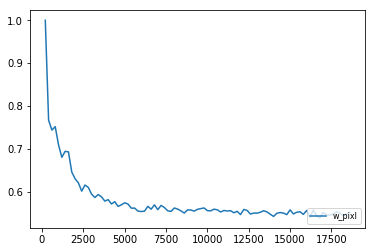

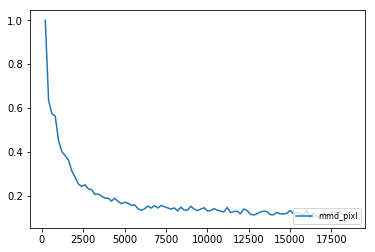

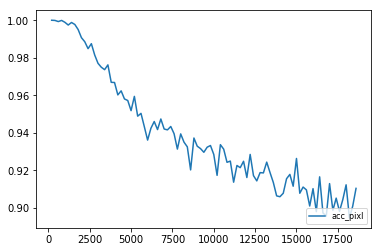

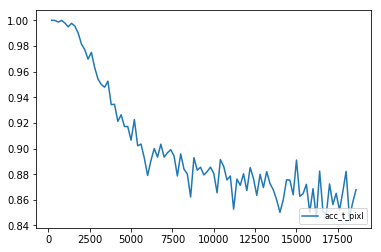

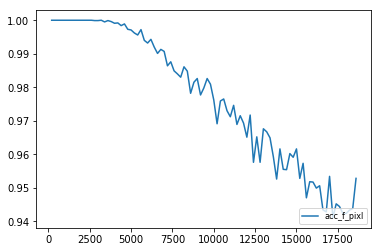

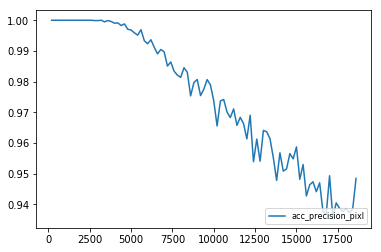

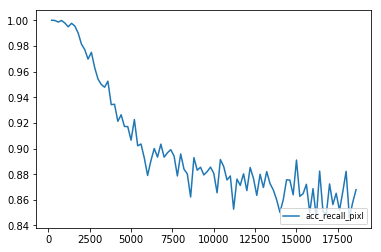

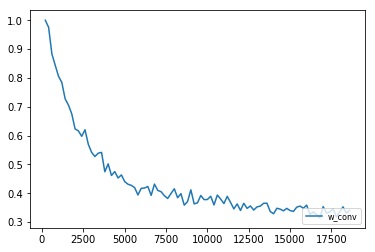

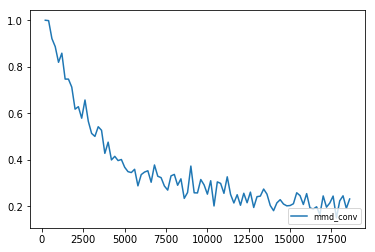

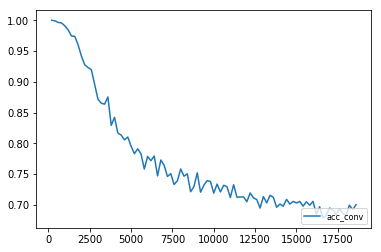

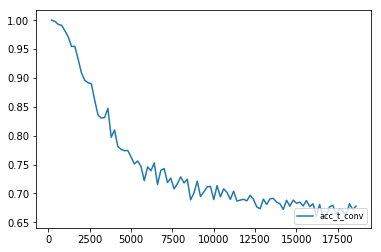

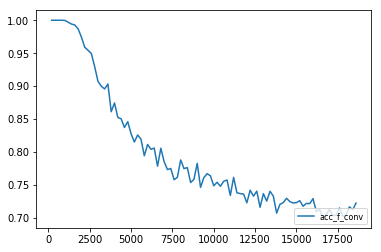

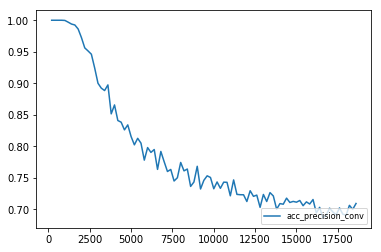

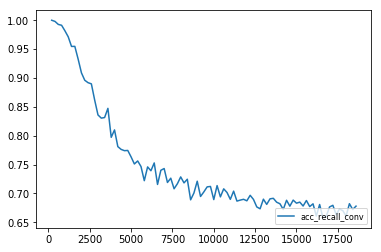

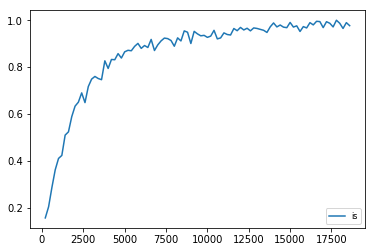

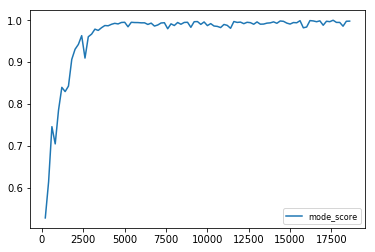

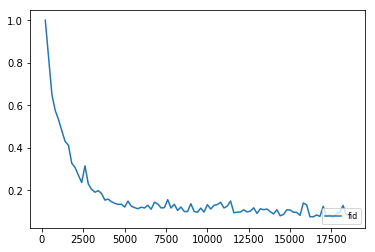

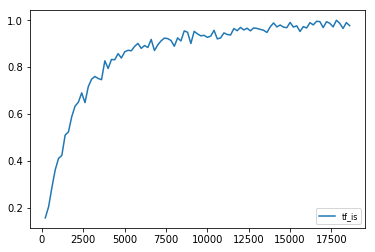

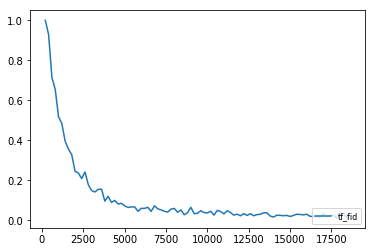

In [2]:

import torch.utils.data as Data

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam #optimizer of keras

import matplotlib.pyplot as plt

import sys

import numpy as np
import os
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels) #shape of image
        self.latent_dim = 100
        self.x = []
        self.y = np.zeros((31, 1), dtype=np.int)
        self.y = list(self.y)
        for i in range(31):
            self.y[i] = []

        optimizer = Adam(0.0002, 0.5) #optimizer of gan

        # Build and compile the discriminator,only to keras
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))  #Input():用来实例化一个keras张量
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (X_test, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.

        X_train = np.expand_dims(X_train, axis=3)  #expand_dims用于扩充数组形状
        print(np.shape(X_train))
        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        # X_test = X_test / 127.5 - 1.
        X_test = np.expand_dims(X_test, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        global_step=0
        nb_batches = int(X_train.shape[0] / batch_size)

        for epoch in range(epochs):
            for index in range(nb_batches):
                global_step += 1
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                imgs = X_train[index * batch_size:(index + 1) * batch_size]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("epoch:%d step:%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,global_step, d_loss[0], 100 * d_loss[1], g_loss))

                # If at save interval => save generated image samples
                sampleSize = 10000
                # If at save interval => save generated image samples
                if global_step % sample_interval == 0:
                    s = self.metrics(global_step, X_test, sampleSize)
        for i in range(len(s)):
            self.y[i] = [float(j) / max(self.y[i]) for j in self.y[i]]#对值进行归一化处理

        for i in range(len(s)):
            font1={'size':8}

            plt.plot(self.x, self.y[i], label=labels_name[i])
            plt.legend(loc='lower right',prop=font1)
            plt.savefig('saved_models_gan/{}.png'.format(labels_name[i]))
            plt.show()
            plt.close()

    def metrics(self, epoch, X_test, sampleSize):
        self.x.append(epoch)
        r, c = 10, sampleSize // 10
        noise = np.random.normal(0, 1, (r * c, 100))
#         sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise])
        x_dataset = MyDataset(X_test[:sampleSize])
        # print(x_dataset[0].shape)
        x_real_loader = Data.DataLoader(dataset=x_dataset, batch_size=2000, shuffle=True)
        x_fake_dataset = MyDataset(gen_imgs)
        x_fake_loader = Data.DataLoader(dataset=x_fake_dataset, batch_size=2000, shuffle=True)
        s = compute_score_raw(x_real_loader, x_fake_loader, 256, '/real/', './fake', conv_model='tfgan',
                              workers=int(1))
        real_images = tf.convert_to_tensor(X_test)  # real images
        # MNIST_CLASSIFIER_FROZEN_GRAPH = '.\classify_mnist_graph_def.pb'
        gen_imgs = np.array(gen_imgs)
        eval_images = tf.convert_to_tensor(gen_imgs)
        eval_score = utils.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)  # IS score
        frechet_distance = utils.mnist_frechet_distance(real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)
        mnist_score, f_distance = sess.run([eval_score, frechet_distance])
        # print(mnist_score)
        # print(f_distance)
        # s[14]=mnist_score
        # s[16]=f_distance
        s[17] = mnist_score
        s[18] = f_distance
        print('IS socre: %f' % mnist_score)
        print('FID: %f' % f_distance)

        for i in range(len(s)):
            print(i, "=", s[i])
        for i in range(len(s)):
            self.y[i].append(s[i])
        f.writelines('\n')
        f.writelines('epoch:' + str(epoch))
        f.writelines('\n')
        f.writelines('%.8f' % (i) for i in s)
        f.writelines('\n')
        return s


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=20, batch_size=64, sample_interval=200)
